In [7]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
#import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture
import matplotlib.ticker as ticker

import pingouin as pg


In [1]:
def cohenD(group1,group2):
    # Calculate means
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    # Calculate standard deviations
    std1 = np.std(group1, ddof=1)  # Sample standard deviation
    std2 = np.std(group2, ddof=1)

    # Calculate sample sizes
    n1 = len(group1)
    n2 = len(group2)

    # Calculate pooled standard deviation
    pooledstd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Calculate Cohen's d
    cohend = (mean1 - mean2) / pooledstd
    return cohend

In [2]:
# functions# functions
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_abs_speed_sacc(vec):#this is same as find_abs_speed, but now using a smoothed speed array,for saccade 
    # because we're using.iloc and .values, need to make sure the 
    # vec input is from dataframe
    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)

#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr,dtype = object)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen),np.ones(len(cx) - 3*winlen),np.zeros(2*winlen)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen,i[0]]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen : i[0] + 2*winlen]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen : i[0] + 2*winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift
#this is originally used to linearly interpolate 
#missing saccade data
#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10,**kwargs): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    if kwargs:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)), **kwargs),axis = 1,raw = True) 
    else:
        cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True) 

        

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 

        normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
        norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        
        normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
        norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    xBL = np.linspace(0,blt,norm_sterrBL.shape[1])
    if blHeight == None:
        blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]

    #plot mean plot for the baseline and for the trial
    [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                        color = cList[i],alpha = 0.2,)  for i in range(condN)]
    [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],linewidth = 2.5,color = cList[i],) for i in range(condN) ]

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],color = cList[i],linewidth = 2,) for i in range(condN) ]
    [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,norm_lower.min().min(),
                         norm_upper.max().max(),linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,norm_upper.max().max(),m,c = 'black',size = textSize)
    
    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
        
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd
# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt
def findGazeShift2d(xvec,yvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 0.2,
                   baselinePadding = 0,shiftWhere = False,):
    """
    @ xvec =  the gaze position horizontal channel
    @ yvec = the gaze position vertical channel
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if ***none***, calculate relative baseline  (i.e. in regard to position before and after shift)
                if ***list***, it indicate baseline rage, e.g. [500,1000]
                if ***numeric***, use the numeric value as baseline
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 0.2% 
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    @ shiftWhere = if True, only return the index where shift occurs. This is useful if use needs to combine
                    the horizontal and vertical gaze arrays. 
                    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_pup(xvec).astype(float)
    dy = find_abs_speed_pup(yvec).astype(float)
    dxySqrt = eDist(dx,dy)

    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = np.nanmedian(dxySqrt) + medianVariance(dxySqrt) *threshold
    cx = dxySqrt>thresholdx
    
    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)
    
    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))   

    # if user only needs to know the location where shift occured, return a boolean array
    # where 1 =  shift occur, 0 = no shift
    if shiftWhere:
        try:
            fillLoc = np.array([i[0] for i in msCluster]) 
            gazeshift[fillLoc] = 1
        except IndexError:
            pass
        return gazeshift

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            
            #calculate gaze position before the shift occured 
            if type(baseline) != int:
                try:
                    posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                    posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
            else: #if user decide to use a numerical value as the baseline, use that
                posbef = baseline

            #calculate the gaze position afte the shift
            try:
                posaft = np.nanmean(xvec.iloc[i[-1] : i[-1] + winlen]) 
            except:    
                posaft = np.nanmean(xvec[i[-1]: i[-1] + winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

def eDist(a,b): #eucleadian distance
    return np.sqrt(a**2+b**2)

In [3]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            minAllowedPup = 2000
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < minAllowedPup)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        temp = np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt, borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft))
        
        rejarr_padded[temp.astype(int)] = 1
    except ValueError:
        rejarr_padded = rejarr
       
    
    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        #rejarr_blkMask = np.r_[rejarr_blkMask,np.concatenate(consecutiveBlkFilter)]
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError:
        # if the user want to only return the blink mask, and that no outliter is found
        # return an empty mask, else, return pupil size.
        if returnMask:
            return np.zeros(len(rejarr))
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq],dtype = object)

    #find four index for interpolation
    indexForInterp = np.asarray([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster],dtype = object).astype(int)
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]

        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i.astype(int)] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            
            maskedPup[rejCluster[i].astype(int)] = pupExtrapolated
    except IndexError:
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup

In [4]:
pd.set_option('display.max_columns', 500)


NameError: name 'pd' is not defined

In [ ]:
#read in the mega df
local_username = 'yud070'
pathEL = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_tracker/"
pathpy = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_psychopy/"

readIn = sorted([f for f in os.listdir(pathpy)])[-48:-15]#[-15:-2]#[-10:-2]

In [ ]:
events = {'fixation':500,'stim':3000,'precueRest':500,'retrocue':500,'delay':3000}

In [ ]:
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']
selectEye = 'AVERAGE_PUPIL_SIZE'
included = 8000

In [ ]:
readRaw = False # whether to read in the txt file
processRaw = False #  whether to process pupil and gaze from the uncleaned file
getSacc = False # whether to extract saccade from cleaned gaze
saveFiles = False
rejSubj = [254,250]


# process raw and save

In [ ]:
if readRaw:
    #for recording everyone's preprocessed data along with saccade tags
    psyFull = pd.DataFrame()

    pupFullTrial_raw = pd.DataFrame()
    saccFullTrial_x_raw = pd.DataFrame()
    saccFullTrial_y_raw = pd.DataFrame()
    eventDf = pd.DataFrame()

    #readIn raw files
    for n,f in enumerate(readIn):

        """ section1: read in """
        f = str(f)
        print('start processing: ' + f)

        el = pd.read_csv(glob.glob(pathEL+ f + '/*.txt')[0]
                ,delimiter = "\t", usecols = relevantCols)#encoding = 'utf-16'
    

        el['TRIALID'] = el.TRIALID.replace('UNDEFINED',np.nan)
        el = el[~el.TRIALID.isnull()]
        el['SAMPLE_MESSAGE'] = el.SAMPLE_MESSAGE.replace('.',np.nan).ffill()

        #after reading in el file, transform to trial * timestamp structure
        
        pseudodf = el

        pseudodf = pseudodf.rename(columns={selectEye:'diameter_3d','TIMESTAMP':'pupil_timestamp'}).reset_index(drop = True)
        pseudodf['diameter_3d'] = pd.to_numeric(pseudodf['diameter_3d'].replace('.',0))
        pseudodf['AVERAGE_GAZE_X'] = pd.to_numeric(pseudodf['AVERAGE_GAZE_X'].replace('.',np.nan))
        pseudodf['AVERAGE_GAZE_Y'] = pd.to_numeric(pseudodf['AVERAGE_GAZE_Y'].replace('.',np.nan))
        pseudodf['eventOnset'] = pseudodf.SAMPLE_MESSAGE.astype(str) #prepare for index for  epoching
        pseudodf['x'] = pseudodf.groupby('TRIALID').cumcount() #prepare for transformation
    

        pupRaw = pd.pivot_table(pseudodf[['x','diameter_3d','TRIALID']],values = 'diameter_3d',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        eventOnset = pseudodf.pivot(values = 'eventOnset',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        saccAllT_X = pd.pivot_table(pseudodf[['x','AVERAGE_GAZE_X','TRIALID']],values = 'AVERAGE_GAZE_X',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        saccAllT_Y = pd.pivot_table(pseudodf[['x','AVERAGE_GAZE_Y','TRIALID']],values = 'AVERAGE_GAZE_Y',columns = 'x',index = 'TRIALID').reset_index().iloc[:,:included+1]
        
        
        #concate
        print('     start concate: ' + f)

        #pupil
        pupFullTrial_raw = pd.concat([pupFullTrial_raw,pupRaw])
        #sacc
        saccFullTrial_x_raw = pd.concat([saccFullTrial_x_raw,saccAllT_X])
        saccFullTrial_y_raw = pd.concat([saccFullTrial_y_raw,saccAllT_Y])
        #event
        eventDf = pd.concat([eventDf,eventOnset])


In [ ]:
try:
    #view distribution of pupil size data
    pupDat = pupFullTrial_raw.iloc[:,1:].values.flatten()
    plt.hist(pupDat,bins = 50)
except NameError:
    pass

In [ ]:
psyFull = pd.DataFrame()
for f in readIn:
    f = str(f)

    trlInfo = pd.read_csv(glob.glob(pathpy+f+ '/*.csv')[0])
    cols = trlInfo[['probe.started','probeStart','probe.stopped','probeEnd','probeMouse.x','probeMouse.y',
    'probeMouse.leftButton','probeMouse.midButton','probeMouse.rightButton','probeMouse.time','probeMouse.mouseOnProbes',
    'probeLocationArr','rspIndex','rsp','rspPath','rt','timeEachClick','itemEachClick','missingRsp','ITI.started','itiStart','ITI.stopped','itiEnd']]
    newDf = trlInfo[~trlInfo.cuedItem.isnull()].reset_index(drop = True)

    newDf[['probe.started','probeStart','probe.stopped','probeEnd','probeMouse.x','probeMouse.y',
    'probeMouse.leftButton','probeMouse.midButton','probeMouse.rightButton','probeMouse.time','probeMouse.mouseOnProbes',
    'probeLocationArr','rspIndex','rsp','rspPath','rt','timeEachClick','itemEachClick','missingRsp','ITI.started','itiStart','ITI.stopped','itiEnd']] = cols.dropna(axis = 0, how ='all').reset_index(drop=True)


    psyFull = pd.concat([psyFull,newDf])


psyFull = psyFull.drop_duplicates()

In [ ]:
if processRaw:
    #run the preprocessing if the raw file has been readin
    if pupFullTrial_raw.shape[0] != 0:
        """for pupil data, apply the speed filter (dBlink)"""
        #Clean once
        cleanOnce = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                    borderlenBef= 0.05, borderlenAft = 0.2,minAllowedPup = 2000,
                                                    clusterLapse = 0.05, madThreshold = 10),axis = 1,raw = True)

        #smooth the resulting array using rolling window of size 11
        onceSmooth = cleanOnce.rolling(21,min_periods=1,center  = True,axis =1).mean()

        #second clean, this is to get rid of any residual outlier
        cleanTwice = onceSmooth.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),minAllowedPup = 2000,
                                                borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                                clusterLapse = 0.05,madThreshold = 12),axis =1,raw = True)
        
        #reset Index, add back the trial id
        pupFullTrial = cleanTwice.reset_index(drop = True)
        pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID.values)

        """for pupil data only, mask off data using a size filter"""
        #mask off any pupil data that exceed a median +- n*medianSD threshold for that subject
        sdThreshold = 6
        stdmask = pd.DataFrame()
        temp = pupFullTrial.merge(psyFull[['participant','TRIALID']],how = 'left',
                        left_on='TRIALID', right_on='TRIALID')

        for i in temp.participant.unique():
            tempdf = temp[temp.participant == i]

            #calculate upper/lower bounds
            stdupper = np.nanmedian(tempdf.iloc[:,1:included+1])  + sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
            stdlower = np.nanmedian(tempdf.iloc[:,1:included+1])  - sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
            #create std mask for this subj
            stdmask_temp = (tempdf.iloc[:,1:included+1] > stdupper) | (tempdf.iloc[:,1:included+1] < stdlower)
            stdmask_temp.insert(0,'TRIALID',tempdf.TRIALID)
            
            stdmask = pd.concat([stdmask,stdmask_temp])
        
        # no one cared who i was until I put on the df.mask
        # reject the invalid data that's outside of the threshold
        pupFullTrial.iloc[:,1:] = pupFullTrial.iloc[:,1:].mask(stdmask.iloc[:,1:],np.nan)
    pupFullTrial = cleanTwice.reset_index(drop = True)
    pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID.values)
  
    #keep the trial if it has more than 90% data retained in the period of interest
    #trialwise
    pupClean = pupFullTrial[(pupFullTrial.iloc[:,4001:7501].isnull().sum(axis = 1)) < (0.2* 3500)] .reset_index(drop = True)

    pupClean = pupClean[~pupClean.TRIALID.isin(psyFull[psyFull.missingRsp == True].TRIALID.values)]

    #look at the trial remainz
    pd.DataFrame([ast.literal_eval(i)[0] for i in pupClean['TRIALID']]).value_counts()

    

In [1]:

if processRaw:

    #run the preprocessing if the raw file has been readin
    if pupFullTrial_raw.shape[0] != 0:
        """for pupil data, apply the speed filter (dBlink)"""
        #Clean once
        cleanOnce = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                    borderlenBef= 0.05, borderlenAft = 0.2,minAllowedPup = 2000,
                                                    clusterLapse = 0.05, madThreshold = 10),axis = 1,raw = True)

        #smooth the resulting array using rolling window of size 11
        onceSmooth = cleanOnce.rolling(11,min_periods=1,center  = True,axis =1).mean()

        #second clean, this is to get rid of any residual outlier
        cleanTwice = onceSmooth.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),minAllowedPup = 2000,
                                                borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                                clusterLapse = 0.05,madThreshold = 12),axis =1,raw = True)
        
        #reset Index, add back the trial id
        pupFullTrial = cleanTwice.reset_index(drop = True)
        pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID.values)

        """for pupil data only, mask off data using a size filter"""
        #mask off any pupil data that exceed a median +- n*medianSD threshold for that subject
        sdThreshold = 6
        stdmask = pd.DataFrame()
        temp = pupFullTrial.merge(psyFull[['participant','TRIALID']],how = 'left',
                        left_on='TRIALID', right_on='TRIALID')

        for i in temp.participant.unique():
            tempdf = temp[temp.participant == i]

            #calculate upper/lower bounds
            stdupper = np.nanmedian(tempdf.iloc[:,1:included+1])  + sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
            stdlower = np.nanmedian(tempdf.iloc[:,1:included+1])  - sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
            #create std mask for this subj
            stdmask_temp = (tempdf.iloc[:,1:included+1] > stdupper) | (tempdf.iloc[:,1:included+1] < stdlower)
            stdmask_temp.insert(0,'TRIALID',tempdf.TRIALID)
            
            stdmask = pd.concat([stdmask,stdmask_temp])
        
        # no one cared who i was until I put on the df.mask
        # reject the invalid data that's outside of the threshold
        pupFullTrial.iloc[:,1:] = pupFullTrial.iloc[:,1:].mask(stdmask.iloc[:,1:],np.nan)
    if pupFullTrial_raw.shape[0] != 0:

        """generate the gaze mask, to filter out """
        #also return the blink mask; the mask have a high positive rate, i set the mad threshold (mad = 12) to be higher to 
        #decrease the false positive
        maskClean = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,included/1000,len(x)),
                                                    borderlenBef= 0.05, borderlenAft = 0.05,minAllowedPup = 2000,
                                                    clusterLapse = 0.03, madThreshold = 12,returnMask = True),axis = 1,raw = True)
        maskClean.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)

        #find trials that are in both saccfull and in mask (this is just a safty check)
        sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
        gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
        stdmask2 = stdmask[stdmask.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

        #further filter by the pupil std mask
        gazeMask.iloc[:,1:] = pd.DataFrame( gazeMask.iloc[:,1:].values.astype(bool)|
                                        stdmask2.iloc[:,1:].values.astype(bool))#cleanTwiceMask.iloc[:,1:].values.astype(bool) |

        saccTemp_x = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
        saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

        #sanity check, the trial label should be the same, if not raise error
        if (sum(gazeMask.TRIALID != saccTemp_x.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
            #put the mask on
            saccTemp_x.iloc[:,1:] = saccTemp_x.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
            saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
        else:
            raise('TRIALID mismatch between saccade raw and saccade mask')
        
        #aggregate the sacc temp x and y dfs
        saccTemp_x['axis'] = 'x'
        saccTemp_y['axis'] = 'y'
        saccTemp = pd.concat([saccTemp_x,saccTemp_y]).reset_index(drop = True)

        # drop the useless trials
        trlsKept = pupClean.TRIALID
        saccTemp = saccTemp[saccTemp.TRIALID.isin(trlsKept)].reset_index()

        """interpolation"""
        #anti-aliasing for interpolation
        saccTemp2 = saccTemp.iloc[:,1:].rolling(11,min_periods=1,center  = True,axis =1).mean()

        #interpolation of gaze data
        x = np.linspace(0,5,included)
        saccClean = saccTemp2.iloc[:,:included].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
        saccClean.insert(0,'TRIALID',saccTemp.TRIALID)
        saccClean.insert(0,'axis',saccTemp.axis)
        saccClean.set_index(['axis'],inplace=True)

        """rejecting trials"""
        #drop trials with all null
        #nullTrls = saccClean[(saccClean.iloc[:,500:-500].isnull().sum(axis = 1)) >= (0.2* 5500)].TRIALID
        #saccClean = saccClean[~saccClean.TRIALID.isin(nullTrls)]
    

NameError: name 'processRaw' is not defined

In [ ]:
try:
    xx= np.random.randint(0,len(pupFullTrial))
    plt.plot(np.linspace(0,included/1000,included),pupFullTrial_raw.iloc[xx,1:],
            c = 'r')
    plt.plot(np.linspace(0,included/1000,included),pupClean[pupClean.TRIALID == pupFullTrial_raw.iloc[xx,0]].iloc[:,1:].values[0],c = 'b')

except NameError:
    pass

In [ ]:
if getSacc:
    #minimum distance required for a gaze shift to be 
    #counted as saccade (5pixel) in either direction
    xShiftMin = 8
    yShiftMin = 8

    """calculate gaze shift"""

    #i used a higher smooth value for y because its is more noisy
    smoothSaccX = saccClean.loc['x'].iloc[:,1:].apply(lambda x: smooth(x,window_len=51),axis =1,raw = True)
    smoothSaccY = saccClean.loc['y'].iloc[:,1:].apply(lambda x: smooth(x,window_len=51),axis =1,raw = True)


    #initialize empty sacc array
    shiftDf_relX = np.zeros(shape = smoothSaccX.shape)#relative shift direction in regard to each saccadic movement
    shiftDf_relY = np.zeros(shape = smoothSaccY.shape)

    # calculate the shift
    for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
        shiftDf_relX[i] = findGazeShift2d(x,y,
                            shiftmin = 0,threshold = 6,)
        shiftDf_relY[i] = findGazeShift2d(y,x,
                            shiftmin = 0,threshold = 6)


    """filter out drifts that's too small"""
    shiftDf_relX = np.where(((abs(shiftDf_relX) > xShiftMin) | (abs(shiftDf_relY) > yShiftMin)),shiftDf_relX,0)
    shiftDf_relY = np.where(((abs(shiftDf_relX) > xShiftMin) | (abs(shiftDf_relY) > yShiftMin)),shiftDf_relY,0)

    shiftDf_relX = pd.DataFrame(shiftDf_relX)
    shiftDf_relX.insert(0,'TRIALID',saccClean.loc['x'].TRIALID.values)
    shiftDf_relX.insert(0,'axis','x')

    shiftDf_relY = pd.DataFrame(shiftDf_relY)
    shiftDf_relY.insert(0,'TRIALID',saccClean.loc['y'].TRIALID.values)
    shiftDf_relY.insert(0,'axis','y')

    shiftDf_rel = pd.concat([shiftDf_relX,shiftDf_relY],axis = 0)

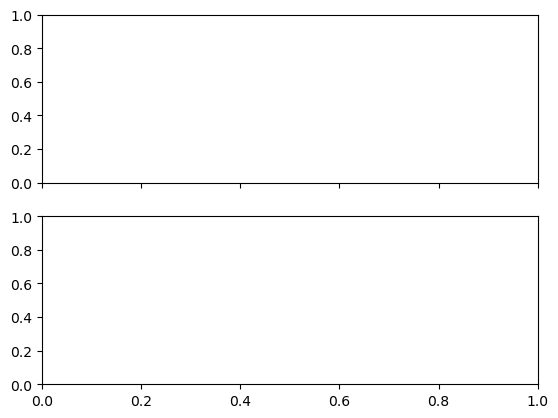

In [ ]:
try:
    fig,ax = plt.subplots(nrows = 2,sharex=True)
    ax[0].plot(shiftDf_relX[4])
    ax[1].plot(shiftDf_relY[4])
except NameError:
    pass

## raw data

In [ ]:
thisBatch = ''

In [ ]:
if saveFiles:
    rawGazeFileName_x = f'Z:/yueying/psychedeLights_YueyingDong/gazeRaw_formatted/gazeRaw_x_{thisBatch}.csv'
    rawGazeFileName_y = f'Z:/yueying/psychedeLights_YueyingDong/gazeRaw_formatted/gazeRaw_y_{thisBatch}.csv'

    if os.path.exists(rawGazeFileName_x):
        print(f"File exists in folder '{rawGazeFileName_x}'.")
    else:
        saccFullTrial_x_raw.to_csv(rawGazeFileName_x)
        saccFullTrial_y_raw.to_csv(rawGazeFileName_y)

    #rawGazeFileName_x = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/gazeRaw_x_{thisBatch}.csv'
    #rawGazeFileName_y = f'Z:/yueying/gazeObject_YueyingDong/gazeRaw_formatted/gazeRaw_y_{thisBatch}.csv'
    rawPupFileName = f'Z:/yueying/psychedeLights_YueyingDong/pupRaw_formatted/pupRaw_{thisBatch}.csv'

    if os.path.exists(rawPupFileName):
        print(f"File exists in folder '{rawPupFileName}'.")
    else:
        #saccFullTrial_x_raw.to_csv(rawGazeFileName_x)
        #saccFullTrial_y_raw.to_csv(rawGazeFileName_y)
        pupFullTrial_raw.to_csv(rawPupFileName)
    
    cleanPupFileName = f'Z:/yueying/psychedeLights_YueyingDong/results/data/pupClean/cleanPup_{thisBatch}.csv'
    if os.path.exists(cleanPupFileName):
            print(f"File exists in folder '{cleanPupFileName}'.")
    else:
        pupClean.to_csv(cleanPupFileName)

    cleanGazeFileName = f"Z:/yueying/psychedeLights_YueyingDong/results/data/gazeClean/cleanGaze_{thisBatch}.csv"
    if os.path.exists(cleanGazeFileName):
            print(f"File exists in folder '{cleanGazeFileName}'.")
    else:
        saccClean.to_csv(cleanGazeFileName)

    #save file, specify a batch name e.g. 301to305
    cleanSaccFileName = f"Z:/yueying/psychedeLights_YueyingDong/results/data/saccClean/cleanSacc_{thisBatch}.csv"
    if os.path.exists(cleanSaccFileName):
            print(f"File exists in folder '{cleanSaccFileName}'.")
    else:
        shiftDf_rel.to_csv(cleanSaccFileName)

    #save psychopy
    psyPath = "Z:/yueying/psychedeLights_YueyingDong/results/data/psychopy/psyFull_" + thisBatch + ".csv"
    if os.path.exists(psyPath):
        print('file exist')
    else:
        psyFull.to_csv(psyPath)

# readin data

In [18]:
psyFull = pd.DataFrame()
for i in glob.glob('Z:/yueying/psychedeLights_YueyingDong/results/data/psychopy/psyFull_*.csv'):
    psyFull = pd.concat([psyFull,pd.read_csv(i).iloc[:,:]],axis = 0)

psyFull = psyFull.reset_index(drop=True)

In [52]:
pupClean = pd.DataFrame()
for i in glob.glob('Z:/yueying/psychedeLights_YueyingDong/results/data/pupClean/*.csv'):
    pupClean = pd.concat([pupClean,pd.read_csv(i).iloc[:,1:]],axis = 0)

pupClean = pupClean.reset_index(drop=True)

In [ ]:
pupFullTrial_raw = pd.DataFrame()
for i in glob.glob('Z:/yueying/psychedeLights_YueyingDong/pupRaw_formatted/*.csv'):
    pupFullTrial_raw = pd.concat([pupFullTrial_raw,pd.read_csv(i).iloc[:,1:]],axis = 0)


In [66]:
saccClean = pd.DataFrame()
for i in glob.glob('Z:/yueying/psychedeLights_YueyingDong/results/data/gazeClean/*.csv'):#360to400
    saccClean = pd.concat([saccClean,pd.read_csv(i).iloc[:,:]],axis = 0)
saccClean.set_index('axis',inplace=True)

In [21]:
shiftDf_rel = pd.DataFrame()
for i in glob.glob('Z:/yueying/psychedeLights_YueyingDong/results/data/saccClean/*.csv'):
    shiftDf_rel = pd.concat([shiftDf_rel,pd.read_csv(i).iloc[:,:]],axis = 0)

shiftDf_rel.set_index('axis',inplace=True)

# behav.

In [ ]:
# Get window dimensions in pixels
window_width_pix = 1920
window_height_pix = 1080

# Example normalized position (e.g., top-right corner in norm units)
norm_pos = [0.2, 0]

# Convert normalized position to pixel position (relative to center)
pix_x = norm_pos[0] * (window_width_pix / 2)
pix_y = norm_pos[1] * (window_height_pix / 2)

In [20]:
pix_x,pix_y

(192.0, 0.0)

In [ ]:
from datetime import datetime

In [22]:
irb = pd.read_csv("Z:/yueying/psychedeLights_YueyingDong/data/irb_psychedeLights.csv")

In [23]:
irb['dob_clean'] = pd.to_datetime(irb.Q26,format='mixed',errors='coerce')
current_date = datetime.now()

birthdate = irb['dob_clean'] 
irb ['age']= [current_date.year - birthdate.year - ((current_date.month, current_date.day) < (birthdate.month, birthdate.day)) for birthdate in irb['dob_clean'] ]

In [ ]:
rejSubj = [254,250,]

In [25]:
psyFull.participant.nunique()

46

In [26]:
psyFull = psyFull[~psyFull.participant.isin(rejSubj)].reset_index(drop=True)

In [27]:
irb = irb[irb.id.isin(psyFull.participant)]
print(irb.age.min(),'\n',irb.age.max(),'\n',irb.age.mean(),'\n',irb.age.std(),)
irb['gender'] = [i.lower().strip() for i in irb.Q25]#
irb['gender'].value_counts()

18.0 
 26.0 
 20.767441860465116 
 1.5405195367043822


gender
female    34
male      10
Name: count, dtype: int64

In [28]:
psyFull[['trlType','distractorType']].groupby(['trlType','distractorType']).size()

trlType  distractorType
verbal   congruent          704
         incongruent        703
         noDistractor      3339
visual   congruent          704
         incongruent        702
         noDistractor      3340
dtype: int64

In [29]:
psyFull.participant.value_counts()

participant
249.0    216
284.0    216
275.0    216
276.0    216
278.0    216
279.0    216
280.0    216
281.0    216
282.0    216
283.0    216
286.0    216
251.0    216
287.0    216
289.0    216
290.0    216
291.0    216
292.0    216
293.0    216
294.0    216
295.0    216
274.0    216
273.0    216
272.0    216
271.0    216
252.0    216
253.0    216
255.0    216
256.0    216
257.0    216
258.0    216
259.0    216
260.0    216
261.0    216
262.0    216
263.0    216
264.0    216
265.0    216
266.0    216
267.0    216
268.0    216
269.0    216
270.0    216
296.0    216
288.0    204
Name: count, dtype: int64

In [30]:
psyFull['cuedItemBri'] = [left if direction == 'left' else right for(direction, left, right) in zip(psyFull.cuedItem,psyFull.leftBri,psyFull.rightBri)]
psyFull['correctness'] = np.where(psyFull.rsp !='cuedItem',0,1)
psyFull['logRT'] = np.log(psyFull.rt)

In [31]:
out = []
for i,k in zip(psyFull.distractorType,psyFull.trlType):
    if (i =='congruent' ) &(k =='verbal'):
        out.append('verbal')
    elif (i =='incongruent' ) &(k =='visual'):
        out.append('verbal')
    elif (i =='congruent' ) &(k =='visual'):
        out.append('visual')
    elif (i =='incongruent' ) &(k =='verbal'):
        out.append('visual')
    else:
        out.append('noDistractor')


In [32]:
psyFull['distractorType_visVer'] = out

In [33]:
subjMean = psyFull.groupby(['participant','trlType']).mean(numeric_only=True).reset_index()
pg.rm_anova(data = subjMean, dv = 'correctness',
    within= ['trlType',], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2       F  p-unc    np2
0  trlType      1     43  13.205  0.001  0.235

In [34]:
subjMean = psyFull.groupby(['participant','trlType','distractorType']).mean(numeric_only=True).reset_index()
pg.rm_anova(data = subjMean, dv = 'correctness',
    within= ['trlType','distractorType'], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2       F  p-unc    np2
0                   trlType      1     43  10.083  0.003  0.190
1            distractorType      2     86  18.463  0.000  0.300
2  trlType * distractorType      2     86   0.609  0.546  0.014

In [35]:
np.mean(subjMean[subjMean.distractorType =='noDistractor'].correctness)

0.8286975808867024

In [36]:
pg.rm_anova(data = subjMean, dv = 'rt',
    within= ['trlType','distractorType'], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2       F  p-unc    np2
0                   trlType      1     43   3.237  0.079  0.070
1            distractorType      2     86  60.679  0.000  0.585
2  trlType * distractorType      2     86   2.340  0.102  0.052

In [37]:
pg.rm_anova(data = subjMean[subjMean.distractorType != 'noDistractor'], dv = 'correctness',
    within= ['trlType','distractorType'], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2      F  p-unc    np2
0                   trlType      1     43  7.349  0.010  0.146
1            distractorType      1     43  4.066  0.050  0.086
2  trlType * distractorType      1     43  0.760  0.388  0.017

In [38]:
print(stats.ttest_rel(subjMean[(subjMean.distractorType == 'congruent') & (subjMean.trlType=='visual')].correctness,
                subjMean[(subjMean.distractorType == 'incongruent') & (subjMean.trlType=='visual')].correctness,
                nan_policy='omit'))
print(
'\ncohen d',round(cohenD(subjMean[(subjMean.distractorType == 'congruent') & (subjMean.trlType=='visual')].correctness,
                subjMean[(subjMean.distractorType == 'incongruent') & (subjMean.trlType=='visual')].correctness,),2))

TtestResult(statistic=-2.031245015278551, pvalue=0.04844066454687308, df=43)

cohen d -0.23


In [39]:
print(stats.ttest_rel(subjMean[(subjMean.distractorType == 'congruent') & (subjMean.trlType=='verbal')].correctness,
                subjMean[(subjMean.distractorType == 'incongruent') & (subjMean.trlType=='verbal')].correctness,
                nan_policy='omit'))
print(
'\ncohen d',round(cohenD(subjMean[(subjMean.distractorType == 'congruent') & (subjMean.trlType=='verbal')].correctness,
                subjMean[(subjMean.distractorType == 'incongruent') & (subjMean.trlType=='verbal')].correctness,),2))

TtestResult(statistic=-0.7418214593712582, pvalue=0.4622282905979185, df=43)

cohen d -0.09


In [40]:
subjMean = psyFull.groupby(['participant','trlType','distractorType_visVer']).mean(numeric_only=True).reset_index()
subjMean['correctness'] = subjMean['correctness']*100

In [41]:
plt.rcParams['font.family'] = 'arial'

In [42]:
pg.rm_anova(data = subjMean[subjMean.distractorType_visVer == 'noDistractor'], dv = 'correctness',
    within= ['trlType',], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2       F  p-unc    np2
0  trlType      1     43  13.243  0.001  0.235

In [43]:
pg.rm_anova(data = subjMean[subjMean.distractorType_visVer != 'noDistractor'], dv = 'correctness',
    within= ['trlType','distractorType_visVer'], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2      F  p-unc    np2
0                          trlType      1     43  7.349  0.010  0.146
1            distractorType_visVer      1     43  0.760  0.388  0.017
2  trlType * distractorType_visVer      1     43  4.066  0.050  0.086

In [44]:
print(stats.ttest_rel(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].correctness,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].correctness,
                nan_policy='omit'))
print(
'\ncohen d',round(cohenD(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].correctness,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].correctness,),2))

TtestResult(statistic=-3.639073458560661, pvalue=0.000728871239023791, df=43)

cohen d -0.36


In [45]:
print(stats.ttest_rel(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].logRT,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].logRT,
                nan_policy='omit'))
print(
'\ncohen d',round(cohenD(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].logRT,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].logRT,),2))

TtestResult(statistic=-3.3620853243404913, pvalue=0.0016330952026106336, df=43)

cohen d -0.33


In [46]:
stats.ttest_rel(subjMean[(subjMean.distractorType_visVer == 'visual') & (subjMean.trlType=='visual')].correctness,
                subjMean[(subjMean.distractorType_visVer == 'verbal') & (subjMean.trlType=='visual')].correctness,
                nan_policy='omit')

TtestResult(statistic=-2.0312450152785506, pvalue=0.048440664546873166, df=43)

In [47]:
stats.ttest_rel(subjMean[(subjMean.distractorType_visVer == 'visual') & (subjMean.trlType=='verbal')].correctness,
                subjMean[(subjMean.distractorType_visVer == 'verbal') & (subjMean.trlType=='verbal')].correctness,
                nan_policy='omit')

TtestResult(statistic=0.7418214593712581, pvalue=0.46222829059791837, df=43)

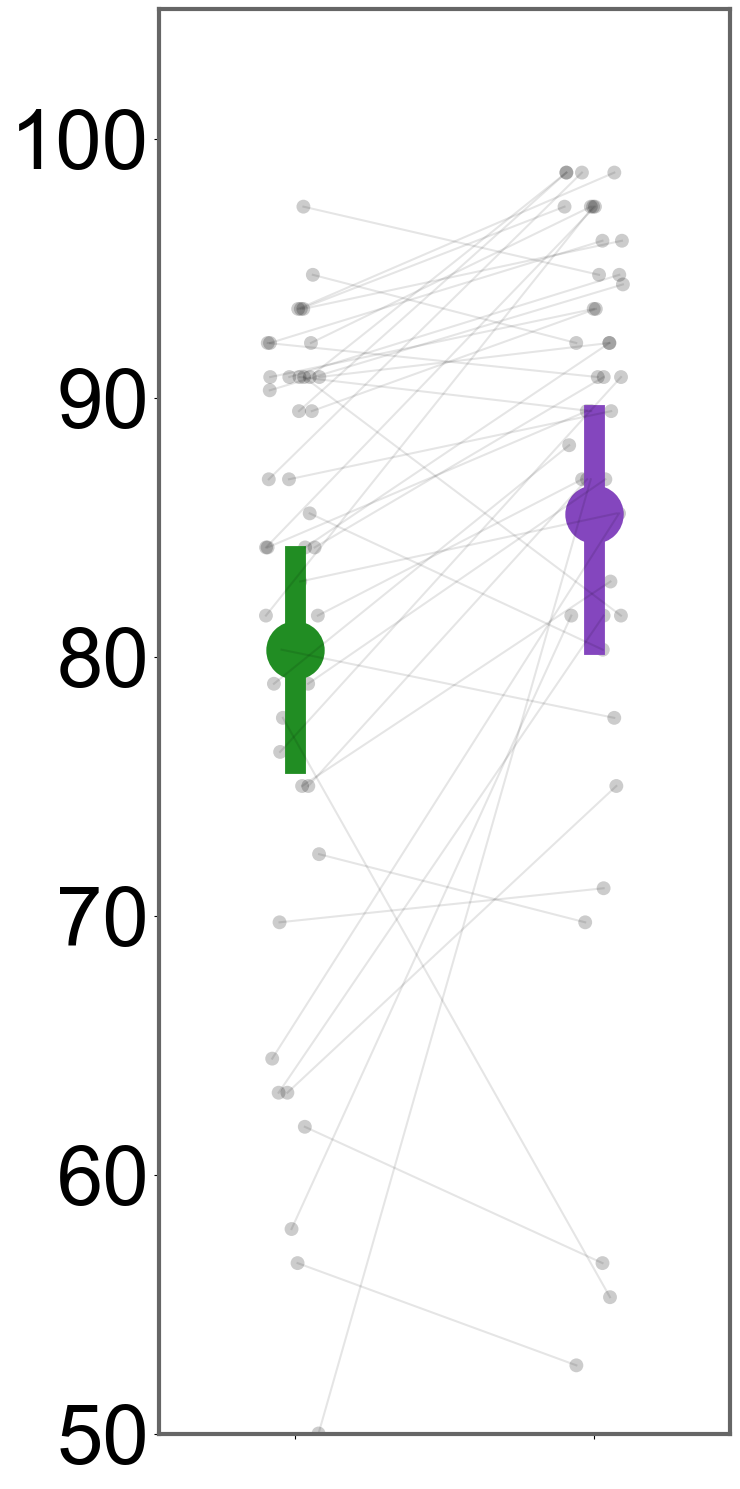

In [48]:


fs(7.5,15)
fig,ax = plt.subplots()
sns.stripplot(
    data=subjMean[subjMean.distractorType_visVer == 'noDistractor'], 
    x="trlType", y="correctness", hue='trlType',
    hue_order=['visual','verbal'],
    palette=['black'], order = ['visual','verbal'], 
    alpha=.2, legend=False,size=10, zorder = 1,
)

sns.pointplot(
    data=subjMean[subjMean.distractorType_visVer == 'noDistractor'], 
    x="trlType", y="correctness", hue="trlType",
    palette=['black','#218d23',"#8446be"],order = ['visual','verbal'], hue_order=['noDistractor','visual','verbal'],
   legend=False,linestyles='none',errwidth= 15,markersize=40,
)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)

plt.ylim(50,105)

plt.tick_params(axis='y', which='major', labelsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.margins(y=0.1,x = 0.3)

plt.tight_layout()

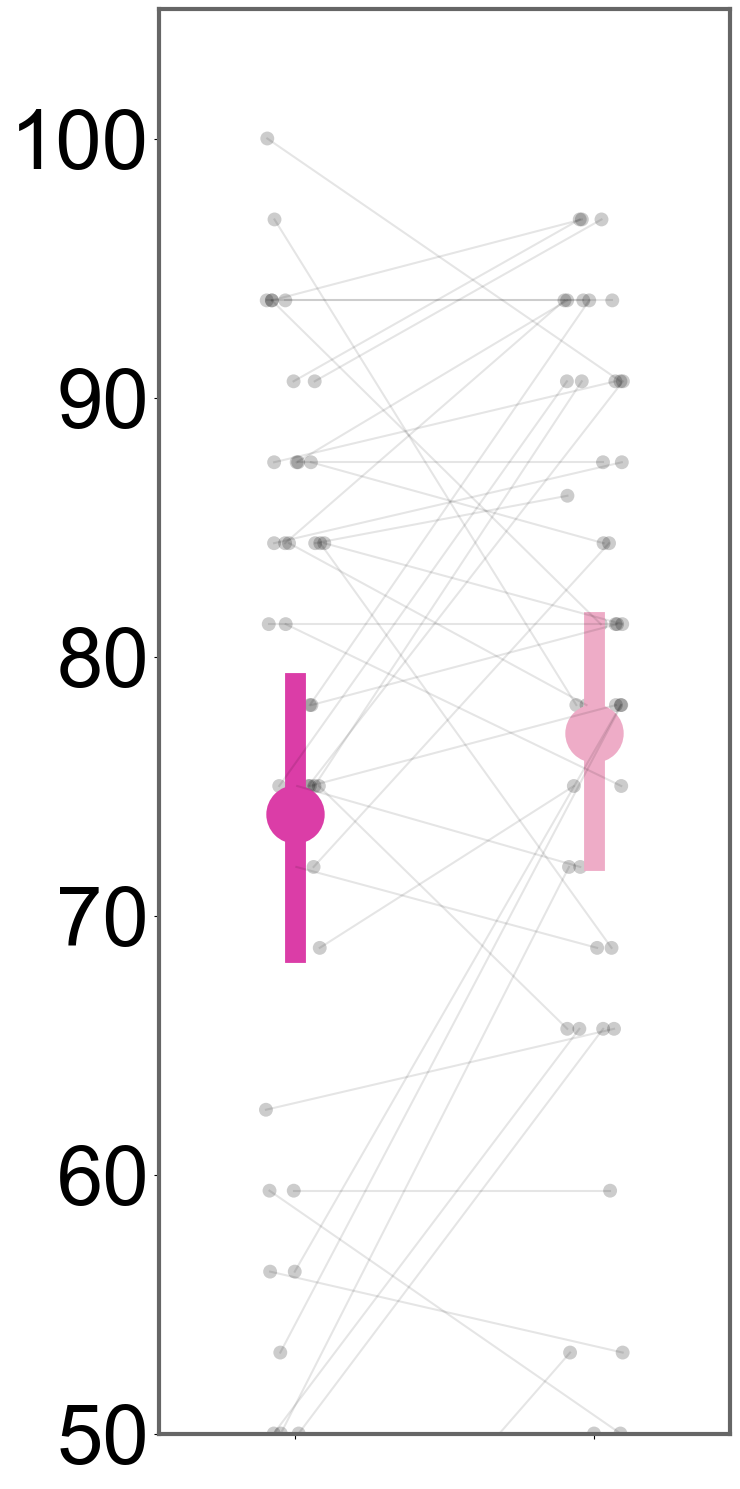

In [53]:
subjMean = psyFull.groupby(['participant','distractorType']).mean(numeric_only=True).reset_index()
subjMean['correctness'] = subjMean['correctness']*100

fs(7.5,15)
fig,ax = plt.subplots()

sns.stripplot(
    data=subjMean[subjMean.distractorType != 'noDistractor'], 
     x ="distractorType", y="correctness",
    palette=['black'], order = ['congruent','incongruent'], 
    alpha=.2, legend=False,size=10, zorder = 1,
)


f = sns.pointplot(
    data=subjMean[subjMean.distractorType != 'noDistractor'], 
    x ="distractorType", y="correctness", hue ="distractorType",
    palette=["#DB3DA7","#eeacc7"],order = ['congruent','incongruent'], hue_order=['congruent','incongruent'],
   legend=False,linestyles='none',errwidth= 15,markersize=40, 
)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)
plt.ylim(50,105)

plt.tick_params(axis='y', which='major', labelsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.margins(y=0.1,x = 0.3)

plt.tight_layout()

In [54]:
pg.rm_anova(data = subjMean[subjMean.distractorType != 'noDistractor'], dv = 'correctness',
    within= ['distractorType',], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2      F  p-unc    np2
0  distractorType      1     43  4.052   0.05  0.086

In [56]:
print(stats.ttest_rel(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].logRT,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].logRT,
                nan_policy='omit'))

print(round(cohenD(subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='visual')].logRT,
                subjMean[(subjMean.distractorType_visVer == 'noDistractor') & (subjMean.trlType=='verbal')].logRT,),2))

AttributeError: 'DataFrame' object has no attribute 'distractorType_visVer'

In [ ]:
pg.rm_anova(data = subjMean[subjMean.distractorType_visVer != 'noDistractor'], dv = 'logRT',
    within= ['trlType','distractorType_visVer'], subject='participant',
    effsize = 'np2')[['Source','ddof1','ddof2','F','p-unc','np2']].round(3)

Source  ddof1  ddof2      F  p-unc    np2
0                          trlType      1     43  2.637  0.112  0.058
1            distractorType_visVer      1     43  2.102  0.154  0.047
2  trlType * distractorType_visVer      1     43  0.468  0.498  0.011

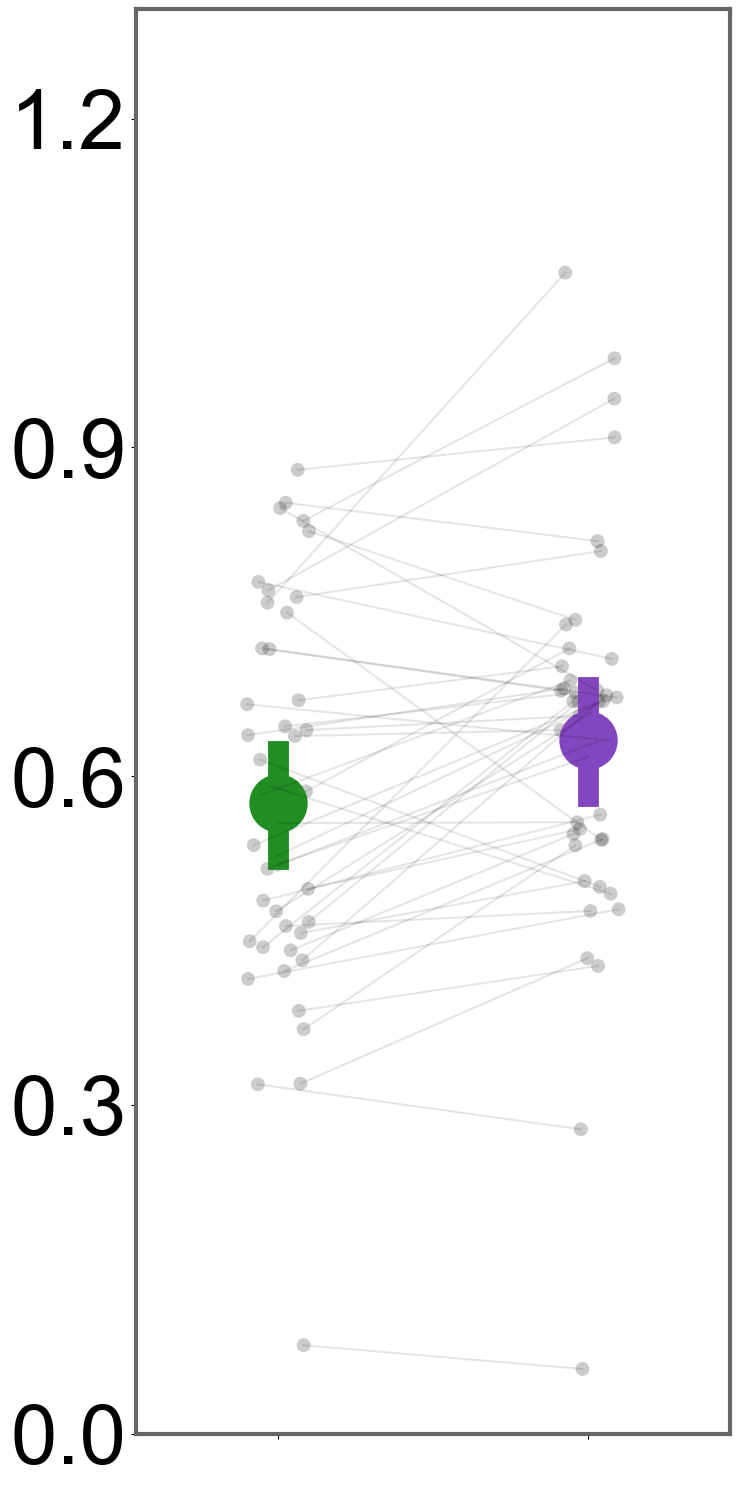

In [ ]:
subjMean = psyFull.groupby(['participant','trlType','distractorType_visVer']).mean(numeric_only=True).reset_index()
subjMean['correctness'] = subjMean['correctness']*100

fs(7.5,15)
fig,ax = plt.subplots()
sns.stripplot(
    data=subjMean[subjMean.distractorType_visVer == 'noDistractor'], 
    x="trlType", y="logRT", hue='trlType',
    hue_order=['visual','verbal'],
    palette=['black'], order = ['visual','verbal'], 
    alpha=.2, legend=False,size=10, zorder = 1,
)

sns.pointplot(
    data=subjMean[subjMean.distractorType_visVer == 'noDistractor'], 
    x="trlType", y="logRT", hue="trlType",
    palette=['black','#218d23',"#8446be"],order = ['visual','verbal'], hue_order=['noDistractor','visual','verbal'],
   legend=False,linestyles='none',errwidth= 15,markersize=40,
)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)


plt.tick_params(axis='y', which='major', labelsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.3))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');

plt.ylim(0,1.3)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.margins(y=0.1,x = 0.3)

plt.tight_layout()

## day vs night

In [ ]:
memErrSubjBri = psyFull[['participant','rt','correctness','cuedItemBri']].groupby(['participant','cuedItemBri']).mean().reset_index()

In [ ]:
memErrSubjBri['correctness'] = memErrSubjBri['correctness'] *100

In [ ]:
print(
    'day vs night, accuracy',
    stats.ttest_rel(memErrSubjBri[memErrSubjBri.cuedItemBri == 'day'].correctness,
                    memErrSubjBri[memErrSubjBri.cuedItemBri == 'night'].correctness, nan_policy='omit'),
    '\ncohen d',
    round(cohenD(memErrSubjBri[memErrSubjBri.cuedItemBri == 'day'].correctness,
                    memErrSubjBri[memErrSubjBri.cuedItemBri == 'night'].correctness),2)

                        )

day vs night, accuracy TtestResult(statistic=0.1037385656354632, pvalue=0.9178591614471501, df=43) 
cohen d 0.0


In [ ]:
print(
    'day vs night, rt',
    stats.ttest_rel(memErrSubjBri[memErrSubjBri.cuedItemBri == 'day'].rt,
                    memErrSubjBri[memErrSubjBri.cuedItemBri == 'night'].rt, nan_policy='omit'),
    '\ncohen d',
    round(cohenD(memErrSubjBri[memErrSubjBri.cuedItemBri == 'day'].rt,
                    memErrSubjBri[memErrSubjBri.cuedItemBri == 'night'].rt),2)

                        )

day vs night, rt TtestResult(statistic=0.30832969245747294, pvalue=0.7593202503130454, df=43) 
cohen d 0.01


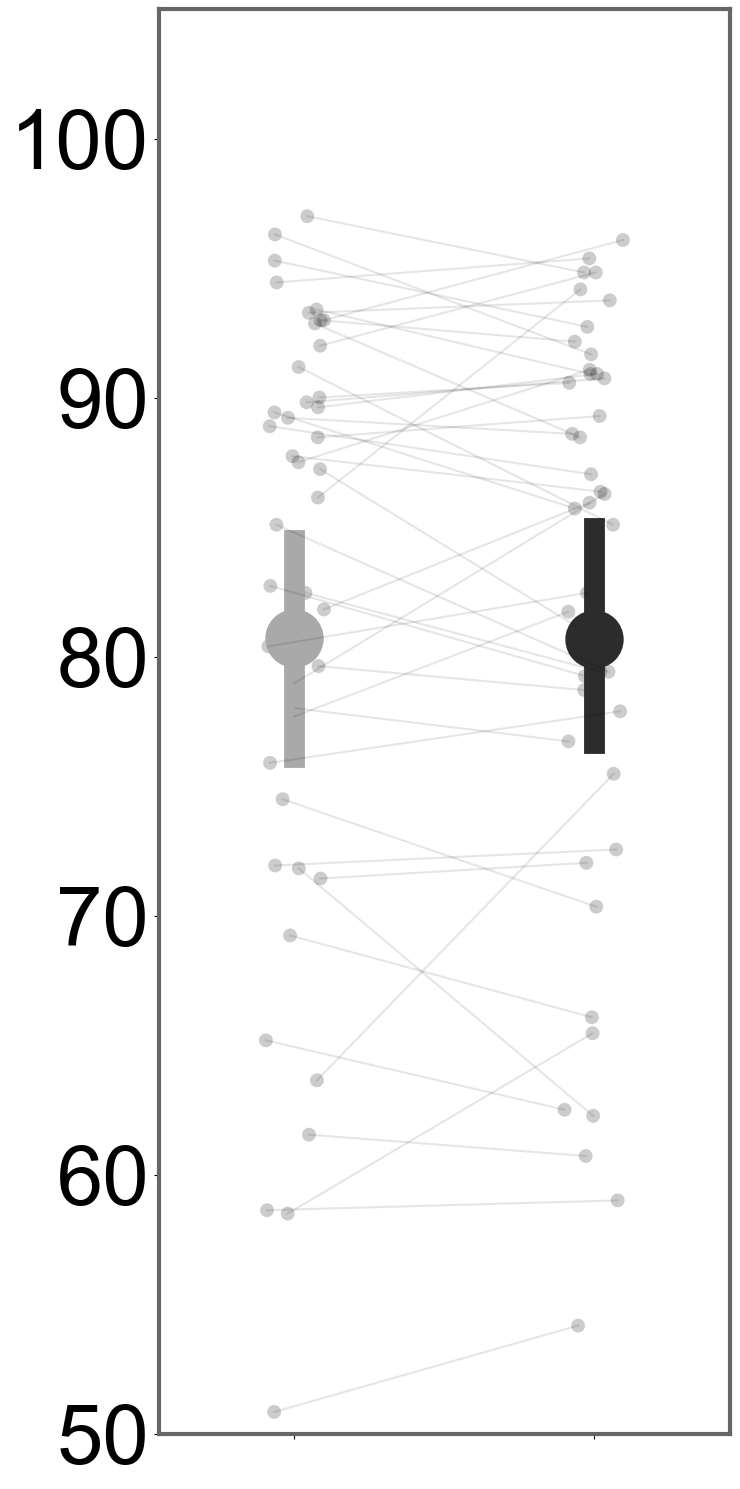

In [ ]:


fs(7.5,15)
fig,ax = plt.subplots()
sns.stripplot(
    data=memErrSubjBri, 
    y = 'correctness', x = 'cuedItemBri',
    palette=['black'], order = ['day','night'], 
    alpha=.2, legend=False,size=10, zorder = 1,
)

sns.pointplot(
    data=memErrSubjBri, 
    y = 'correctness', x = 'cuedItemBri',palette=['#a9a9a9','#2c2c2c'],
    order = ['day','night'], 
   legend=False,linestyles='none',errwidth= 15,markersize=40,
)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)

plt.ylim(50,105)

plt.tick_params(axis='y', which='major', labelsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.margins(y=0.1,x = 0.3)

plt.tight_layout()

## 

In [ ]:
psyFull.loc[psyFull['rsp'] == 'unrelatedFoil','rsp'] = 'unrelateItemFoil'
psyFull.loc[psyFull['rsp'] == 'unrelateItemFoil','rsp'] = 'unrelatedItem'
psyFull.loc[psyFull['rsp'] == 'uncuedFoil','rsp'] = 'uncuedItemFoil'
psyFull.loc[psyFull['rsp'] == 'distractor','rsp'] = 'unrelatedItem'
psyFull.loc[psyFull['rsp'] == 'distractorFoil','rsp'] = 'unrelatedItem'

In [ ]:
errTypes = ['cuedItemFoil','uncuedItem','unrelatedItem','uncuedItemFoil']

In [ ]:
df = psyFull[(psyFull.correctness == 0) & (psyFull.distractorType == 'noDistractor')][['participant','trlType',
                                                'rsp','correctness']]
errSubtype = df.groupby(['participant','trlType','rsp'], as_index=False).size()


all_combinations = pd.MultiIndex.from_product([df['participant'].unique(), df['trlType'].unique(),errTypes], names=['participant', 'trlType','rsp'])
errSubtype = errSubtype.set_index(['participant', 'trlType','rsp']).reindex(all_combinations, fill_value=0).reset_index()

qq = df.groupby(['participant','trlType']).size().reset_index()
errSubtype = errSubtype.merge(qq, how='left')
errSubtype.rename(columns={0:'thisSubCondErr'},inplace=True)
errSubtype['perc'] = errSubtype['size']*100/errSubtype.thisSubCondErr

In [ ]:
errSubtype

participant trlType             rsp  size  thisSubCondErr       perc
0          249.0  visual    cuedItemFoil     6               8  75.000000
1          249.0  visual      uncuedItem     0               8   0.000000
2          249.0  visual   unrelatedItem     0               8   0.000000
3          249.0  visual  uncuedItemFoil     1               8  12.500000
4          249.0  verbal    cuedItemFoil     1               5  20.000000
..           ...     ...             ...   ...             ...        ...
347        296.0  visual  uncuedItemFoil     1              28   3.571429
348        296.0  verbal    cuedItemFoil     2              14  14.285714
349        296.0  verbal      uncuedItem     7              14  50.000000
350        296.0  verbal   unrelatedItem     2              14  14.285714
351        296.0  verbal  uncuedItemFoil     0              14   0.000000

[352 rows x 6 columns]

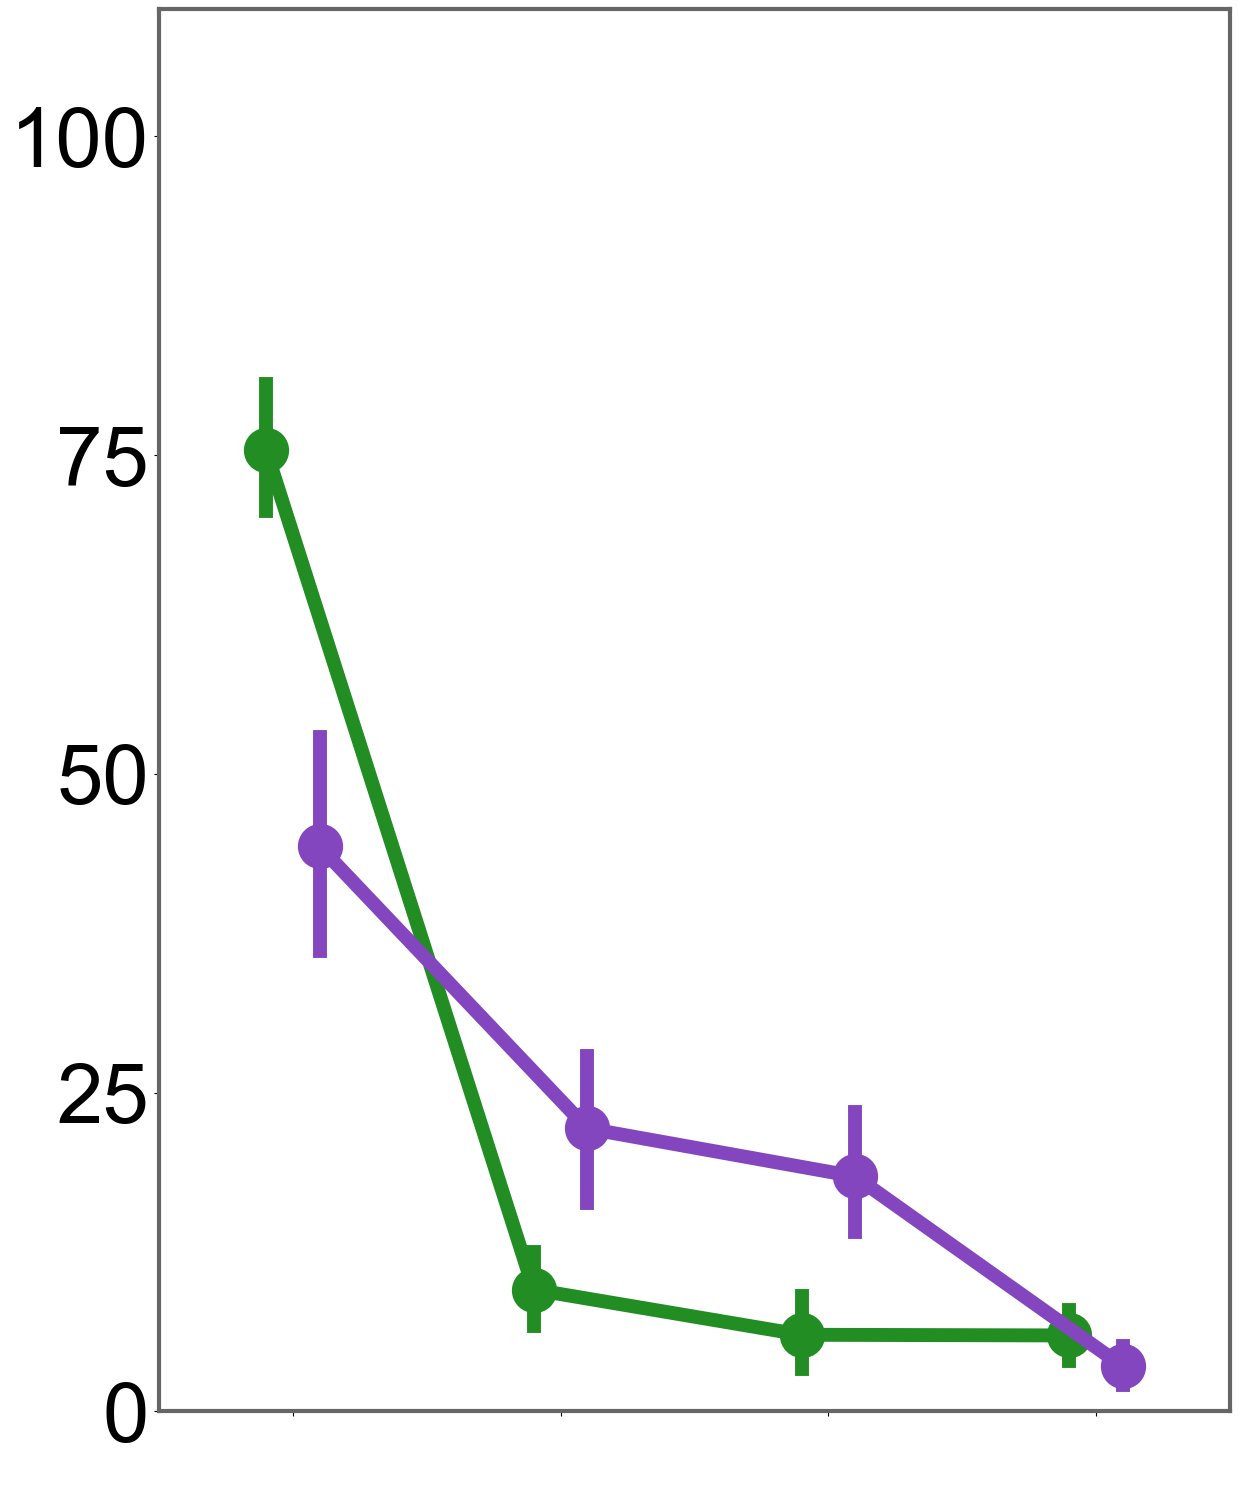

In [ ]:
fig, ax = plt.subplots(figsize = (12.5,15))
sns.pointplot(
    data = errSubtype.reset_index(), dodge = 0.2,linewidth = 10,legend=False,
    x = 'rsp', y = 'perc', order= ['cuedItemFoil','uncuedItem','unrelatedItem','uncuedItemFoil'],
    hue = 'trlType', hue_order=['visual','verbal'], palette=["#8446be","#218d23"][::-1],
)
plt.xticks(rotation = 30);
plt.ylim(0,110)
plt.tick_params(axis='y', which='major', labelsize=60)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(25))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
plt.tight_layout()

In [ ]:
testItems = ['cuedItemFoil','uncuedItem','unrelatedItem','uncuedItemFoil',]
for testItem in testItems:

    print(
        f'{testItem},\n',
        stats.ttest_rel(errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'visual')].reset_index(drop=True)['perc'],
                        errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'verbal')].reset_index(drop=True)['perc'], nan_policy='omit'),
        '\n cohen d',
        round(cohenD(errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'visual')]['perc'],
                        errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'verbal')]['perc']),2),
        '\n'
                            )

cuedItemFoil,
 TtestResult(statistic=6.717996065215377, pvalue=3.299814449652418e-08, df=43) 
 cohen d 1.29 

uncuedItem,
 TtestResult(statistic=-3.8305251625982524, pvalue=0.0004109083300422206, df=43) 
 cohen d -0.79 

unrelatedItem,
 TtestResult(statistic=-4.461080135382149, pvalue=5.7822153898434195e-05, df=43) 
 cohen d -0.91 

uncuedItemFoil,
 TtestResult(statistic=1.9626914768146255, pvalue=0.05617268932112574, df=43) 
 cohen d 0.38 



In [ ]:
errSubtype = psyFull[(psyFull.correctness == 0) & (psyFull.distractorType == 'noDistractor')][['participant','trlType',
                                                'rsp','correctness']].groupby(['participant','trlType','rsp']).size()
errSubtype = errSubtype.reset_index()
errSubtype['count'] = errSubtype[0]
errSubtypePivot = errSubtype.pivot(index = ['participant','trlType'],columns=['rsp'],values='count').fillna(0)
errSubtype = errSubtypePivot.reset_index().melt(id_vars=['participant','trlType'],\
                                   value_vars=['cuedItemFoil','uncuedItem','uncuedItemFoil', 'unrelatedItem'],value_name='count')

errSubtype.loc[len(errSubtype)] = {'participant':284.0,'trlType':'verbal','rsp':'cuedItemFoil','count':0}
errSubtype.loc[len(errSubtype)] = {'participant':284.0,'trlType':'verbal','rsp':'uncuedItem','count':0}
errSubtype.loc[len(errSubtype)] = {'participant':284.0,'trlType':'verbal','rsp':'unrelatedItem','count':0}
errSubtype.loc[len(errSubtype)] = {'participant':284.0,'trlType':'verbal','rsp':'uncuedItemFoil','count':0}

In [ ]:
fs(7.5,15)


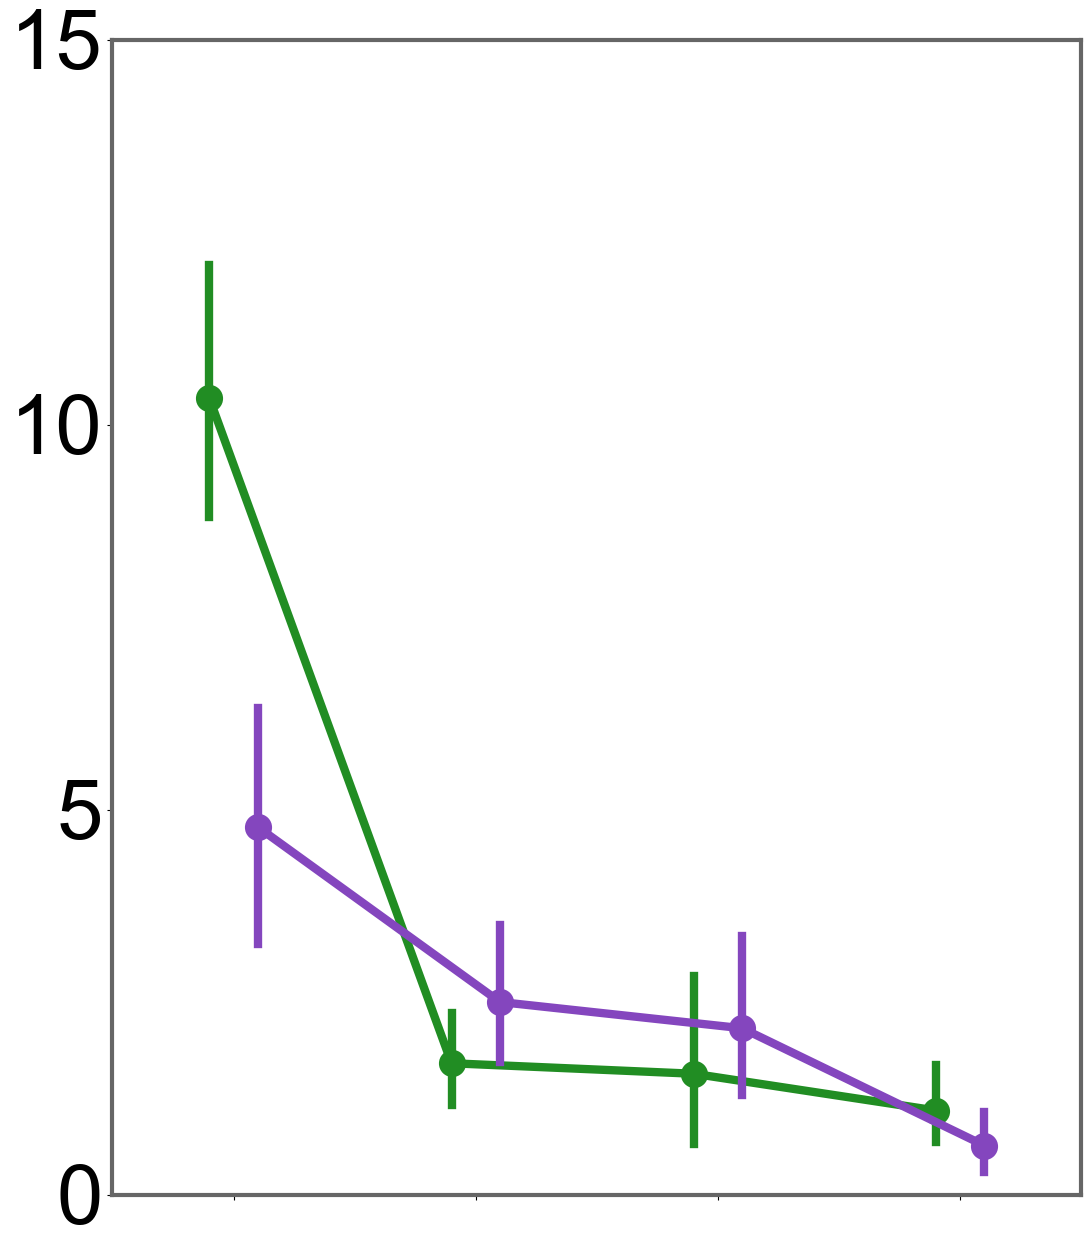

In [ ]:
fig, ax = plt.subplots(figsize = (12.5,15))
sns.pointplot(
    data = errSubtype.reset_index(), dodge = 0.2,linewidth = 6,legend=False,
    x = 'rsp', y = 'count', order= ['cuedItemFoil','uncuedItem','unrelatedItem','uncuedItemFoil'],
    hue = 'trlType', hue_order=['visual','verbal'], palette=["#8446be","#218d23"][::-1],
)
#plt.xticks(rotation = 30);
plt.ylim(0,15)
plt.tick_params(axis='y', which='major', labelsize=60)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')

plt.xticks(c = 'white');

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)


In [ ]:
testItems = ['cuedItemFoil','uncuedItem','unrelatedItem','uncuedItemFoil',]
for testItem in testItems:

    print(
        f'{testItem},\n',
        stats.ttest_rel(errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'visual')].reset_index(drop=True)['count'],
                        errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'verbal')].reset_index(drop=True)['count'], nan_policy='omit'),
        '\n cohen d',
        round(cohenD(errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'visual')]['count'],
                        errSubtype[(errSubtype.rsp == testItem) & (errSubtype.trlType == 'verbal')]['count']),2),
        '\n'
                            )

cuedItemFoil,
 TtestResult(statistic=5.549448186755389, pvalue=1.646901415275507e-06, df=43) 
 cohen d 0.95 

uncuedItem,
 TtestResult(statistic=-2.3698671674378105, pvalue=0.022351553524687883, df=43) 
 cohen d -0.3 

unrelatedItem,
 TtestResult(statistic=-2.320981106932973, pvalue=0.025096625468338463, df=43) 
 cohen d -0.16 

uncuedItemFoil,
 TtestResult(statistic=2.3155120405592933, pvalue=0.02542180244201687, df=43) 
 cohen d 0.28 



# pupil

NameError: name 'events' is not defined

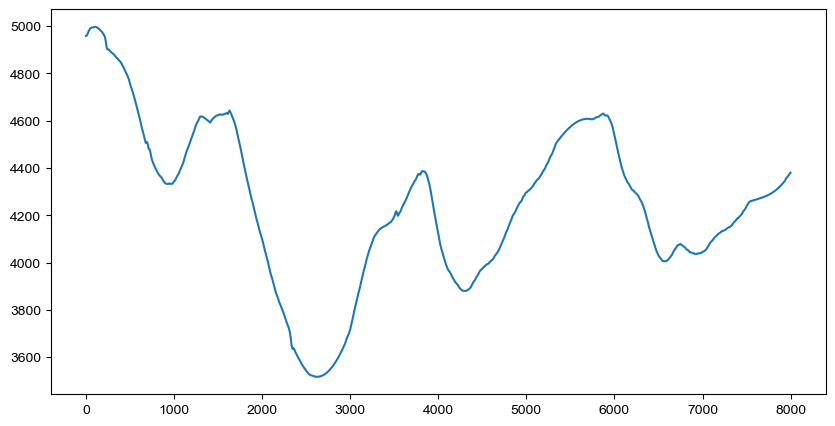

In [53]:
fs(10,5)
eg = np.random.randint(pupClean.shape[0])
plt.plot(pupClean.iloc[eg,1:].values)
plt.vlines(np.cumsum(list(events.values())),min(pupClean.iloc[eg,1:].values),
           max(pupClean.iloc[eg,1:].values),linestyles='dashed',color = 'black')

In [54]:
pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)
pupNorm.insert(0,'TRIALID',pupClean.TRIALID)

In [55]:
pupNorm = pupNorm[~(pupNorm.iloc[:,1:3501].isnull().sum(axis =1) > 350)]
pupNorm = pupNorm.merge(psyFull[['participant','trlType','TRIALID','cuedItemBri',]],how = 'inner')
pupNorm = pupNorm[~pupNorm.participant.isin(rejSubj)]

In [56]:
pupNorm.participant.value_counts()

participant
260.0    216
286.0    215
280.0    215
281.0    215
251.0    215
252.0    215
287.0    214
259.0    214
290.0    214
294.0    213
282.0    213
291.0    212
261.0    212
255.0    212
293.0    212
249.0    212
257.0    211
275.0    211
296.0    211
283.0    210
279.0    210
266.0    210
289.0    209
264.0    208
295.0    207
274.0    207
276.0    206
268.0    204
278.0    202
269.0    200
253.0    196
265.0    193
262.0    190
258.0    188
272.0    188
256.0    187
292.0    187
273.0    186
267.0    181
270.0    180
263.0    177
284.0    172
271.0    171
288.0    149
Name: count, dtype: int64

In [57]:
pupNorm.shape[0]/(pupNorm.participant.nunique()*216)

0.9332912457912458

In [58]:
216*0.6

129.6

In [59]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']
labelList = ['verbal_day','verbal_night','visual_day','visual_night']

In [61]:
"""
perms = 5000
dataN = 35
fCluster_vis = np.zeros(perms) 
fCluster_ver = np.zeros(perms)

a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)

dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)


for n in range(perms):
    print(n)
    
    # shuffle condition label
    dsPup_visual['randLabel'] = np.random.permutation(dsPup_visual['cuedItemBri'].values)
    pseudoBri = dsPup_visual[dsPup_visual.randLabel == 'day'].iloc[:,:dataN]
    pseudoDar = dsPup_visual[dsPup_visual.randLabel == 'night'].iloc[:,:dataN]
    
    # calcualte the permutated statistic (e.g. F values, t values) and p values
    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],
                                    nan_policy='omit',) [:2] for i in range(dataN)])
    
    statArr = tp[:,0]
    pArr = tp[:,1]
    
    # find the clusters that exceed p value threshold
    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

    # find the cluster with the largest length,then find its corresponding t values, sum it up
            #note: if no cluster is found, this will return 0
    fCluster_vis[n] =  np.round(statArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)




for n in range(perms):
    print(n)
    
    # shuffle condition label
    dsPup_verbal['randLabel'] = np.random.permutation(dsPup_verbal['cuedItemBri'].values)
    pseudoBri = dsPup_verbal[dsPup_verbal.randLabel == 'day'].iloc[:,:dataN]
    pseudoDar = dsPup_verbal[dsPup_verbal.randLabel == 'night'].iloc[:,:dataN]
    
    # calcualte the permutated statistic (e.g. F values, t values) and p values
    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],
                                    nan_policy='omit',) [:2] for i in range(dataN)])
    
    statArr = tp[:,0]
    pArr = tp[:,1]
    
    # find the clusters that exceed p value threshold
    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

    # find the cluster with the largest length,then find its corresponding t values, sum it up
            #note: if no cluster is found, this will return 0
    fCluster_ver[n] =  np.round(statArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)


"""

"\nperms = 5000\ndataN = 35\nfCluster_vis = np.zeros(perms) \nfCluster_ver = np.zeros(perms)\n\na = pupNorm.iloc[:,1:3501]\na.columns = range(a.shape[1])\na = a.groupby(a.columns // 100, axis=1).mean()\ndsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)\n\ndsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)\ndsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)\n\n\nfor n in range(perms):\n    print(n)\n    \n    # shuffle condition label\n    dsPup_visual['randLabel'] = np.random.permutation(dsPup_visual['cuedItemBri'].values)\n    pseudoBri = dsPup_visual[dsPup_visual.randLabel == 'day'].iloc[:,:dataN]\n    pseudoDar = dsPup_visual[dsPup_visual.randLabel == 'night'].iloc[:,:dataN]\n    \n    # calcualte the permutated statistic (e.g. F values, t values) and p values\n    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],\n                                    nan_policy='omit',) [:2] for i in range(dataN)])\n    \

In [62]:
#np.save('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_visual5000.npy',fCluster_vis,)
#np.save('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_verbal5000.npy',fCluster_ver,)

In [63]:
dataN = 35
perms = 5000


In [64]:
a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)

dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)



In [65]:
fCluster_vis = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_visual5000.npy')
fCluster_ver = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_verbal5000.npy')


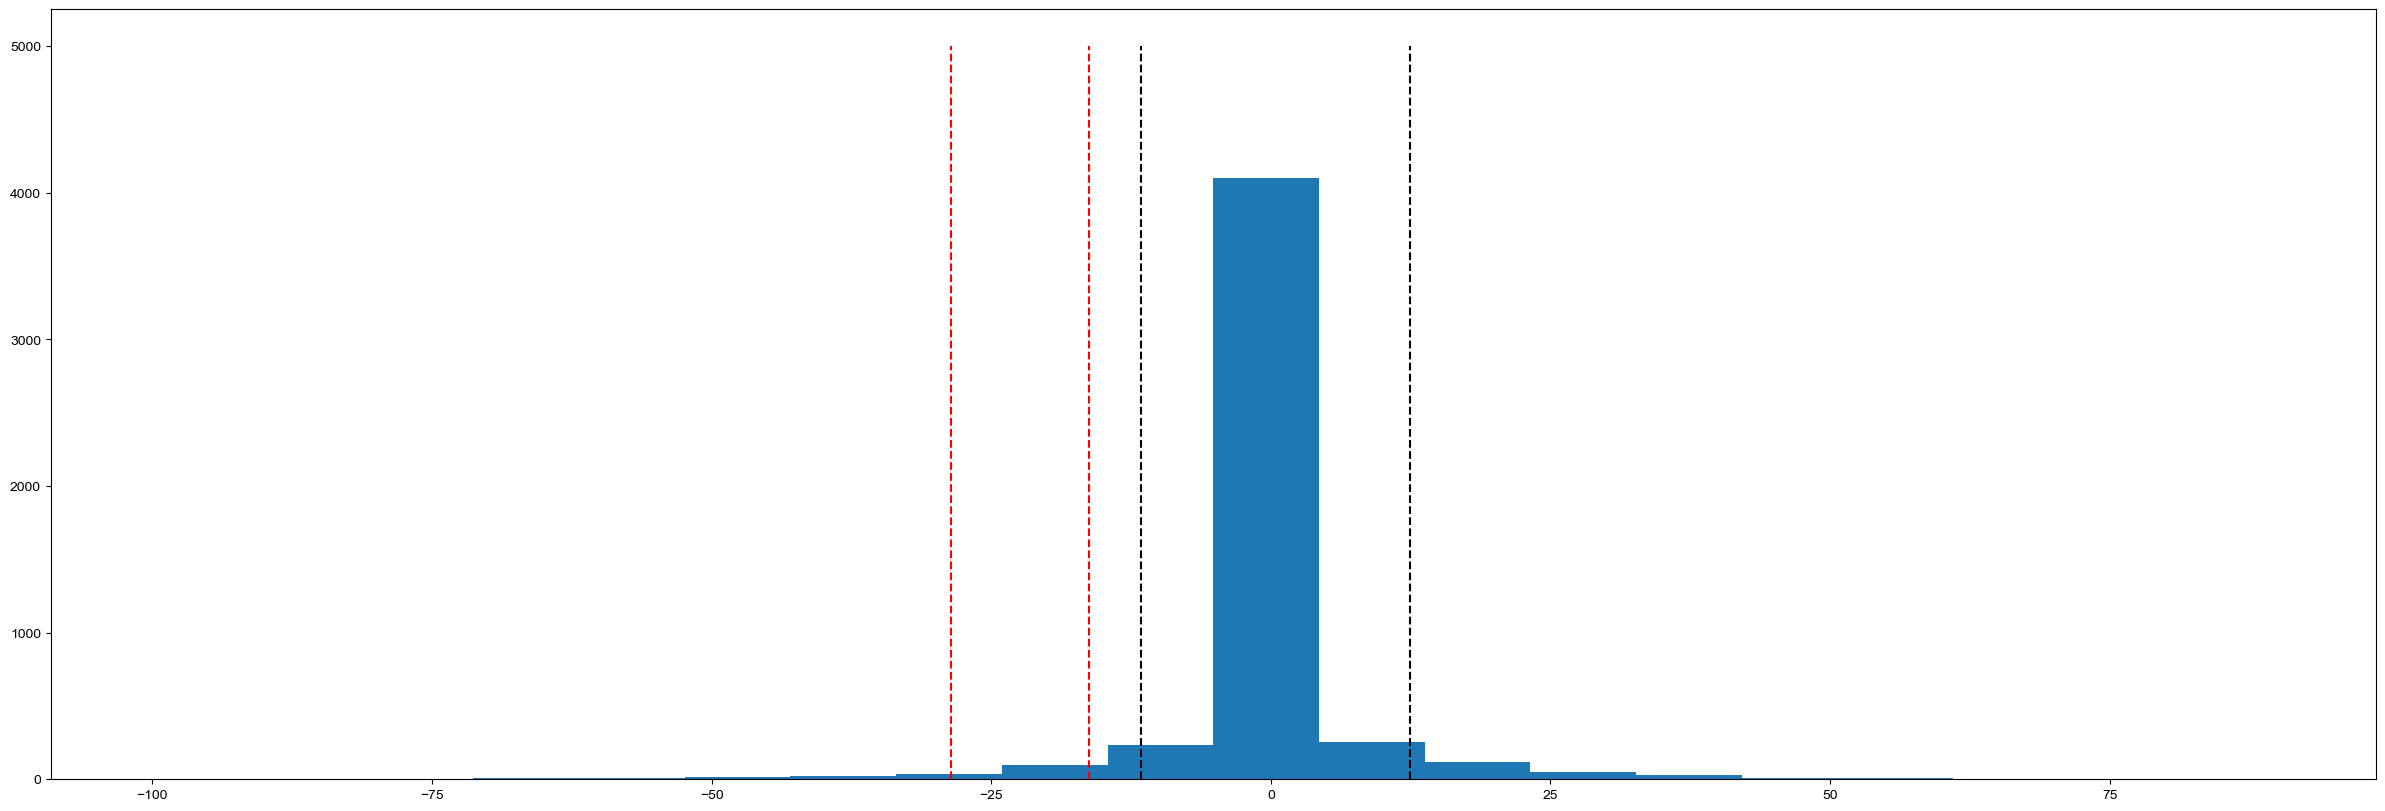

In [136]:
realBri = dsPup_visual[dsPup_visual.cuedItemBri == 'day'].iloc[:,:dataN]
realDar = dsPup_visual[dsPup_visual.cuedItemBri == 'night'].iloc[:,:dataN]
    
# calcualte the permutated statistic (e.g. F values, t values) and p values
tp = np.array([stats.ttest_ind(realBri.iloc[:,i],realDar.iloc[:,i],
                                nan_policy='omit',) [:2] for i in range(dataN)])

statArr = tp[:,0]
pArr = tp[:,1]

# find the clusters that exceed p value threshold
consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

#get the p value for each cluster
fsum_vis = [statArr[i].sum() for i in consGroups]
pValue_vis = [sum(fCluster_vis > i)/perms for i in fsum_vis]



plt.hist(fCluster_vis,bins = 20)
plt.vlines(np.percentile(fCluster_vis,95),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster_vis,5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum_vis],0,perms,linestyles = 'dashed',color ='r')



In [137]:
consGroups,pValue_vis

([array([11, 12, 13, 14, 15, 16, 17], dtype=int64),
  array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34], dtype=int64)],
 [0.9674, 0.984])

In [138]:
pArr

array([0.46567035, 0.6043359 , 0.83785828, 0.98166642, 0.93549215,
       0.75324722, 0.57029045, 0.43660611, 0.33944713, 0.21982039,
       0.09717795, 0.04786192, 0.02400873, 0.01166178, 0.01048086,
       0.0144861 , 0.02010393, 0.03393119, 0.05527115, 0.10365458,
       0.1121777 , 0.09249782, 0.0767082 , 0.05627396, 0.05460249,
       0.04207075, 0.02266448, 0.00788388, 0.00267772, 0.00167279,
       0.00188632, 0.00209934, 0.00161746, 0.00180149, 0.00291021])

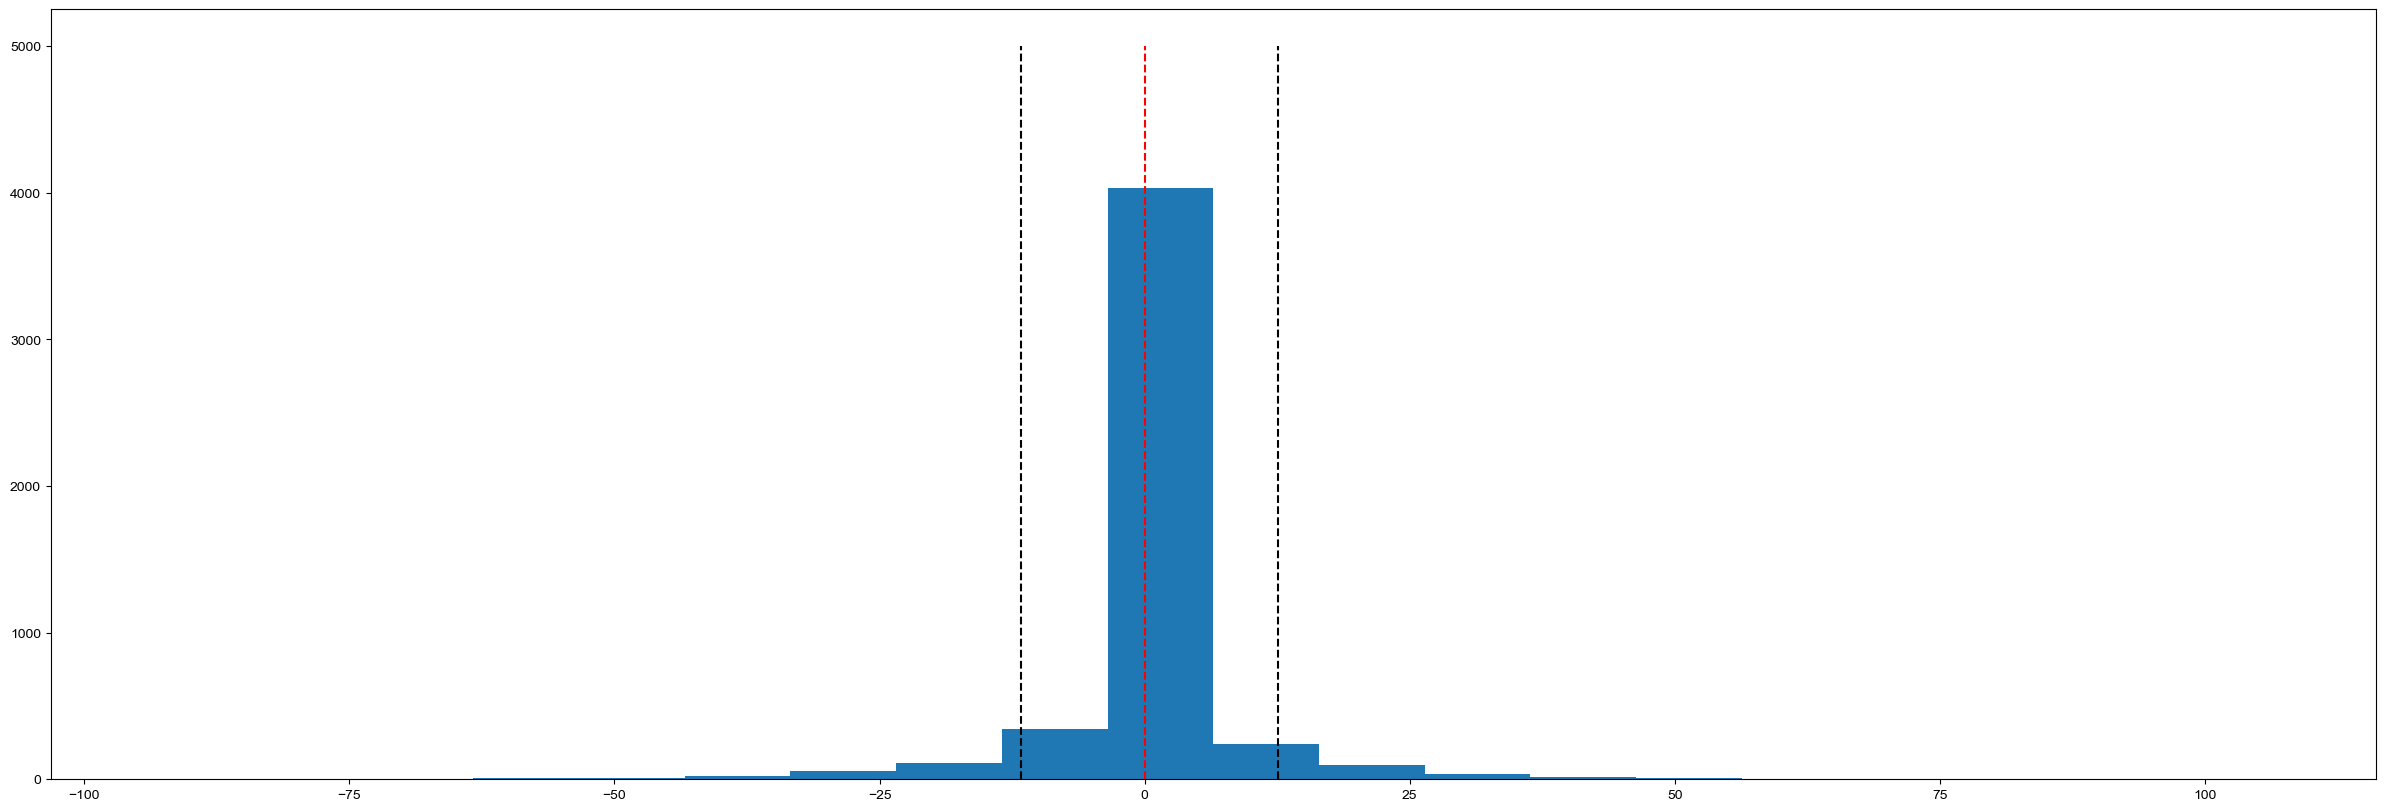

In [139]:
realBri = dsPup_verbal[dsPup_verbal.cuedItemBri == 'day'].iloc[:,:dataN]
realDar = dsPup_verbal[dsPup_verbal.cuedItemBri == 'night'].iloc[:,:dataN]
    
# calcualte the permutated statistic (e.g. F values, t values) and p values
tp = np.array([stats.ttest_ind(realBri.iloc[:,i],realDar.iloc[:,i],
                                nan_policy='omit',) [:2] for i in range(dataN)])

statArr = tp[:,0]
pArr = tp[:,1]

# find the clusters that exceed p value threshold
consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

#get the p value for each cluster
fsum_ver = [statArr[i].sum() for i in consGroups]
pValue_ver = [sum(fCluster_ver > i)/perms for i in fsum_ver]



plt.hist(fCluster_ver,bins = 20)
plt.vlines(np.percentile(fCluster_ver,95),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster_ver,5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum_ver],0,perms,linestyles = 'dashed',color ='r')



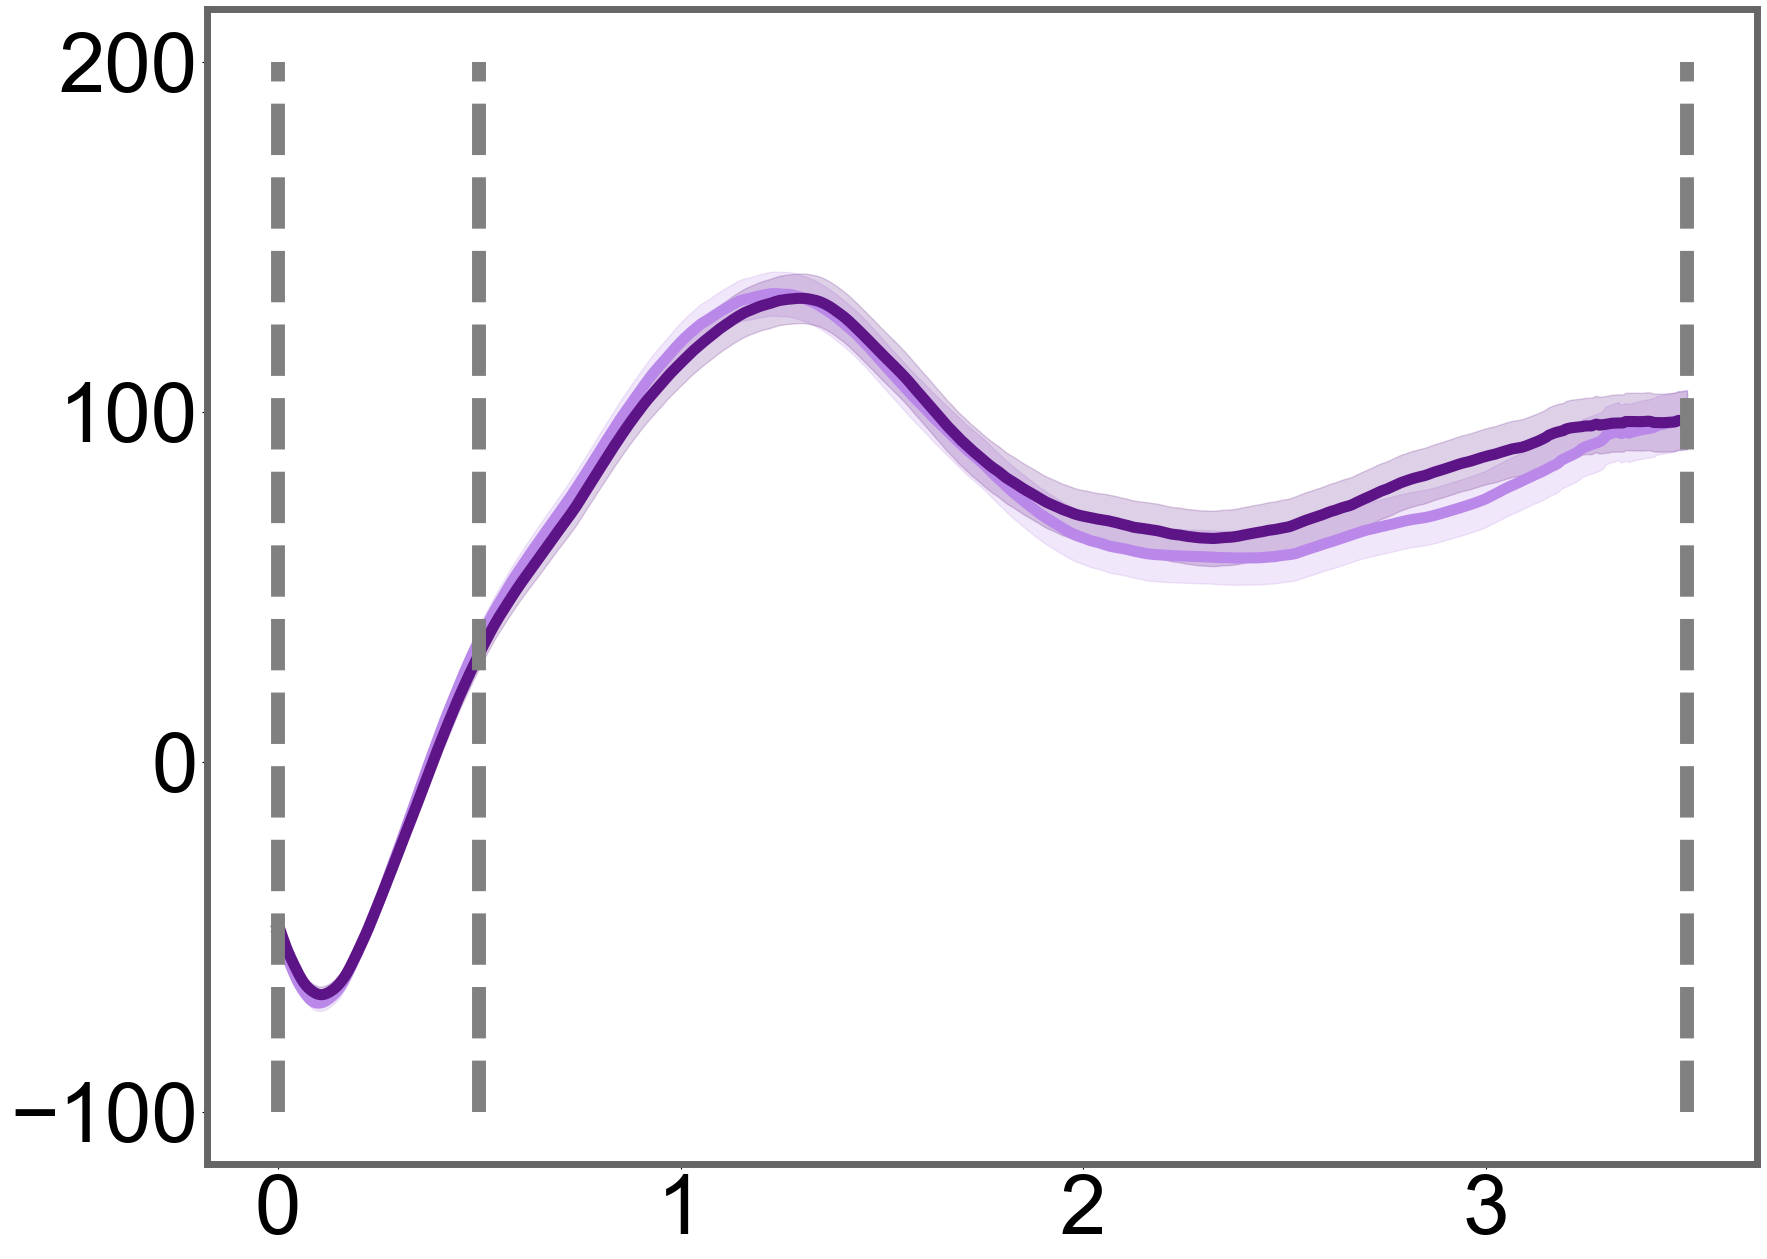

In [140]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [141]:
cList

['#ba88e9', '#5c1486', '#60d062', '#1e681f']

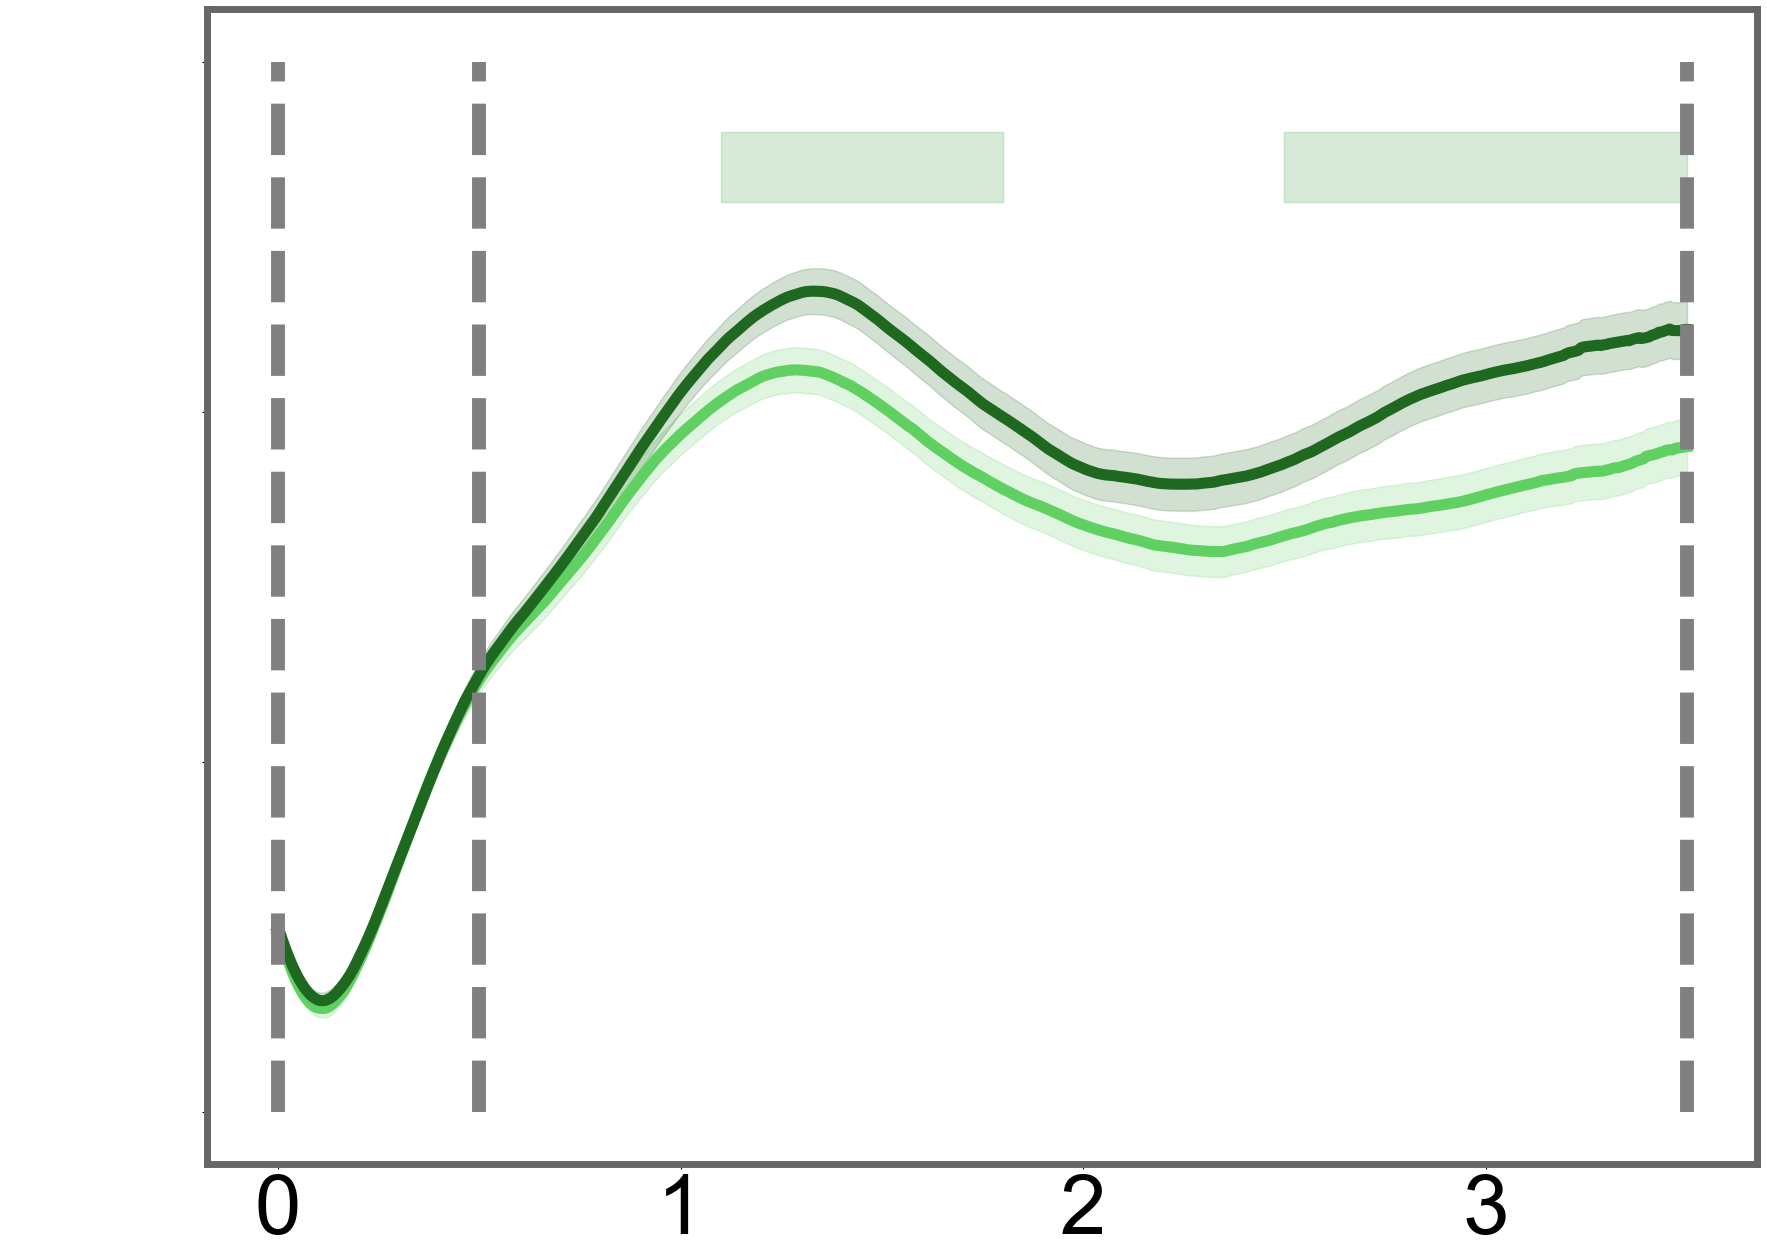

In [142]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
plt.fill_between([1.1,1.8],160,180,color = "#359937",alpha = 0.2)
plt.fill_between([2.5,3.5],160,180,color = '#359937',alpha = 0.2)


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

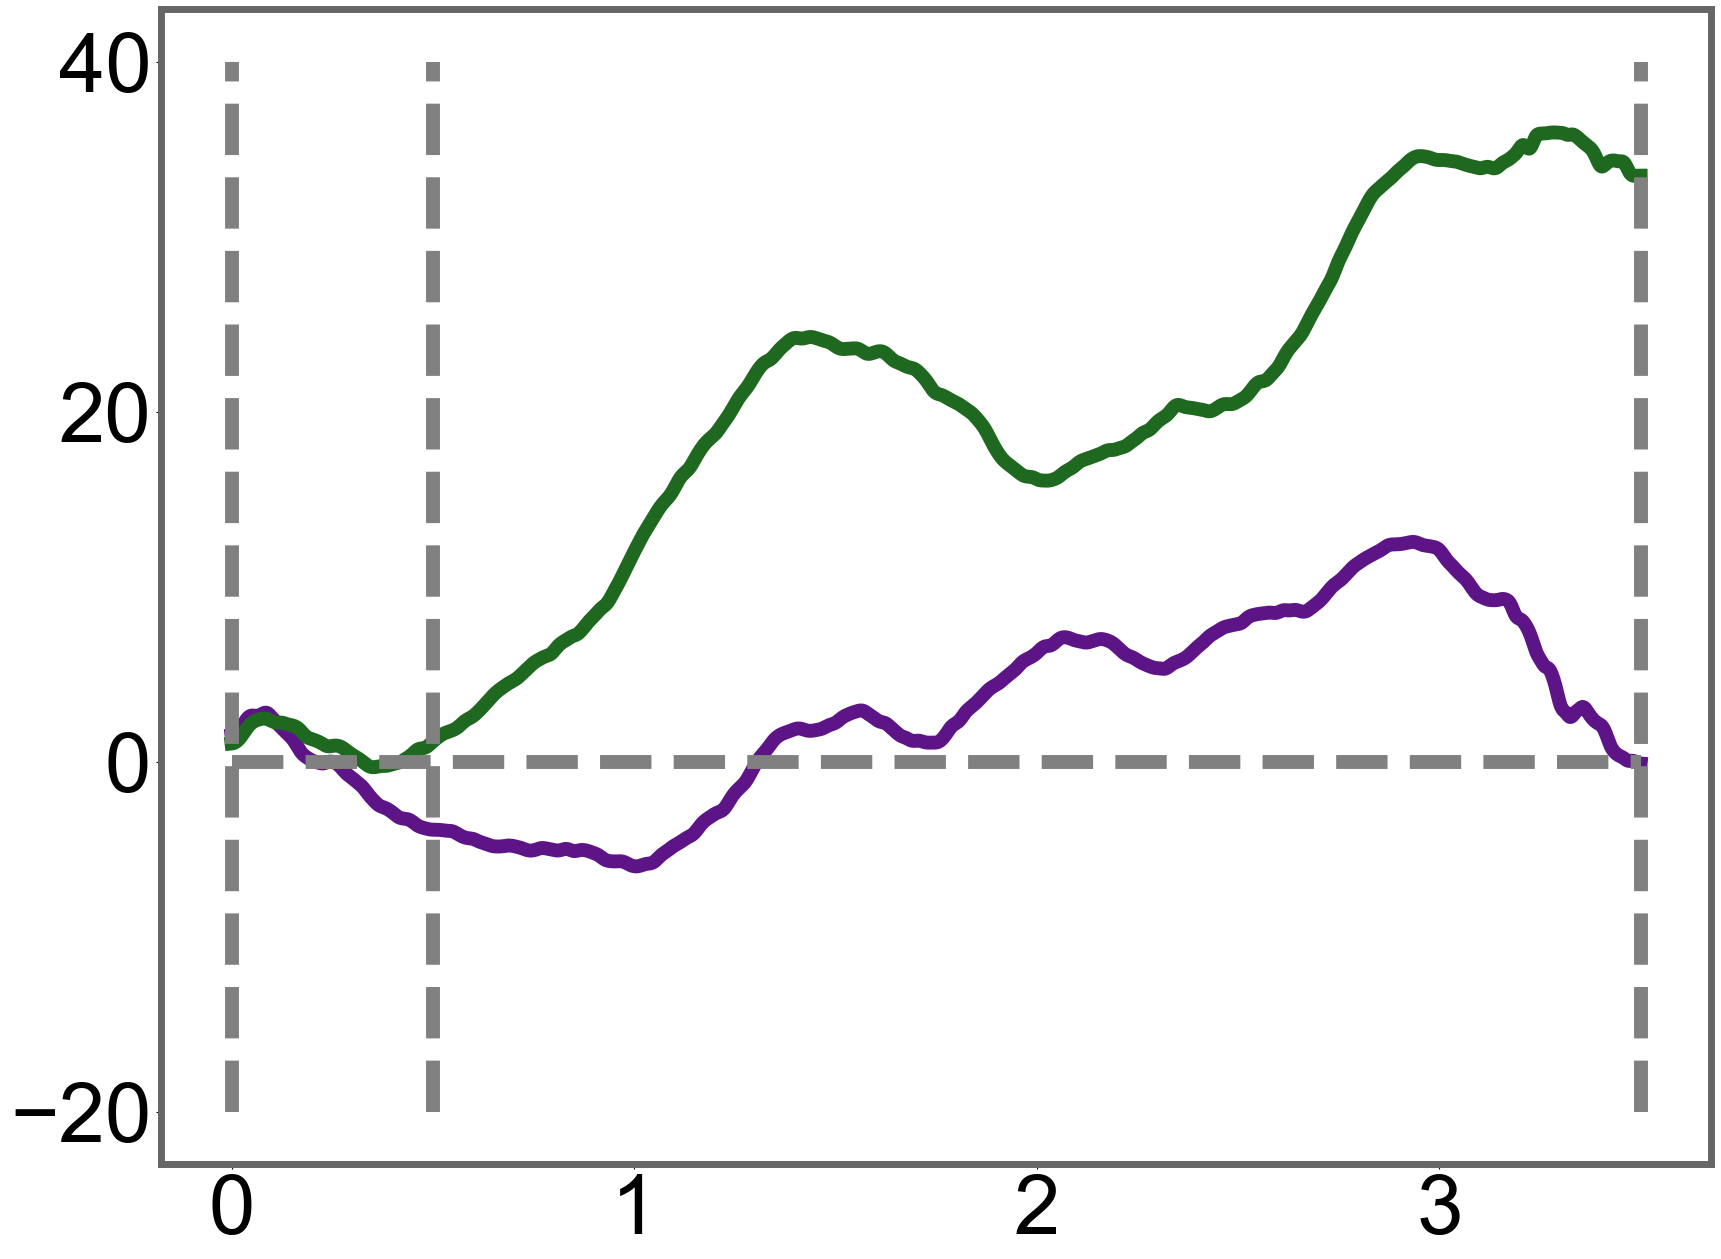

In [143]:
fig,ax = plt.subplots()
for n,f in enumerate(pupMean.index.get_level_values('trlType').unique()):
    diff = pupMean.loc[f,'night'] - pupMean.loc[f,'day']
    plt.plot(x,smooth(diff[:lenData],31),color = cList[1::2][n],label = f,linewidth = 10)

plt.vlines([0,0.5,3.5],-20,40,colors='grey',linestyles='dashed',linewidth = 10)
plt.hlines(0,0,3.5,colors='grey',linestyles='dashed',linewidth = 10)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.yticks(fontsize=60,c = 'black')
plt.xticks(fontsize=60)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [144]:
# no condition

In [145]:
perms = 5000
dataN = 35
fCluster = np.zeros(perms) 

a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['cuedItemBri']]],axis = 1)

"""
for n in range(perms):
    print(n)
    
    # shuffle condition label
    dsPup['randLabel'] = np.random.permutation(dsPup['cuedItemBri'].values)
    pseudoBri = dsPup[dsPup.randLabel == 'day'].iloc[:,:dataN]
    pseudoDar = dsPup[dsPup.randLabel == 'night'].iloc[:,:dataN]
    
    # calcualte the permutated statistic (e.g. F values, t values) and p values
    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],
                                    nan_policy='omit',) [:2] for i in range(dataN)])
    
    statArr = tp[:,0]
    pArr = tp[:,1]
    
    # find the clusters that exceed p value threshold
    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

    # find the cluster with the largest length,then find its corresponding t values, sum it up
            #note: if no cluster is found, this will return 0
    fCluster[n] =  np.round(statArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)



"""

"\nfor n in range(perms):\n    print(n)\n    \n    # shuffle condition label\n    dsPup['randLabel'] = np.random.permutation(dsPup['cuedItemBri'].values)\n    pseudoBri = dsPup[dsPup.randLabel == 'day'].iloc[:,:dataN]\n    pseudoDar = dsPup[dsPup.randLabel == 'night'].iloc[:,:dataN]\n    \n    # calcualte the permutated statistic (e.g. F values, t values) and p values\n    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],\n                                    nan_policy='omit',) [:2] for i in range(dataN)])\n    \n    statArr = tp[:,0]\n    pArr = tp[:,1]\n    \n    # find the clusters that exceed p value threshold\n    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)\n\n    # find the cluster with the largest length,then find its corresponding t values, sum it up\n            #note: if no cluster is found, this will return 0\n    fCluster[n] =  np.round(statArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)\n

In [146]:
#np.save('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_combinedCondition5000.npy',fCluster,)

In [147]:
fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_combinedCondition5000.npy')


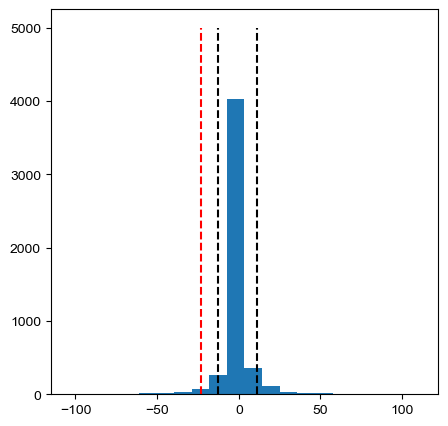

In [148]:
fs(5,5)
realBri = dsPup[dsPup.cuedItemBri == 'day'].iloc[:,:dataN]
realDar = dsPup[dsPup.cuedItemBri == 'night'].iloc[:,:dataN]
    
# calcualte the permutated statistic (e.g. F values, t values) and p values
tp = np.array([stats.ttest_ind(realBri.iloc[:,i],realDar.iloc[:,i],
                                nan_policy='omit',) [:2] for i in range(dataN)])

statArr = tp[:,0]
pArr = tp[:,1]

# find the clusters that exceed p value threshold
consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

#get the p value for each cluster
fsum = [statArr[i].sum() for i in consGroups]
pValue = [sum(fCluster > i)/perms for i in fsum]



plt.hist(fCluster,bins = 20)
plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r')



In [149]:
consGroups,pValue

([array([26, 27, 28, 29, 30, 31, 32, 33, 34], dtype=int64)], [0.9768])

In [150]:
1-0.9768

0.0232

In [66]:
pupMean = pupNorm.groupby(['cuedItemBri']).mean(numeric_only=True)
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

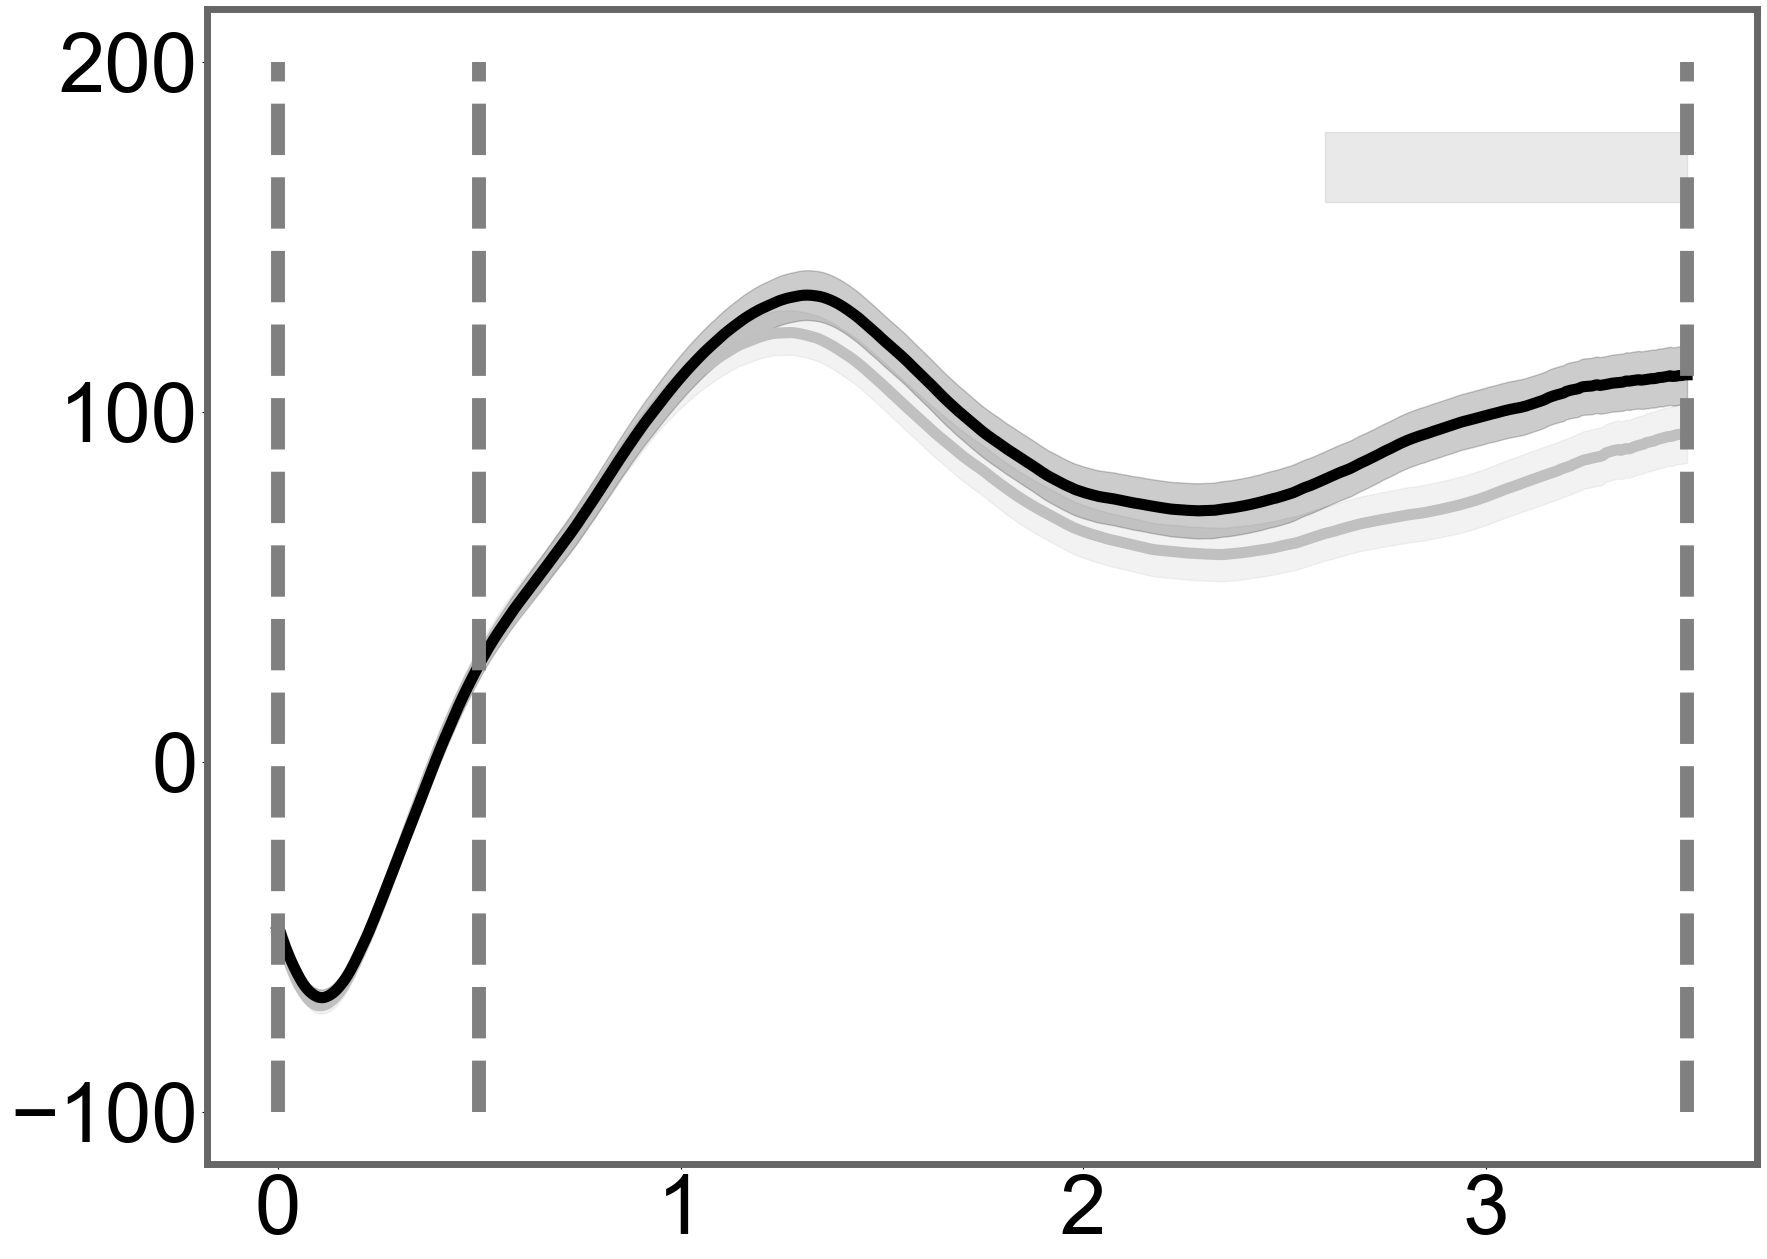

In [67]:
fs(20,15)
fig,ax = plt.subplots()

[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.fill_between([2.6,3.5],160,180,color = "#949494",alpha = 0.2)

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


In [153]:
pupNorm.participant.nunique()

44

In [154]:
pupNormMean = pupNorm.iloc[:,-3:]

In [155]:
pupNormMean['meanPup'] = pupNorm.iloc[:,np.r_[1101:1801,2501:3501,]].mean(axis = 1)

In [156]:
pupSubj = pupNormMean.groupby(['participant','trlType','cuedItemBri']).mean()

In [157]:
pg.rm_anova(data=pupSubj.reset_index(), dv = 'meanPup',subject='participant',within=['trlType','cuedItemBri'])

Source            SS  ddof1  ddof2            MS         F  \
0                trlType    561.941109      1     43    561.941109  0.259577   
1            cuedItemBri  12382.077700      1     43  12382.077700  6.128415   
2  trlType * cuedItemBri   5333.977858      1     43   5333.977858  2.209417   

      p-unc  p-GG-corr       ng2  eps  
0  0.613016   0.613016  0.000284  1.0  
1  0.017319   0.017319  0.006225  1.0  
2  0.144467   0.144467  0.002691  1.0

In [158]:
pg.anova(data=pupNormMean, dv = 'meanPup',between=['trlType','cuedItemBri'])

Source            SS      DF             MS         F  \
0                trlType  5.129402e+04     1.0   51294.021203  0.543866   
1            cuedItemBri  5.851991e+05     1.0  585199.089572  6.204819   
2  trlType * cuedItemBri  2.817596e+05     1.0  281759.628365  2.987475   
3               Residual  8.361848e+08  8866.0   94313.650375       NaN   

      p-unc       np2  
0  0.460854  0.000061  
1  0.012758  0.000699  
2  0.083946  0.000337  
3       NaN       NaN

In [159]:
visPup = pupNormMean[pupNormMean.trlType == 'visual']
verPup = pupNormMean[pupNormMean.trlType == 'verbal']

In [160]:
print(
    'day vs night, accuracy',
    stats.ttest_ind(visPup[visPup.cuedItemBri == 'day'].meanPup,
                    visPup[visPup.cuedItemBri == 'night'].meanPup, nan_policy='omit'),
    '\ncohen d',
    round(cohenD(visPup[visPup.cuedItemBri == 'day'].meanPup,
                    visPup[visPup.cuedItemBri == 'night'].meanPup),2)

                        )

day vs night, accuracy TtestResult(statistic=-3.033069331371107, pvalue=0.0024347952106553656, df=4440.0) 
cohen d -0.09


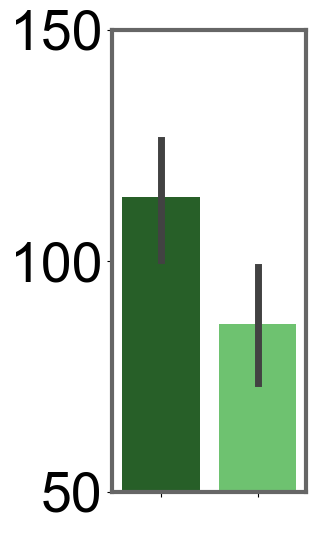

In [164]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#60d062','#1e681f',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean[pupNormMean.trlType == 'visual'])



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

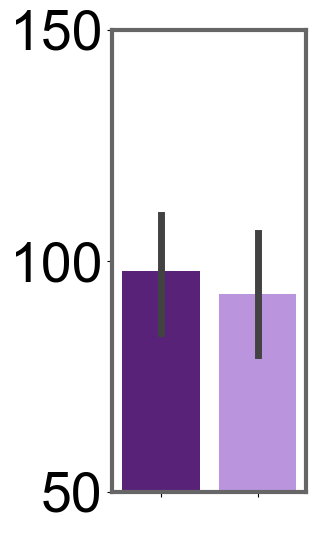

In [167]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean[pupNormMean.trlType == 'verbal'])



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

In [70]:
pupNormMean = pupNorm.iloc[:,-3:]
pupNormMean['meanPup'] = pupNorm.iloc[:,np.r_[1101:1801,2501:3501,]].mean(axis = 1)
pupSubj = pupNormMean.groupby(['participant','cuedItemBri']).mean(numeric_only=True)

In [72]:
pupNormMean

participant trlType cuedItemBri     meanPup
0           274.0  visual         day    6.304790
1           274.0  visual         day  274.153158
2           274.0  verbal       night -242.621751
3           274.0  visual       night   99.769405
4           274.0  verbal       night   32.302150
...           ...     ...         ...         ...
8865        296.0  visual       night  314.508862
8866        296.0  visual         day  593.121559
8867        296.0  visual       night  219.379692
8868        296.0  visual       night  737.610365
8869        296.0  verbal         day -506.735257

[8870 rows x 4 columns]

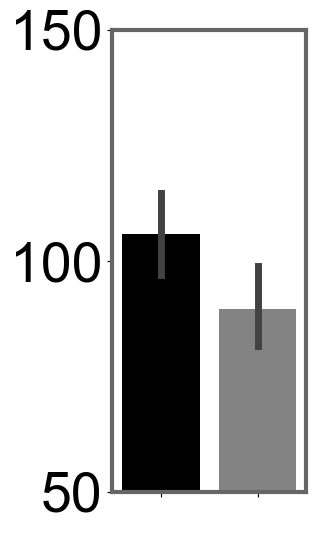

In [76]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=["#838383","#000000",],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean)



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

In [77]:
pg.rm_anova(data=pupSubj.reset_index(), dv = 'meanPup',subject='participant',within=['cuedItemBri'])

Source  ddof1  ddof2         F    p-unc      ng2  eps
0  cuedItemBri      1     43  6.555642  0.01405  0.00748  1.0

# behav.

In [169]:
noDistractorTrlsOnly = False
perms = 5000
plotfCluster = False

In [118]:
def findPupSig(pupNorm,trlIDs,fCluster):
    a = pupNorm[pupNorm.TRIALID.isin(trlIDs)].iloc[:,1:3501]
    a.columns = range(a.shape[1])
    a = a.groupby(a.columns // 100, axis=1).mean()
    dsPup = pd.concat([a,pupNorm[pupNorm.TRIALID.isin(trlIDs)][['cuedItemBri']]],axis = 1)
    realBri = dsPup[dsPup.cuedItemBri == 'day'].iloc[:,:dataN]
    realDar = dsPup[dsPup.cuedItemBri == 'night'].iloc[:,:dataN]

    # calcualte the permutated statistic (e.g. F values, t values) and p values
    tp = np.array([stats.ttest_ind(realBri.iloc[:,i],realDar.iloc[:,i],
                                    nan_policy='omit',) [:2] for i in range(dataN)])
    statArr = tp[:,0]
    pArr = tp[:,1]
    # find the clusters that exceed p value threshold
    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

    #get the p value for each cluster
    fsum = [statArr[i].sum() for i in consGroups]
    pValue = [1-(sum(fCluster > i)/perms) for i in fsum]

    return np.array(consGroups,dtype = 'object'),np.array(pValue,dtype = 'object'),fsum

In [119]:
def formatOut(consGroups,pValue):
    sigCons = consGroups[np.where(pValue<0.05)[0]]
    sigP = pValue[np.where(pValue<0.05)[0]]
    sigP = [round(i,3) for i in sigP]
    sigCons_t = [[round(i[0]/10,3),round(i[-1]/10 + 0.1,3)] for i in sigCons]
    
    return [(i,k )for i, k in zip(sigCons_t,sigP)]

In [120]:
behavTag = psyFull[['TRIALID','participant','trlType','distractorType_visVer','correctness','rt']]
if noDistractorTrlsOnly:
    behavTag = behavTag[behavTag.distractorType_visVer == 'noDistractor']
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_combinedCondition5000_corr.npy')
else:
    #load permutation
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_combinedCondition5000_corr_wDistractor.npy')


#load trls
corrTrials = behavTag[behavTag.correctness == 1].TRIALID.values
incorrTrials = behavTag[behavTag.correctness == 0].TRIALID.values
print(' - correct trial counts: ',len(corrTrials),'; incorrect counts:',len(incorrTrials))

consGroups,pValue,fsum = findPupSig(pupNorm,corrTrials,fCluster)
print('aggregated (overall) correct trial clusters: \n', formatOut(consGroups,pValue) )

if plotfCluster:
    fs(3,3)
    plt.hist(fCluster,bins = 20)
    plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r');

consGroups,pValue,fsum = findPupSig(pupNorm,incorrTrials,fCluster)
print('aggregated (overall) incorrect trial clusters: \n', formatOut(consGroups,pValue) )

 - correct trial counts:  7657 ; incorrect counts: 1835
aggregated (overall) correct trial clusters: 
 [([2.6, 3.3], 0.033)]
aggregated (overall) incorrect trial clusters: 
 []


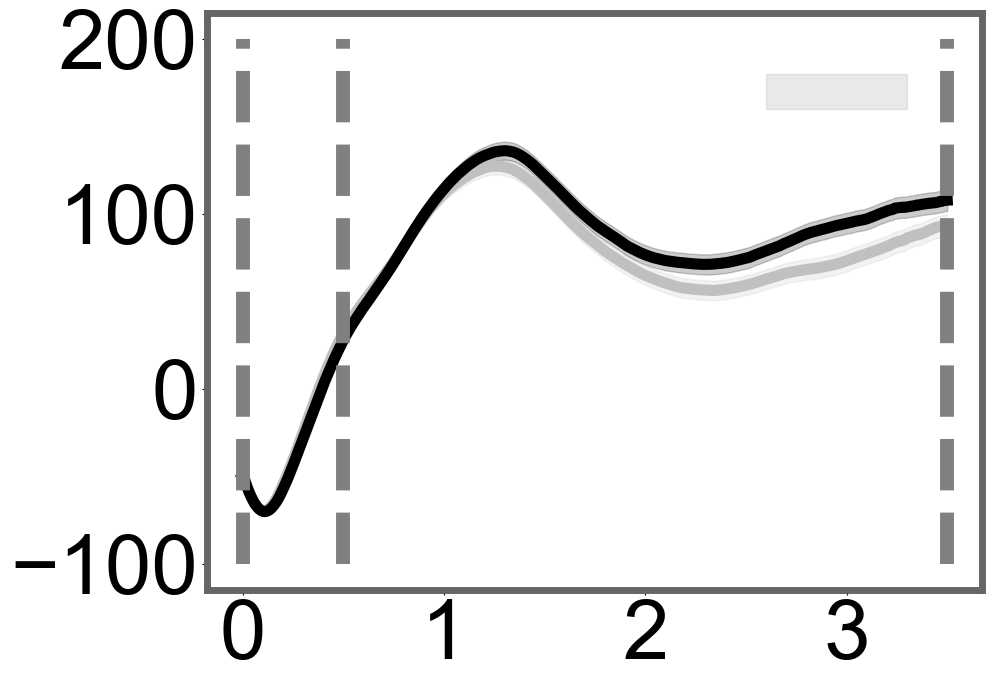

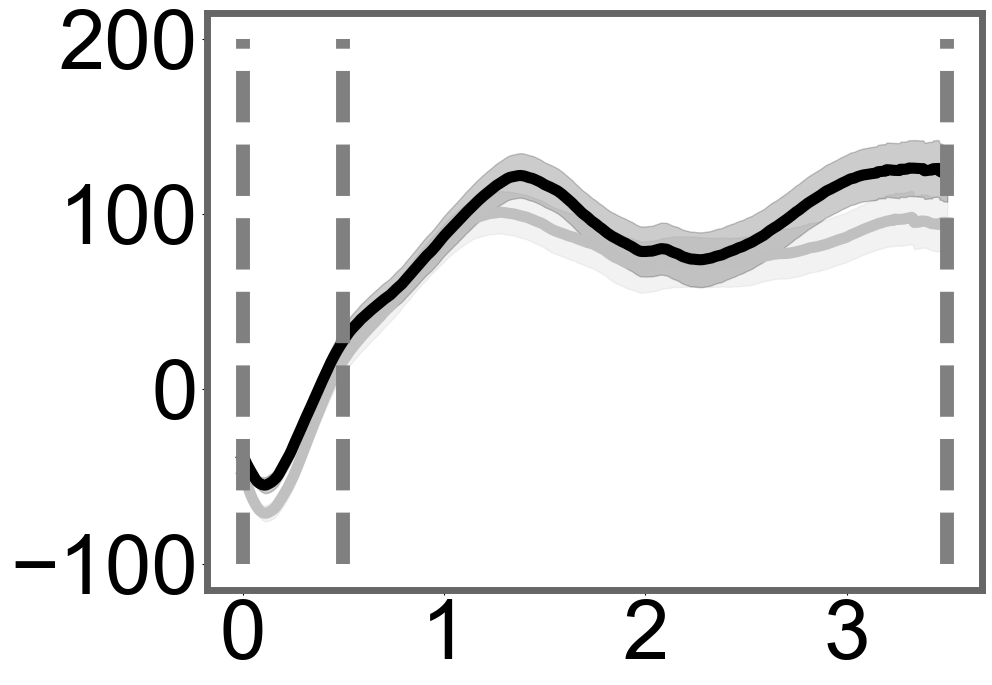

In [121]:

pupMean = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['silver','black'][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['silver','black'][i]) for i in [0,1]]
plt.fill_between([2.6,3.3],160,180,color = "#949494",alpha = 0.2)


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


pupMean = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['silver','black'][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['silver','black'][i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


In [122]:
#load trls
corrTrials = behavTag[(behavTag.correctness == 1) & (behavTag.trlType == 'visual')].TRIALID.values
incorrTrials = behavTag[(behavTag.correctness == 0) & (behavTag.trlType == 'visual')].TRIALID.values
print(' - correct visual trial counts: ',len(corrTrials),'; incorrect counts:',len(incorrTrials))

if noDistractorTrlsOnly:
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_vis5000_corr.npy')
else:
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_vis5000_corr_wDistractor.npy')

consGroups,pValue,fsum = findPupSig(pupNorm,corrTrials,fCluster)
print('aggregated (overall) correct trial clusters: \n', formatOut(consGroups,pValue) )

if plotfCluster:
    fs(3,3)
    plt.hist(fCluster,bins = 20)
    plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r');

if noDistractorTrlsOnly:
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_vis5000_incorr.npy')
else:
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_vis5000_incorr_wDistractor.npy')
consGroups,pValue,fsum = findPupSig(pupNorm,incorrTrials,fCluster)

print('aggregated (overall) incorrect trial clusters: \n', formatOut(consGroups,pValue))

 - correct visual trial counts:  3698 ; incorrect counts: 1048
aggregated (overall) correct trial clusters: 
 [([1.1, 1.9], 0.035), ([2.1, 3.5], 0.015)]
aggregated (overall) incorrect trial clusters: 
 []


0.07140000000000002

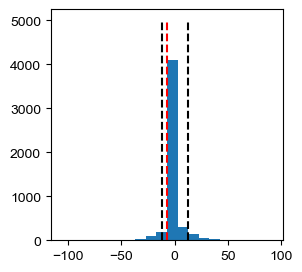

In [129]:
fs(3,3)
plt.hist(fCluster,bins = 20)
plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r');

1-sum(fCluster> fsum)/len(fCluster)

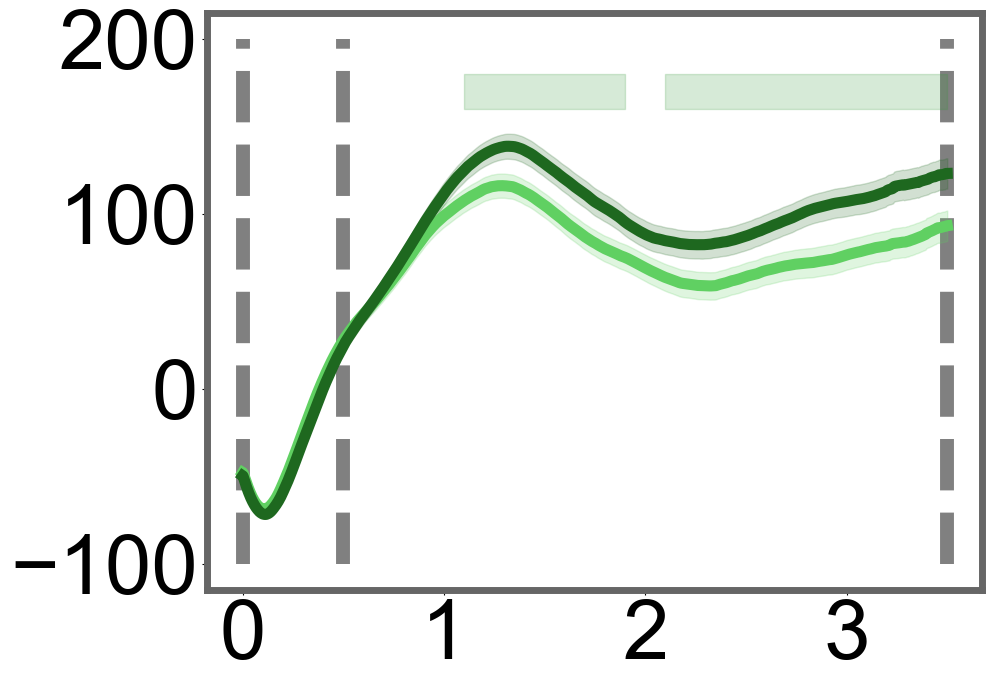

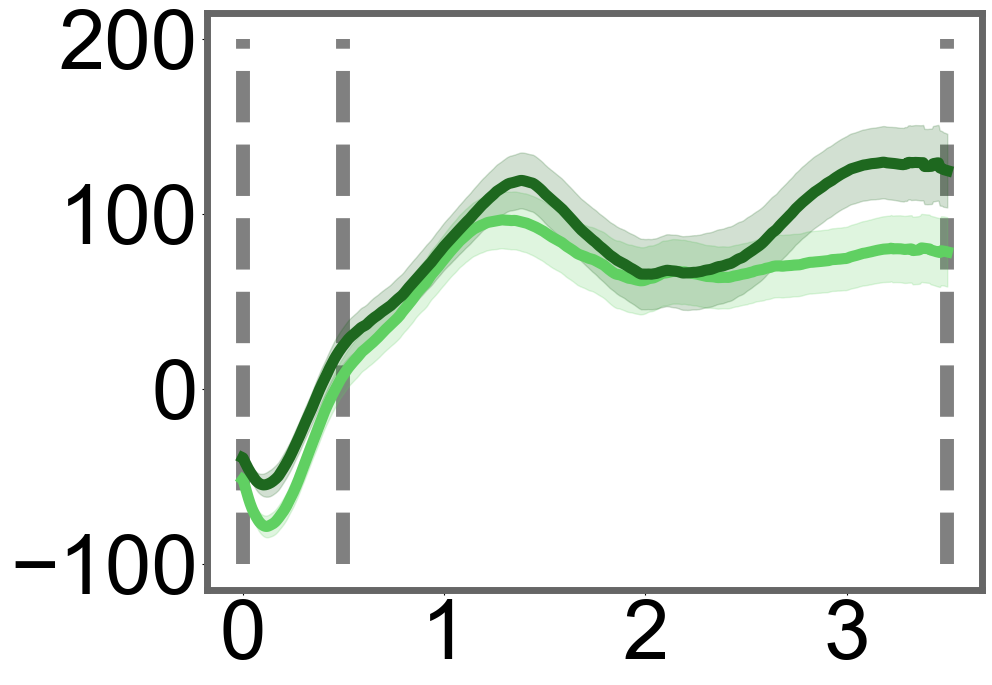

In [123]:
pupMean = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['#60d062', '#1e681f'][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['#60d062', '#1e681f'][i]) for i in [0,1]]
plt.fill_between([1.1,1.9],160,180,color = "#359937",alpha = 0.2)
plt.fill_between([2.1,3.5],160,180,color = "#359937",alpha = 0.2)


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10,zorder = 0)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


pupMean = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['#60d062', '#1e681f'][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['#60d062', '#1e681f'][i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10,zorder = 0)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


In [ ]:
#load trls
corrTrials = behavTag[(behavTag.correctness == 1) & (behavTag.trlType == 'verbal')].TRIALID.values
incorrTrials = behavTag[(behavTag.correctness == 0) & (behavTag.trlType == 'verbal')].TRIALID.values
print(' - correct verbal trial counts: ',len(corrTrials),'; incorrect counts:',len(incorrTrials))

consGroups,pValue,fsum = findPupSig(pupNorm,corrTrials,fCluster)
print('aggregated (overall) correct trial clusters: \n', formatOut(consGroups,pValue) )

if plotfCluster:
    fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/pupilPerm/tCluster_vis5000_corr_wDistractor.npy')
    fs(3,3)
    plt.hist(fCluster,bins = 20)
    plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
    plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r');

consGroups,pValue,fsum = findPupSig(pupNorm,incorrTrials,fCluster)

print('aggregated (overall) incorrect trial clusters: \n', formatOut(consGroups,pValue))

 - correct verbal trial counts:  3959 ; incorrect counts: 787
aggregated (overall) correct trial clusters: 
 []
aggregated (overall) incorrect trial clusters: 
 []


In [131]:
fsum

[0.0]

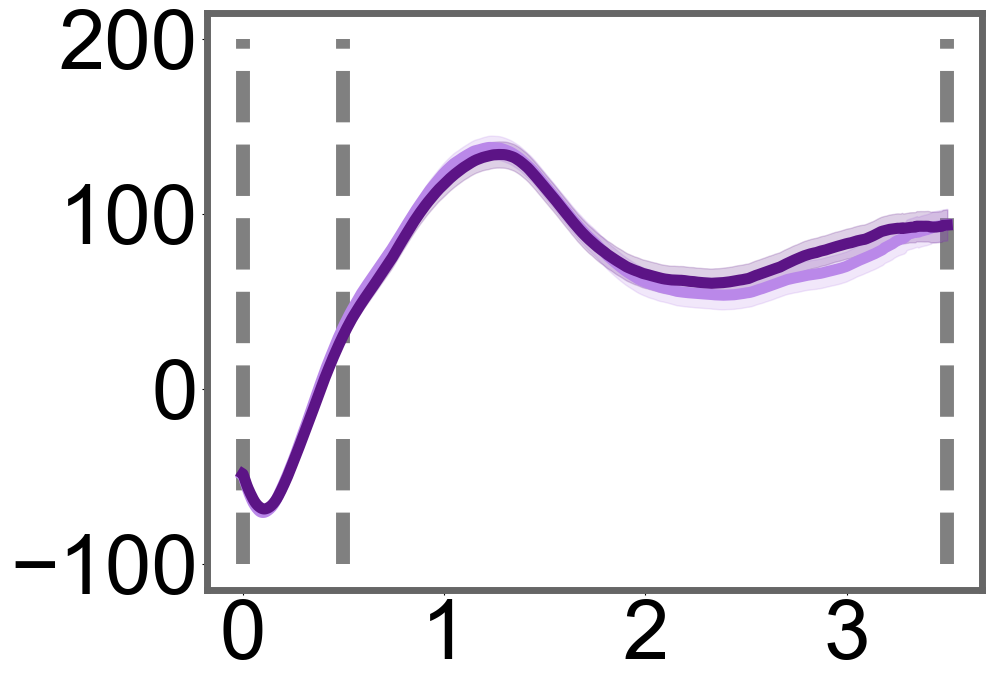

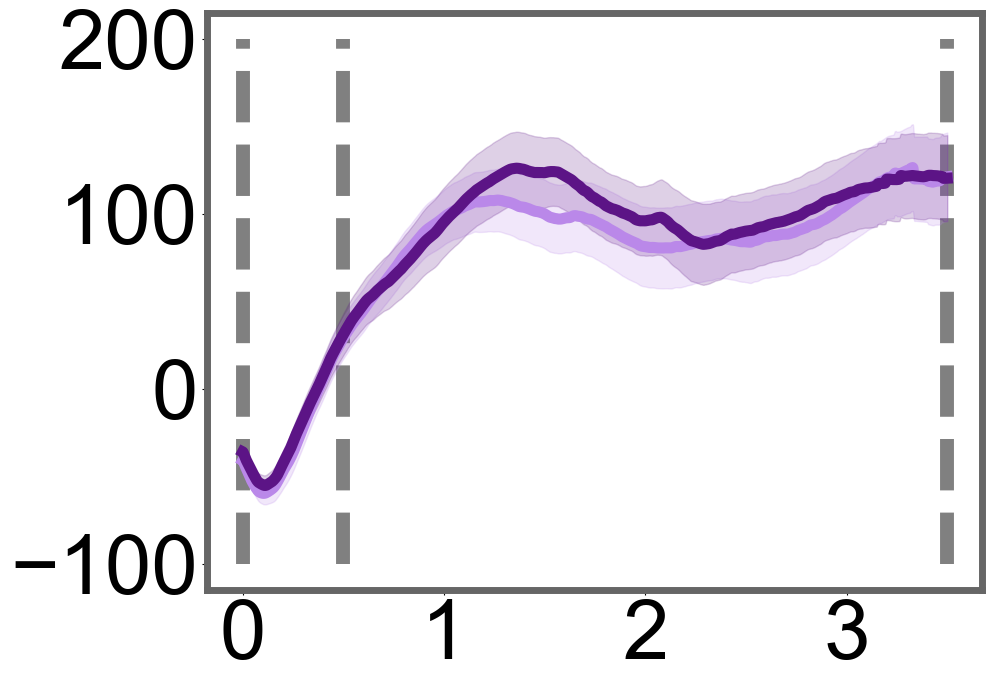

In [359]:
pupMean = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['#ba88e9', '#5c1486',][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['#ba88e9', '#5c1486',][i]) for i in [0,1]]



plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10,zorder = 0)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


pupMean = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = ['#ba88e9', '#5c1486',][i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = ['#ba88e9', '#5c1486',][i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10,zorder = 0)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


# vviq

In [67]:
vviq = pd.read_csv('Z:/yueying/psychedeLights_YueyingDong/data/vviq_allSubj.csv')

In [68]:

#colors = [ '#3f5ba0','#559ec9','#f2f1e2'][::-1] 
colors = [ '#3f5ba0','#559ec9',"#afcbf0"][::-1] 


In [69]:
pupTag = pupNorm.iloc[:,[0,-3,-2,-1]]
pupTag['earlyDelay'] = pupNorm.iloc[:,1100:1800].mean(axis =1)
pupTag['lateDelay'] = pupNorm.iloc[:,2500:3500].mean(axis =1)

In [70]:
pupVviqMean = pupTag.groupby(['participant','trlType','cuedItemBri']).mean(numeric_only=True)
pupVviqMean = pupVviqMean.loc[:,:,'night'] - pupVviqMean.loc[:,:,'day']
pupVviqMean = pupVviqMean.reset_index().merge(vviq[['subj','vviq']],how = 'left',left_on='participant',right_on='subj')

vviqLow = np.percentile(pupVviqMean.vviq,33),
vviqHigh = np.percentile(pupVviqMean.vviq,66)

pupVviqMean.loc[(pupVviqMean.vviq > vviqHigh),'vviqCategory'] = 'strong'
pupVviqMean.loc[pupVviqMean.vviq < vviqLow,'vviqCategory'] = 'weak'
pupVviqMean.loc[(pupVviqMean.vviq >= vviqLow) & (pupVviqMean.vviq <= vviqHigh),'vviqCategory'] = 'moderate'
pupVviqMean = pupVviqMean.set_index(['participant','trlType','vviq'])


In [71]:
pupVviqMean

earlyDelay   lateDelay  subj vviqCategory
participant trlType vviq                                           
249.0       verbal  74     11.535009   -7.601244   249       strong
            visual  74     -6.359022   -2.301626   249       strong
251.0       verbal  53     43.355058   30.568835   251     moderate
            visual  53     43.748817   16.403174   251     moderate
252.0       verbal  55     14.716568   -9.856426   252     moderate
...                              ...         ...   ...          ...
294.0       visual  53     34.560512   17.807973   294     moderate
295.0       verbal  53     30.151201   14.590744   295     moderate
            visual  53     68.410205  137.329080   295     moderate
296.0       verbal  61     62.484325   56.003476   296       strong
            visual  61      6.500131   68.754054   296       strong

[88 rows x 4 columns]

In [75]:
pupTag = pupNorm.iloc[:,[0,-3,-2,-1]]
pupTag['meanPup'] = pupNorm.iloc[:,1100:1800].mean(axis =1)

In [76]:
#pupVviq= pupTag.merge(vviq[['id','score']],how = 'left',left_on='participant',right_on='id')
pupVviqMean = pupTag.groupby(['participant','trlType','cuedItemBri']).mean(numeric_only=True)
pupVviqMean = pupVviqMean.loc[:,:,'night'] - pupVviqMean.loc[:,:,'day']
pupVviqMean = pupVviqMean.reset_index().merge(vviq[['subj','vviq']],how = 'left',left_on='participant',right_on='subj')

In [77]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

In [78]:
"""vviqLow = np.percentile(pupVviqMean.vviq,33),
vviqHigh = np.percentile(pupVviqMean.vviq,66)

pupVviqMean.loc[(pupVviqMean.vviq > vviqHigh),'vviqCategory'] = 'strong'
pupVviqMean.loc[pupVviqMean.vviq < vviqLow,'vviqCategory'] = 'weak'
pupVviqMean.loc[(pupVviqMean.vviq >= vviqLow) & (pupVviqMean.vviq <= vviqHigh),'vviqCategory'] = 'moderate'

"""

"vviqLow = np.percentile(pupVviqMean.vviq,33),\nvviqHigh = np.percentile(pupVviqMean.vviq,66)\n\npupVviqMean.loc[(pupVviqMean.vviq > vviqHigh),'vviqCategory'] = 'strong'\npupVviqMean.loc[pupVviqMean.vviq < vviqLow,'vviqCategory'] = 'weak'\npupVviqMean.loc[(pupVviqMean.vviq >= vviqLow) & (pupVviqMean.vviq <= vviqHigh),'vviqCategory'] = 'moderate'\n\n"

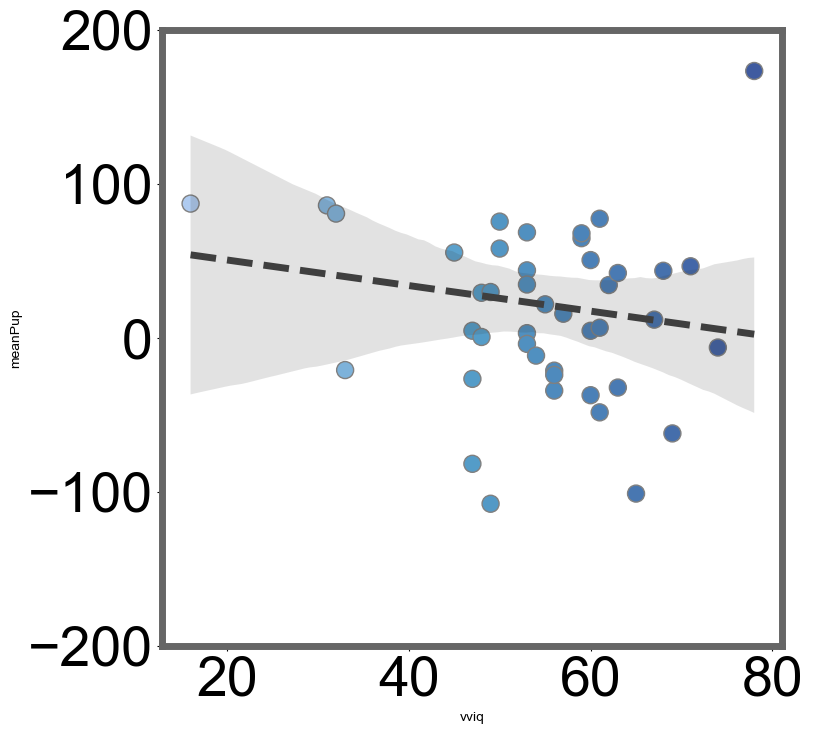

In [80]:
fs(8,8)
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=44)
qq = [mcolors.rgb2hex(cmap(x)[:3]) for x in range(pupVviqMean.vviq.nunique())]
fig,ax = plt.subplots()

# Add regression line
sns.regplot(
    x='vviq', y='meanPup', data=pupVviqMean[pupVviqMean.trlType =='visual'], scatter=False,
    line_kws={'color': "#3F3F3F", 'linewidth': 5, 'linestyle': '--'},
    ax=plt.gca()
)
plt.scatter(
    pupVviqMean[pupVviqMean.trlType =='visual']['vviq'], pupVviqMean[pupVviqMean.trlType =='visual']['meanPup'], 
    c=pupVviqMean[pupVviqMean.trlType =='visual']['vviq'], cmap=cmap, s=150, alpha=1, edgecolor='grey',zorder = 0,
)

#plt.xlim(10,80)
plt.ylim(-200,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.tick_params(labelsize=40)
plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

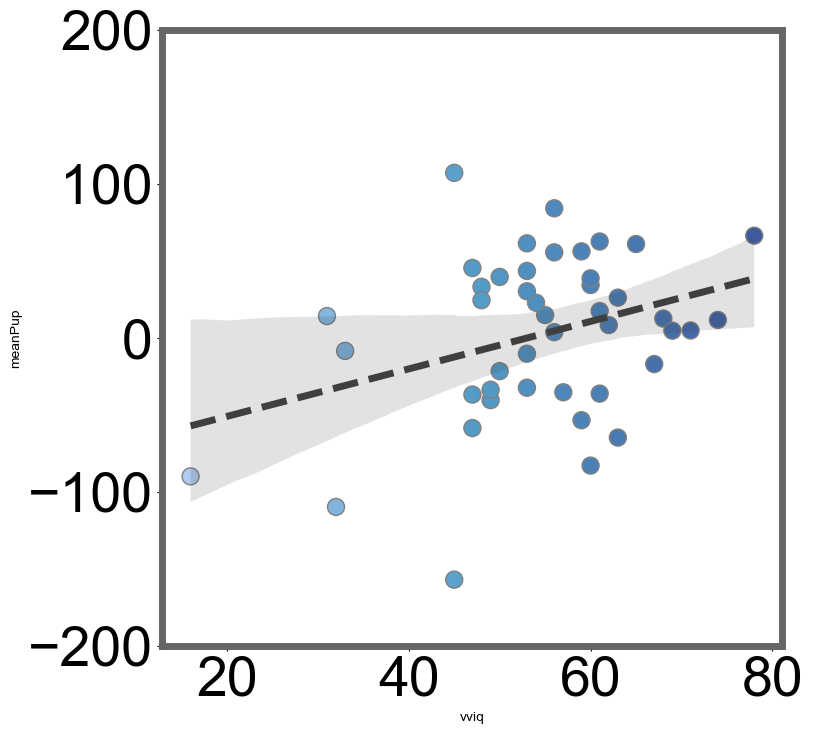

In [81]:
fs(8,8)
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=44)
qq = [mcolors.rgb2hex(cmap(x)[:3]) for x in range(pupVviqMean.vviq.nunique())]
fig,ax = plt.subplots()

# Add regression line
sns.regplot(
    x='vviq', y='meanPup', data=pupVviqMean[pupVviqMean.trlType =='verbal'], scatter=False,
    line_kws={'color': "#3F3F3F", 'linewidth': 5, 'linestyle': '--'},
    ax=plt.gca()
)
plt.scatter(
    pupVviqMean[pupVviqMean.trlType =='verbal']['vviq'], pupVviqMean[pupVviqMean.trlType =='verbal']['meanPup'], 
    c=pupVviqMean[pupVviqMean.trlType =='verbal']['vviq'], cmap=cmap, s=150, alpha=1, edgecolor='grey',zorder = 0,
)

#plt.xlim(10,80)
plt.ylim(-200,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.tick_params(labelsize=40)
plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [86]:
from scipy.stats import linregress

result = linregress(pupVviqMean[pupVviqMean.trlType == 'verbal'].vviq,
         pupVviqMean[pupVviqMean.trlType == 'verbal'].meanPup)
result

LinregressResult(slope=1.542062467713827, intercept=-81.92533830514249, rvalue=0.3354623874657486, pvalue=0.02600809241821214, stderr=0.6682040478078428, intercept_stderr=37.21316307567017)

In [82]:
pearsonr(pupVviqMean[pupVviqMean.trlType == 'verbal'].vviq,
         pupVviqMean[pupVviqMean.trlType == 'verbal'].meanPup)

PearsonRResult(statistic=0.33546238746574897, pvalue=0.026008092418211965)

In [87]:
result = linregress(pupVviqMean[pupVviqMean.trlType == 'visual'].vviq,
         pupVviqMean[pupVviqMean.trlType == 'visual'].meanPup)
result

LinregressResult(slope=-0.8311352433559386, intercept=67.11499731099067, rvalue=-0.1466537781968888, pvalue=0.3421450178234614, stderr=0.8650328203119385, intercept_stderr=48.17481653049219)

In [83]:
pearsonr(pupVviqMean[pupVviqMean.trlType == 'visual'].vviq,
         pupVviqMean[pupVviqMean.trlType == 'visual'].meanPup)

PearsonRResult(statistic=-0.14665377819688888, pvalue=0.3421450178234613)

In [84]:
vviqHigh

60.0

In [187]:
vviqLow

(50.0,)

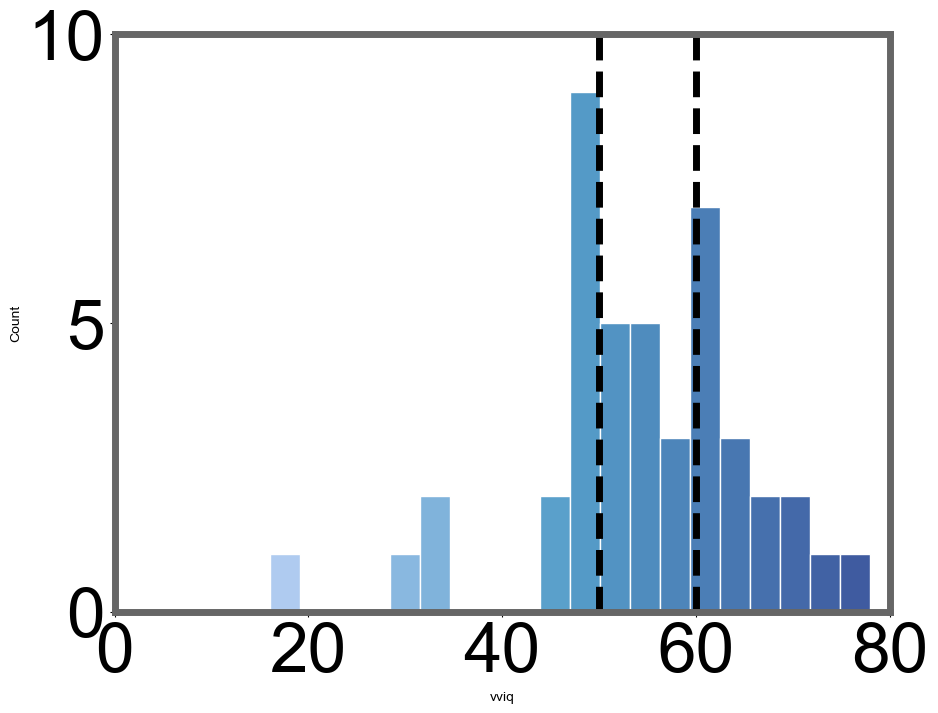

In [188]:
fs(10,7.5)

binNum = 20
ax = sns.histplot(vviq[vviq.subj.isin(pupVviqMean.participant.unique())].vviq,bins = binNum)
#create the colored bins
cm = LinearSegmentedColormap.from_list("Custom", colors, N=binNum)
[p.set(color = cm(n),linewidth = 1,edgecolor = 'white') for n,p in enumerate(ax.patches)]
ax.tick_params(labelsize=40)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))

#plt.vlines([16],0,150,linestyles='dashed',colors='grey',linewidth = 5)
plt.vlines(vviqHigh,0,150,linestyles='dashed',colors='black',linewidth = 5)
plt.vlines(vviqLow[0],0,150,linestyles='dashed',colors='black',linewidth = 5)
#plt.vlines(vviqMed,0,150,linestyles='dashed',colors='black',linewidth = 5)


plt.xlim(0,80)
plt.ylim(0,10)

plt.xticks(fontsize=50,)
plt.yticks(fontsize=50)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [191]:

"""   """

highImagers = vviq[vviq.vviq > vviqHigh].subj.values
lowImagers = vviq[vviq.vviq < vviqLow].subj.values
MedImagers = vviq[(vviq.vviq >= vviqLow) & (vviq.vviq <= vviqHigh)].subj.values

pupHighImagers = pupNorm[pupNorm.participant.isin(highImagers)]
pupMedImagers = pupNorm[pupNorm.participant.isin(MedImagers)]
pupLowImagers = pupNorm[pupNorm.participant.isin(lowImagers)]


In [192]:
len(highImagers),len(MedImagers),len(lowImagers)

(15, 18, 14)

In [193]:
  """
highImagers = vviq[vviq.vviq >= vviqMed].subj.values
lowImagers = vviq[vviq.vviq < vviqMed].subj.values

pupHighImagers = pupNorm[pupNorm.participant.isin(highImagers)]
pupLowImagers = pupNorm[pupNorm.participant.isin(lowImagers)]  """

'\nhighImagers = vviq[vviq.vviq >= vviqMed].subj.values\nlowImagers = vviq[vviq.vviq < vviqMed].subj.values\n\npupHighImagers = pupNorm[pupNorm.participant.isin(highImagers)]\npupLowImagers = pupNorm[pupNorm.participant.isin(lowImagers)]  '

In [194]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']
lenData = 3500

In [195]:
lenData

3500

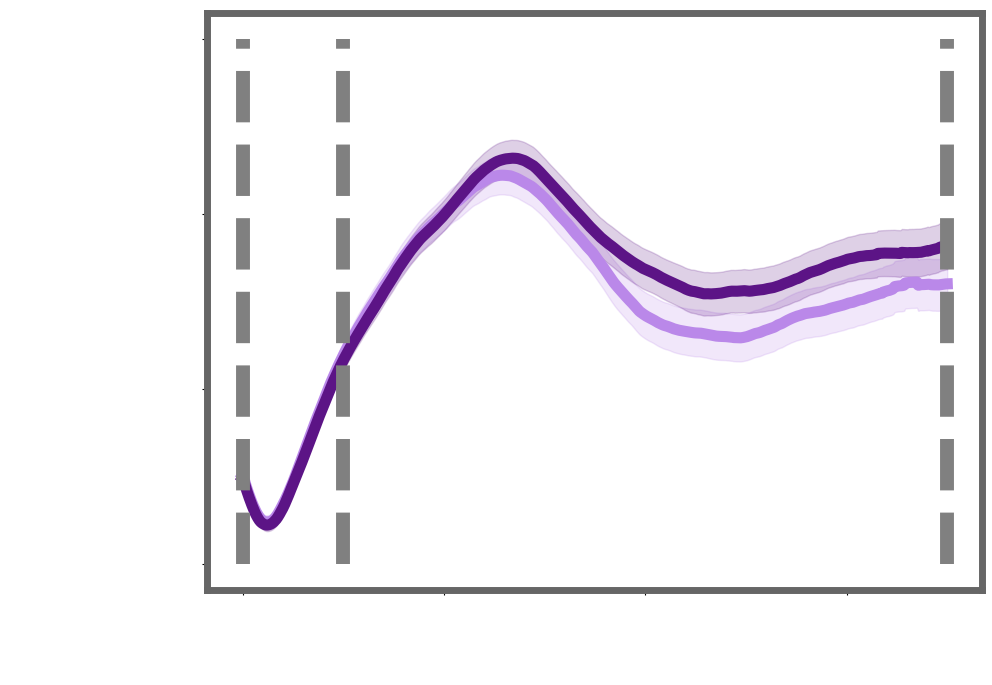

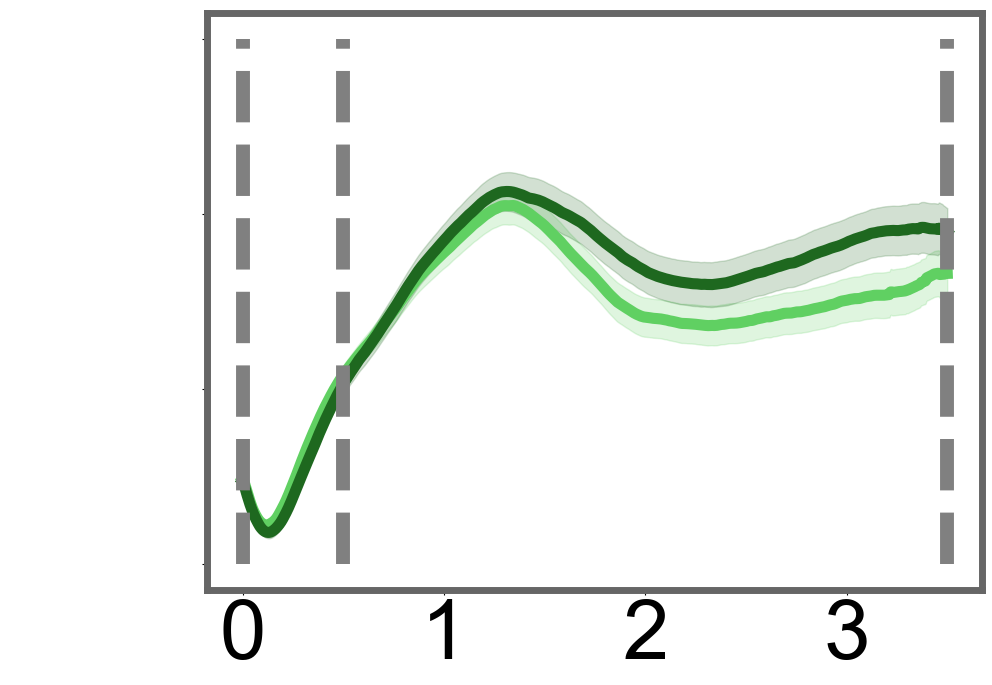

In [196]:
type = 'x'
if type == 'individual':
    lenData = 3500
    pupMeanSubj = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['participant','trlType','cuedItemBri',]).mean()
    pupDiffSubj = pd.concat([
                pupMeanSubj.iloc[::2,:].reset_index().iloc[:,:2],
                pd.DataFrame(pupMeanSubj.loc[:,:,'night'].values - pupMeanSubj.loc[:,:,'day'].values)
            ],axis =1).set_index(['participant','trlType'])

    pupDiffMean = pupDiffSubj.groupby(['trlType']).mean()
    pupDiffSd = pupDiffSubj.groupby(['trlType']).sem()

    pupDiffUpper = pupDiffMean + pupDiffSd
    pupDiffLower = pupDiffMean - pupDiffSd


    pupMean = pupMeanSubj.groupby(['trlType','cuedItemBri']).mean()
    pupSd = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
else:
    pupMean = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
    pupSd = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
fs(10,7.5)

fig,ax = plt.subplots()
x = np.linspace(0,3.5,3500)
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,c = 'white')

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

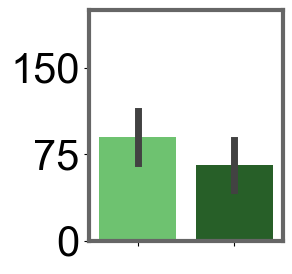

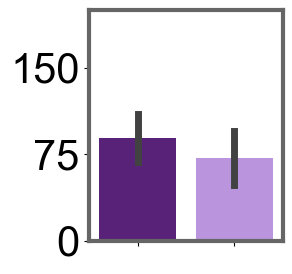

In [197]:
pupTag = pupHighImagers.iloc[:,[0,-3,-2,-1]]
pupTag['meanPup'] = pupHighImagers.iloc[:,np.r_[1100:1800,2500:3500]].mean(axis =1)
fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#1e681f','#60d062',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'visual'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'verbal'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

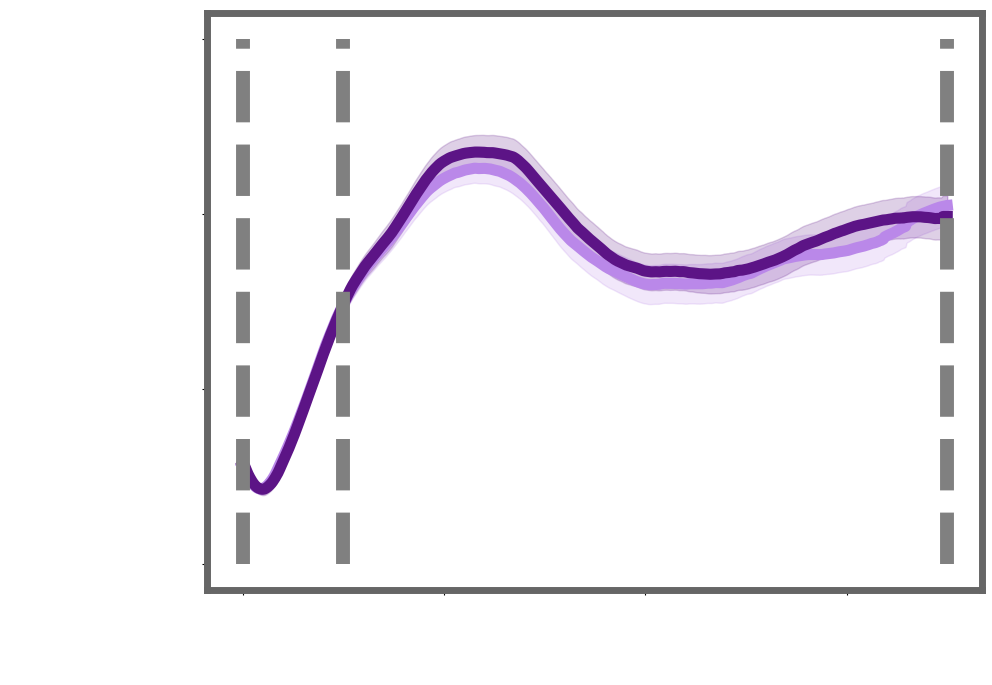

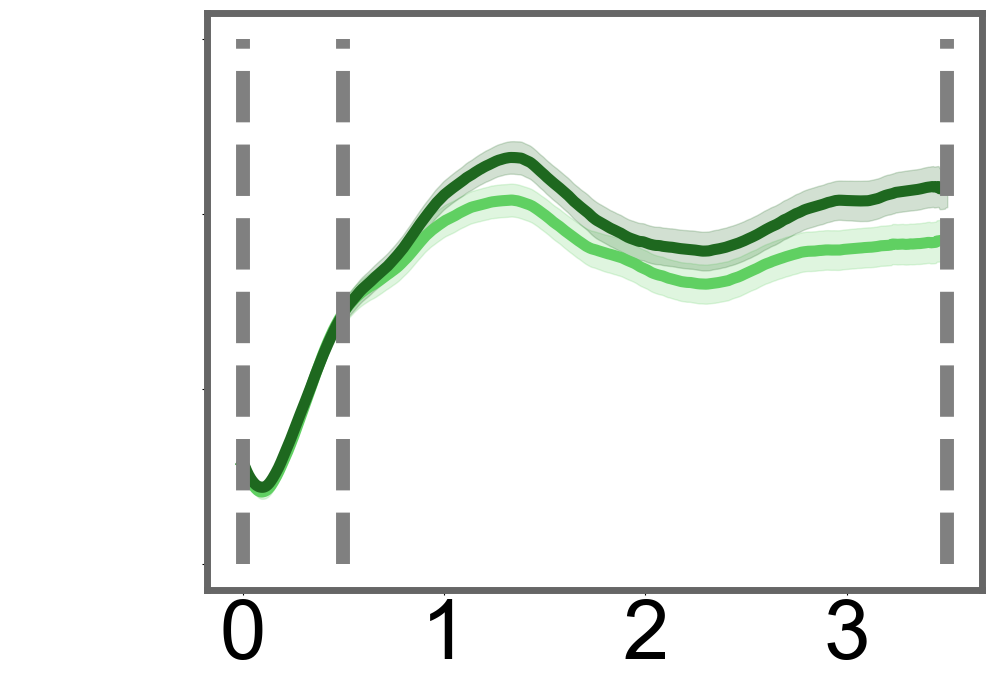

In [198]:
type = 'x'
if type == 'individual':
    lenData = 3500
    pupMeanSubj = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['participant','trlType','cuedItemBri',]).mean()
    pupDiffSubj = pd.concat([
                pupMeanSubj.iloc[::2,:].reset_index().iloc[:,:2],
                pd.DataFrame(pupMeanSubj.loc[:,:,'night'].values - pupMeanSubj.loc[:,:,'day'].values)
            ],axis =1).set_index(['participant','trlType'])

    pupDiffMean = pupDiffSubj.groupby(['trlType']).mean()
    pupDiffSd = pupDiffSubj.groupby(['trlType']).sem()

    pupDiffUpper = pupDiffMean + pupDiffSd
    pupDiffLower = pupDiffMean - pupDiffSd


    pupMean = pupMeanSubj.groupby(['trlType','cuedItemBri']).mean()
    pupSd = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
else:
    pupMean = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
    pupSd = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,c = 'white')

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

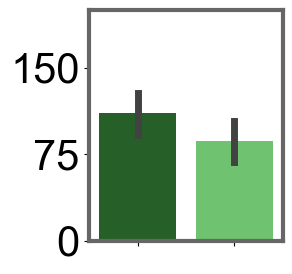

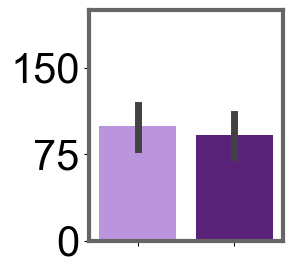

In [199]:
pupTag = pupMedImagers.iloc[:,[0,-3,-2,-1]]
pupTag['meanPup'] = pupMedImagers.iloc[:,np.r_[1100:1800,2500:3500]].mean(axis =1)
fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#1e681f','#60d062',],
            order = ['night','day',],hue_order=['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'visual'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'verbal'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

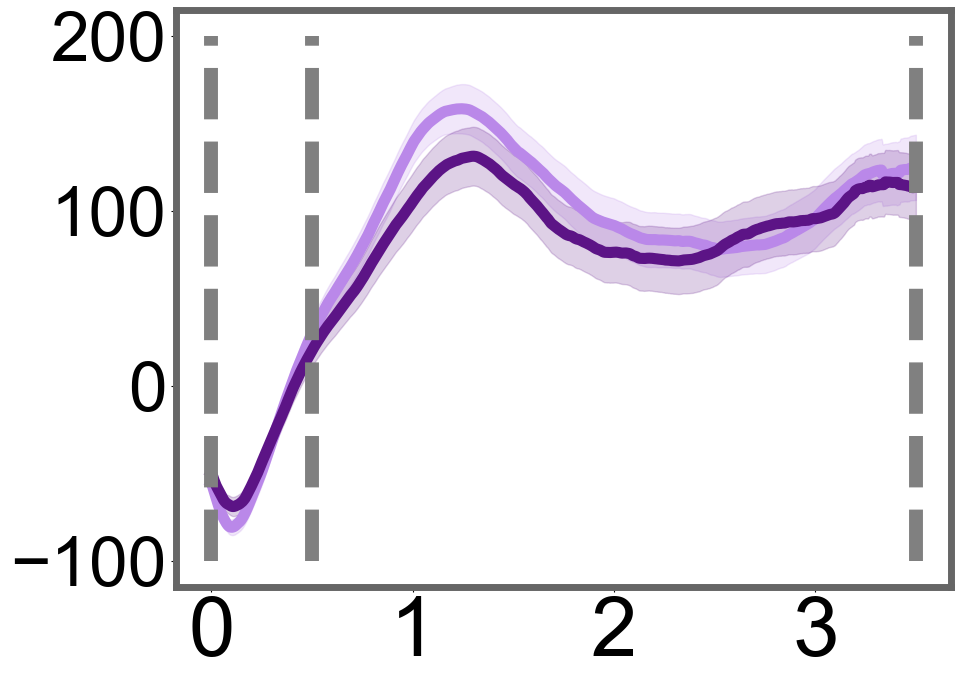

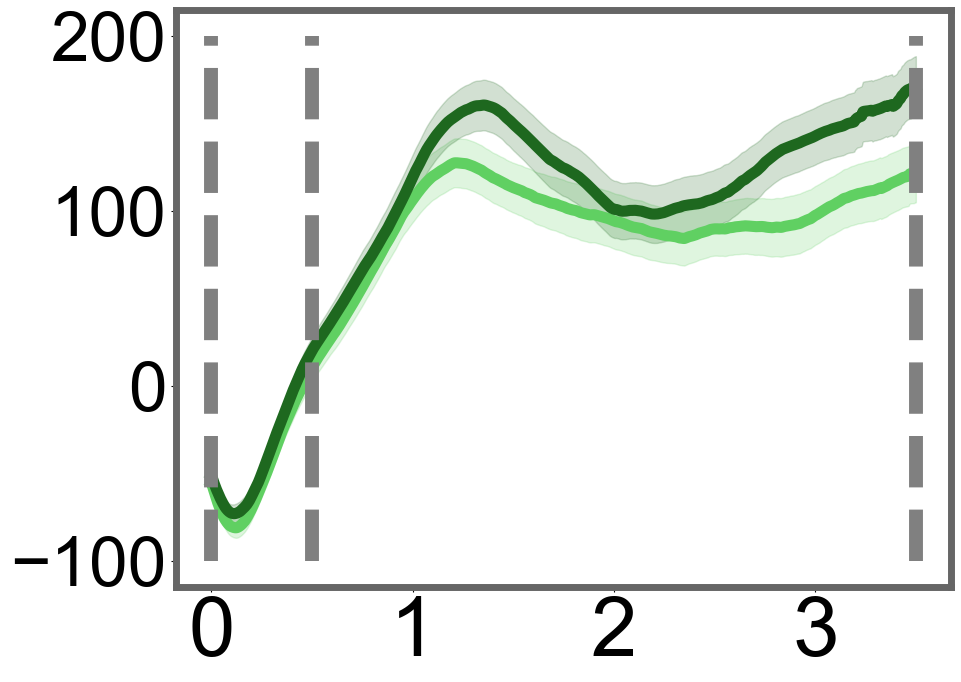

In [203]:
type = 'x'
if type == 'individual':
    lenData = 3500
    pupMeanSubj = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['participant','trlType','cuedItemBri',]).mean()
    pupDiffSubj = pd.concat([
                pupMeanSubj.iloc[::2,:].reset_index().iloc[:,:2],
                pd.DataFrame(pupMeanSubj.loc[:,:,'night'].values - pupMeanSubj.loc[:,:,'day'].values)
            ],axis =1).set_index(['participant','trlType'])

    pupDiffMean = pupDiffSubj.groupby(['trlType']).mean()
    pupDiffSd = pupDiffSubj.groupby(['trlType']).sem()

    pupDiffUpper = pupDiffMean + pupDiffSd
    pupDiffLower = pupDiffMean - pupDiffSd


    pupMean = pupMeanSubj.groupby(['trlType','cuedItemBri']).mean()
    pupSd = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
else:
    pupMean = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
    pupSd = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
    pupUpper = pupMean + pupSd
    pupLower = pupMean - pupSd
   
fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=50)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth(pupUpper.iloc[i,:lenData]),smooth(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=50)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

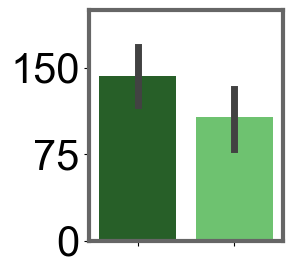

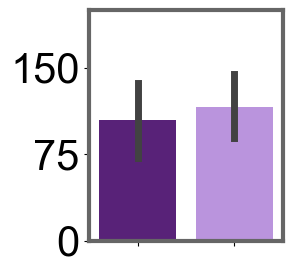

In [202]:
pupTag = pupLowImagers.iloc[:,[0,-3,-2,-1]]
pupTag['meanPup'] = pupLowImagers.iloc[:,np.r_[1100:1800,2500:3500]].mean(axis =1)
fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#1e681f','#60d062',],
            order = ['night','day',],hue_order=['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'visual'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

fs(2.5,3)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupTag[pupTag.trlType == 'verbal'])



plt.ylim(0,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(75))
plt.tick_params(axis = 'y',labelsize=30)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

# IPA

In [71]:
import math, pywt, numpy as np
def modmax(pupCD2):
    m = np.fabs(pupCD2)

    # if value larger than both neightbours 
    # and is strictly larger than either
    # it's a local maximum
    t = [0.0] * len(pupCD2)
    
    for i in range(len(pupCD2)):
        ll = m[i-1] if i >1 else m[i]
        oo = m[i]
        rr = m[i+1] if i < len(pupCD2) -2 else m[i]

        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr): 
            # compute magnitude 
            t[i] = math.sqrt(pupCD2[i]**2) 
        else: t[i] = 0.0
    return t 


def ipa(pupMasked,freq = 1000):
    pupRemainConcat = pupMasked[~np.isnan(pupMasked)] 
    try:
        #get the 2 level dwt of pupil diameter
        (cA2,cD2,cD1) = pywt.wavedec(pupRemainConcat,'sym16','antireflect',level=2)
    except:
        return np.nan
    #get the signal duration
    tt = len(pupRemainConcat)/freq

    # normalize by 1/2 j , j = 2 for 2- level DWT
    cA2 = cA2/math.sqrt(4)
    cD1 = cD1/math.sqrt(2)
    cD2 = cD2/math.sqrt(4)
    #find modulus maxima
    cD2m = modmax(cD2)

    #thresholding and count the number of remainings
    threshold = np.std(cD2m)* math.sqrt(2.0*np.log2(len(cD2m)))
    cD2t = pywt.threshold(cD2m,threshold, mode = 'hard')
    ipa = sum(np.fabs(cD2t) > 0 )/tt
    return ipa

In [72]:
calculateRolling = False
calculateFull = False
readinPupRaw = False

In [73]:
if readinPupRaw:
    blkMask = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                              borderlenBef= 0.2, borderlenAft = 0.2,
                                              clusterLapse = 0.05, madThreshold = 8,returnMask=True),axis = 1,raw = True)
    q = np.where(blkMask,np.nan,pupFullTrial_raw.iloc[:,1:])

In [74]:
if calculateRolling:
    
    # rolling ipa; also, if to run this, use the downsampled ipa
    aaa = input('Did you change the frequency in ipa function to 100? (y/n)')
    if aaa == 'y':
        window_size = 10

        ds_pupDf = pd.DataFrame(q[:,4001:7501]).groupby(np.arange(3500)//10,axis =1).mean(numeric_only = True)
        windows = np.lib.stride_tricks.sliding_window_view(ds_pupDf.values, window_shape=(window_size,), axis=1)

        ipaRolling = np.apply_along_axis(ipa, axis=2, arr=windows)

        ipaAllTls = pd.concat([pd.DataFrame(pupFullTrial_raw.iloc[:,0].reset_index(drop=True)),pd.DataFrame(ipaRolling)],axis = 1)
        ipaAllTls.to_csv('Z:/yueying/psychedeLights_YueyingDong/results/ipaData/rollingIPA_allTrls_ds.csv')
        ipaClean = ipaAllTls[ipaAllTls.TRIALID.isin(pupClean.TRIALID)].reset_index(drop=True)
        ipaClean.to_csv('Z:/yueying/psychedeLights_YueyingDong/results/ipaData/rollingIPA_clean_ds.csv')
else:
    ipaClean = pd.read_csv('Z:/yueying/psychedeLights_YueyingDong/results/ipaData/rollingIPA_clean_ds.csv').iloc[:,1:]

In [75]:
8854/216

40.99074074074074

In [76]:
if calculateFull:
    ipaAll = np.apply_along_axis(ipa, axis=1, arr=q[:,4501:7501])
    ipaDf = pd.DataFrame(ipaAll,columns = ['ipa'])
    ipaDf['TRIALID'] = pupFullTrial_raw['TRIALID'].values

    ipaDf = ipaDf.merge(psyFull[['TRIALID',
                                'cuedItemBri','participant','trlType','distractorType']],
                on = 'TRIALID',)
    ipaDf.to_csv('Z:/yueying/psychedeLights_YueyingDong/results/ipaData/singularIPA_clean.csv')
else:
    ipaDf = pd.read_csv('Z:/yueying/psychedeLights_YueyingDong/results/ipaData/singularIPA_clean.csv')

In [77]:
ipaRollingMean = ipaClean.drop(['TRIALID'],axis = 1).groupby(['trlType',]).mean(numeric_only=True).iloc[:,:-1]
ipaRollingSd = ipaClean.drop(['TRIALID'],axis = 1).groupby(['trlType',]).sem(numeric_only=True).iloc[:,:-1]
ipaRollingUpper = ipaRollingMean + ipaRollingSd
ipaRollingLower = ipaRollingMean - ipaRollingSd

In [78]:
cList = ["#8446be","#218d23"]
labelList = ['verbal','visual']

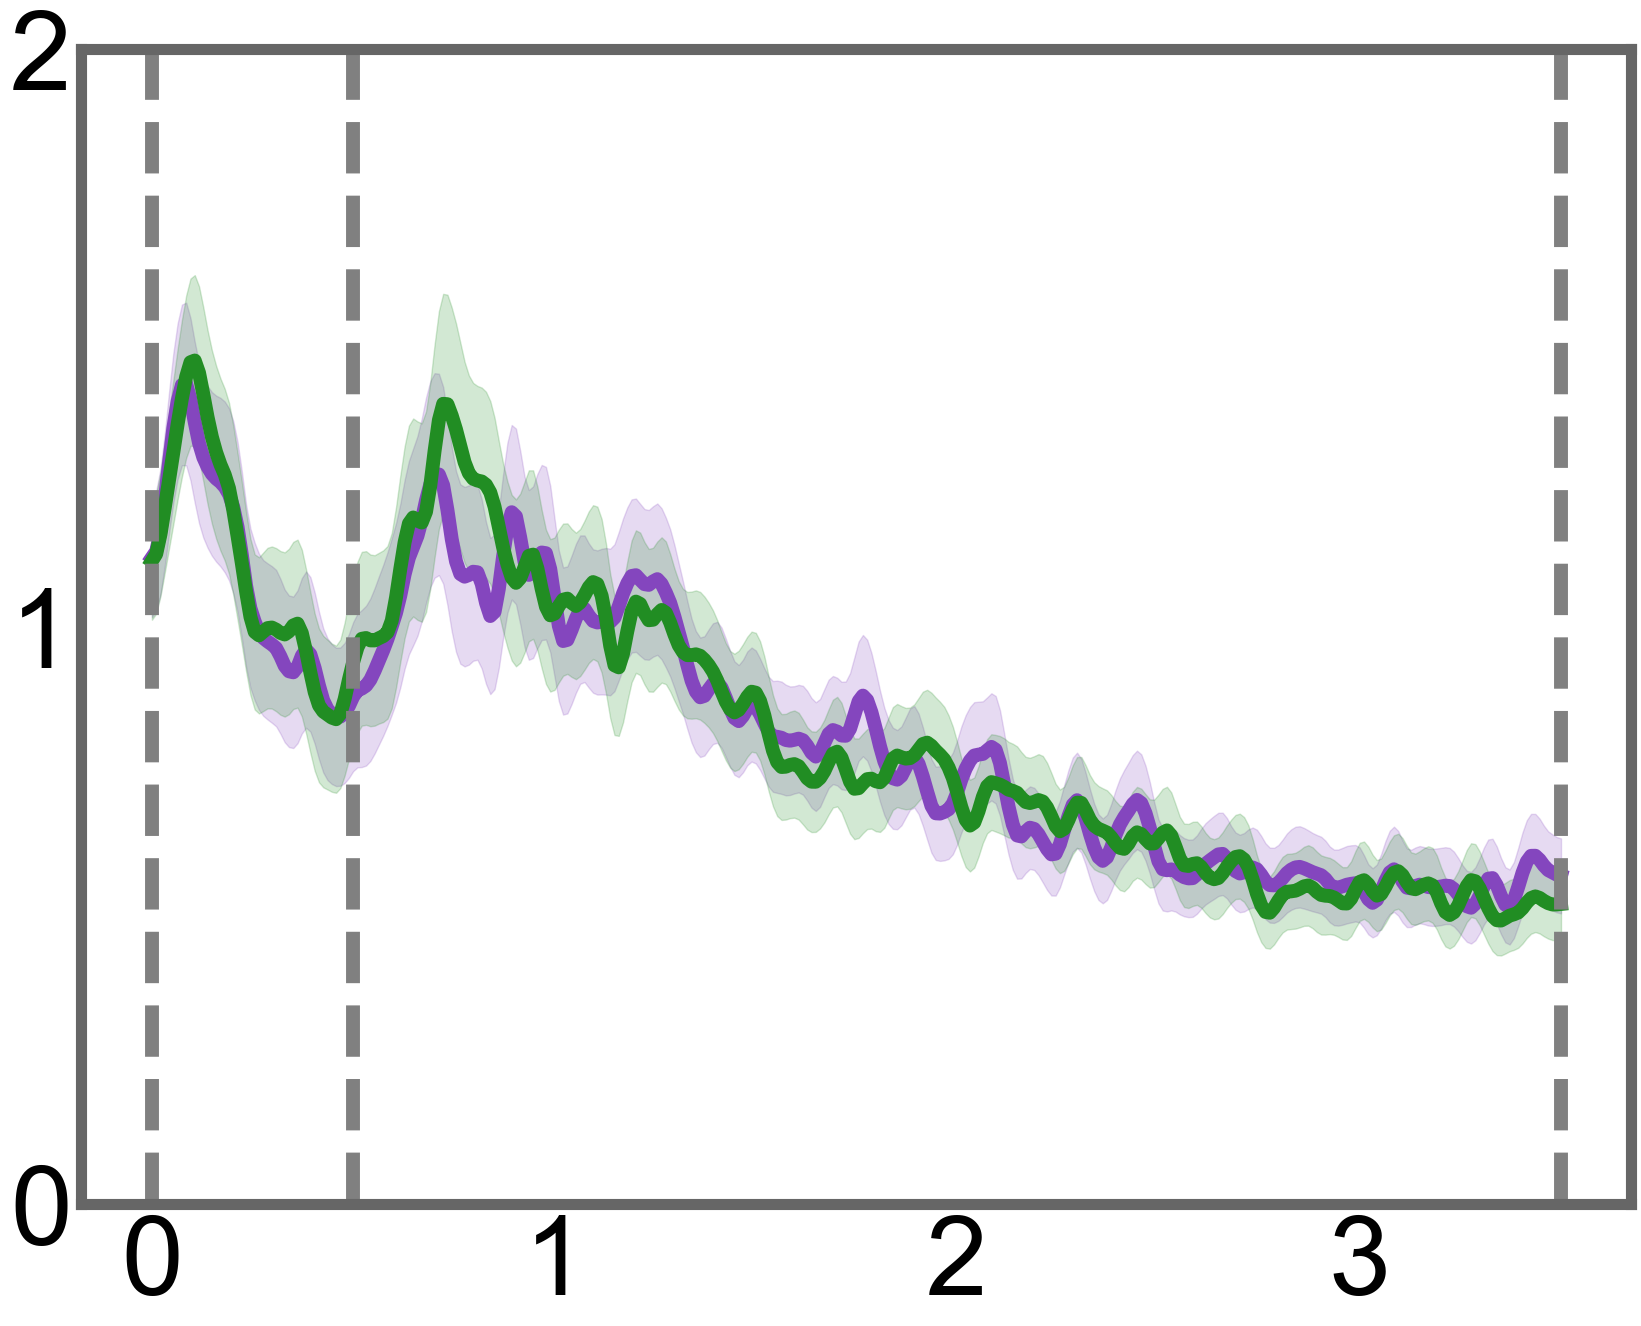

In [82]:
fs(20,15)
lenData = 330
x = np.linspace(0,3.5,lenData)
fig,ax = plt.subplots()

[plt.plot(x,smooth(ipaRollingMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 10) for i in range(2)]
[plt.fill_between(x,smooth(ipaRollingUpper.iloc[i,:lenData]),smooth(ipaRollingLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in range(2)]

plt.vlines([0,0.5,3.5],0,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.ylim(0,2)
plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)


In [83]:
ipaRollingMean = ipaClean.drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
ipaRollingSd = ipaClean.drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
ipaRollingUpper = ipaRollingMean + ipaRollingSd
ipaRollingLower = ipaRollingMean - ipaRollingSd

In [84]:
ipaRollingMean

0         1         2         3         4         5  \
cuedItemBri                                                              
day          1.02040  1.003746  1.125249  1.267004  1.265034  1.517164   
night        0.88916  1.239816  1.193743  1.224584  1.053577  1.362857   

                    6         7         8         9        10        11  \
cuedItemBri                                                               
day          1.354388  1.105976  1.368810  1.564597  1.402248  1.400148   
night        1.427575  1.563841  1.680693  1.429707  1.386065  1.430361   

                   12        13        14        15        16        17  \
cuedItemBri                                                               
day          1.323524  1.362537  1.297038  1.348627  1.198842  1.358774   
night        1.270343  1.255737  1.140513  1.477789  1.300388  0.905404   

                   18        19        20        21        22        23  \
cuedItemBri                                                               
day          1.597669  1.140225  1.008932  1.405147  0.964624  1.081450   
night        0.993263  1.445687  1.296790  1.035290  0.868754  0.878339   

                   24        25        26        27        28        29  \
cuedItemBri                                                               
day          0.989432  0.868453  0.927855  0.997817  0.821541  1.123240   
night        1.133759  0.881346  1.157806  1.108042  0.909079  0.937876   

                   30        31        32        33        34        35  \
cuedItemBri                                                               
day          1.020690  0.865022  0.781308  0.878969  0.958162  1.152623   
night        1.024139  0.997621  1.131820  0.852951  0.974750  0.926841   

                   36        37        38        39        40        41  \
cuedItemBri                                                               
day          0.972015  0.933149  0.845319  0.718469  0.887948  0.889154   
night        1.177662  0.896313  0.878765  0.892393  0.900639  0.843269   

                   42        43        44        45        46        47  \
cuedItemBri                                                               
day          0.784598  0.933622  0.840418  0.858505  0.837963  0.997979   
night        0.923800  0.757576  0.711640  0.844086  0.802536  1.021885   

                   48        49        50        51        52        53  \
cuedItemBri                                                               
day          0.981476  0.833024  0.911298  1.033030  0.936535  1.009449   
night        0.993414  0.966445  0.901027  0.897871  0.918095  0.867876   

                   54        55        56        57        58        59  \
cuedItemBri                                                               
day          0.905283  0.779002  0.884232  0.878437  1.087656  1.055489   
night        1.153321  1.133372  1.164029  0.874704  1.228329  1.125288   

                   60        61        62        63        64        65  \
cuedItemBri                                                               
day          1.106088  1.390719  1.492518  1.032809  0.872642  1.100528   
night        1.427891  0.938363  0.952850  1.158330  1.265827  1.392720   

                   66        67        68        69        70        71  \
cuedItemBri                                                               
day          1.268921  1.523531  1.317159  1.225215  1.434688  0.938813   
night        1.629304  1.051119  1.589857  1.001442  1.550208  1.280148   

                   72        73        74        75       76        77  \
cuedItemBri                                                              
day          1.241469  1.070227  1.615021  1.107344  1.06341  1.216300   
night        1.086654  1.021825  1.158652  1.125567  1.11730  1.325669   

                   78        79        80        81        82        83  \
cuedItemBri                            

In [85]:
cList = ["#6E6E6E","#000000"]


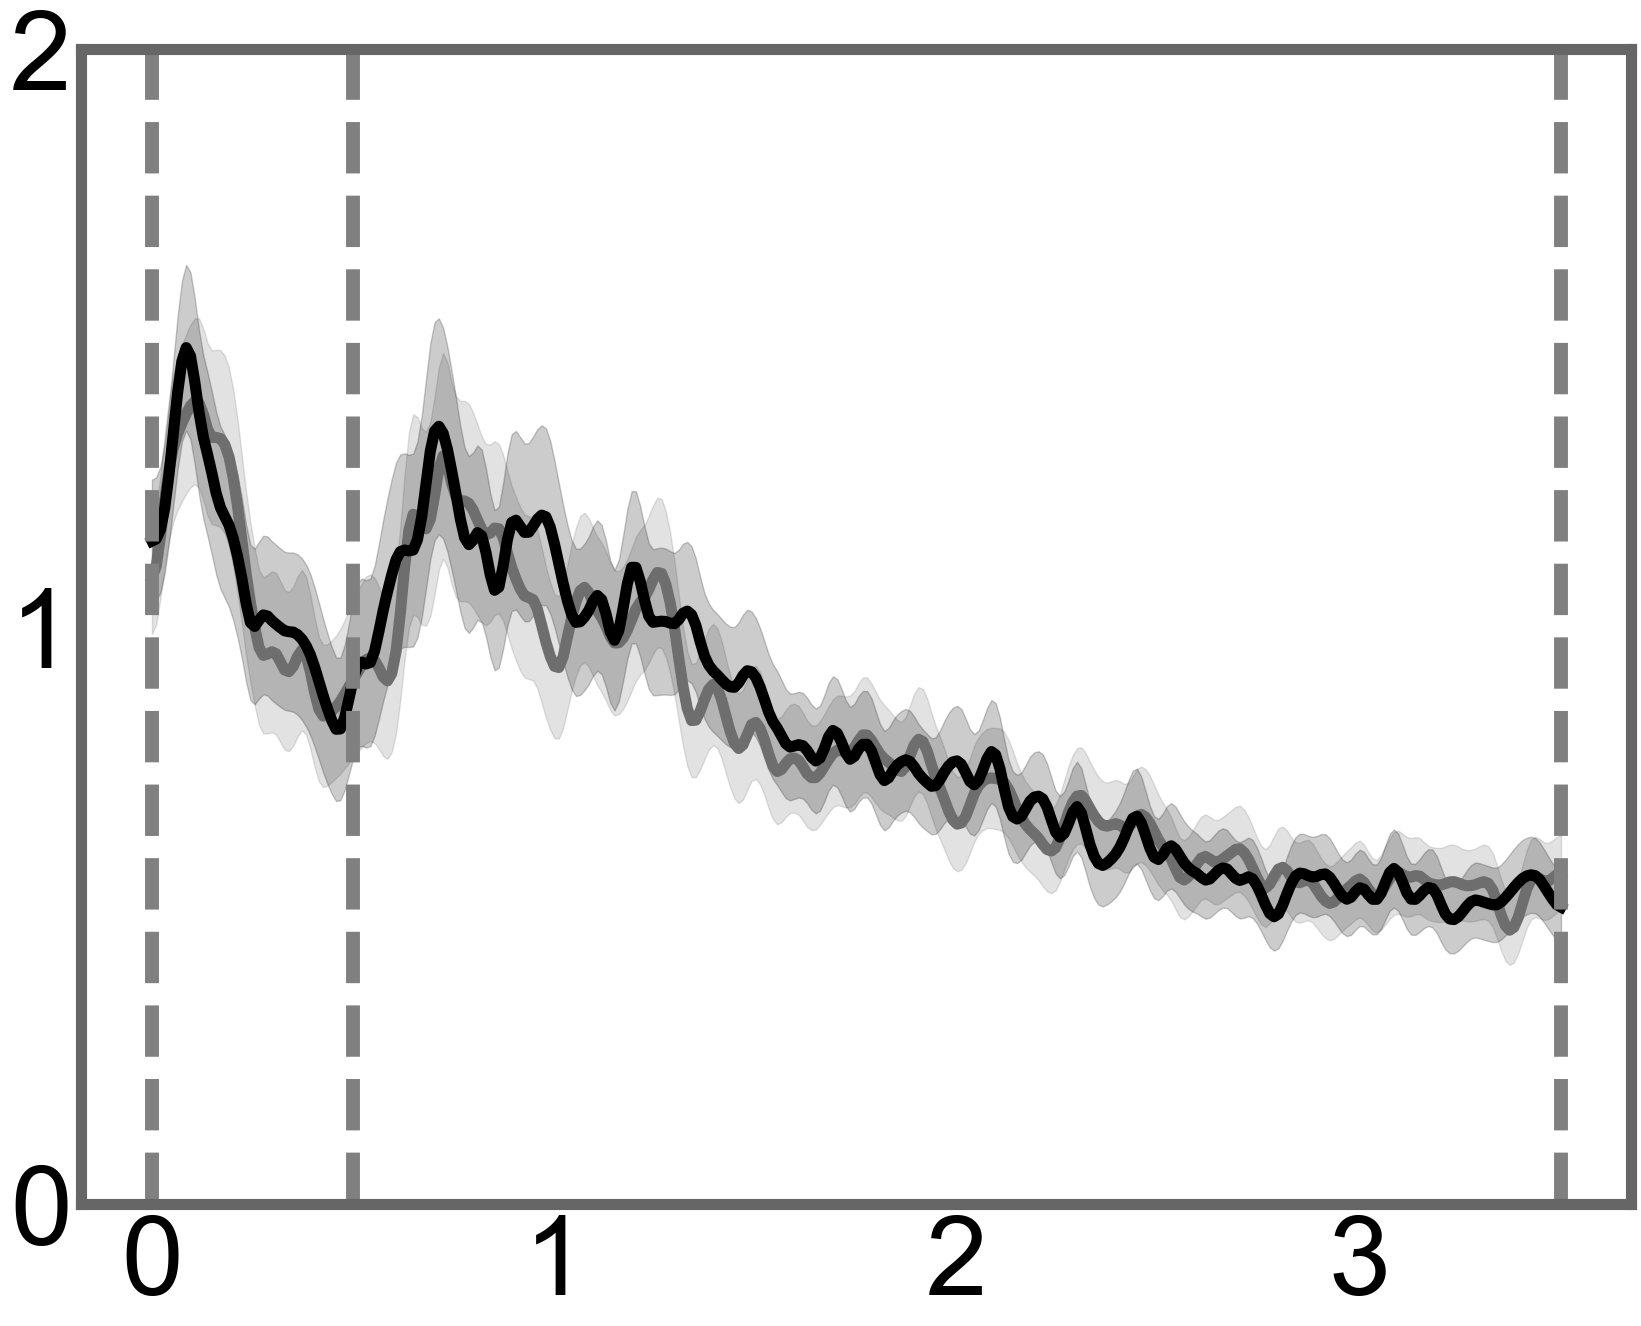

In [86]:
fs(20,15)
lenData = 330
x = np.linspace(0,3.5,lenData)
fig,ax = plt.subplots()

[plt.plot(x,smooth(ipaRollingMean.iloc[i,:lenData],11),c = cList[i],label = labelList[i],linewidth = 8) for i in range(2)]
[plt.fill_between(x,smooth(ipaRollingUpper.iloc[i,:lenData]),smooth(ipaRollingLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in range(2)]

plt.vlines([0,0.5,3.5],0,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1));
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylim(0,2)


plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)


In [230]:
ipaDf

Unnamed: 0       ipa         TRIALID cuedItemBri  participant trlType  \
0              0  1.000000   ('249', 0, 0)         day        249.0  visual   
1              1  1.546193   ('249', 0, 1)       night        249.0  verbal   
2              2  1.000000  ('249', 0, 10)         day        249.0  visual   
3              3  1.333333  ('249', 0, 11)         day        249.0  verbal   
4              4  2.003339  ('249', 0, 12)         day        249.0  visual   
...          ...       ...             ...         ...          ...     ...   
9487        9487  0.581058   ('296', 9, 5)         day        296.0  visual   
9488        9488  1.108647   ('296', 9, 6)       night        296.0  visual   
9489        9489  2.994012   ('296', 9, 7)       night        296.0  visual   
9490        9490  1.440922   ('296', 9, 8)       night        296.0  visual   
9491        9491  0.783085   ('296', 9, 9)         day        296.0  verbal   

     distractorType  
0      noDistractor  
1      noDistractor  
2       incongruent  
3      noDistractor  
4         congruent  
...             ...  
9487   noDistractor  
9488      congruent  
9489   noDistractor  
9490   noDistractor  
9491   noDistractor  

[9492 rows x 7 columns]

(-0.8, 1.8)

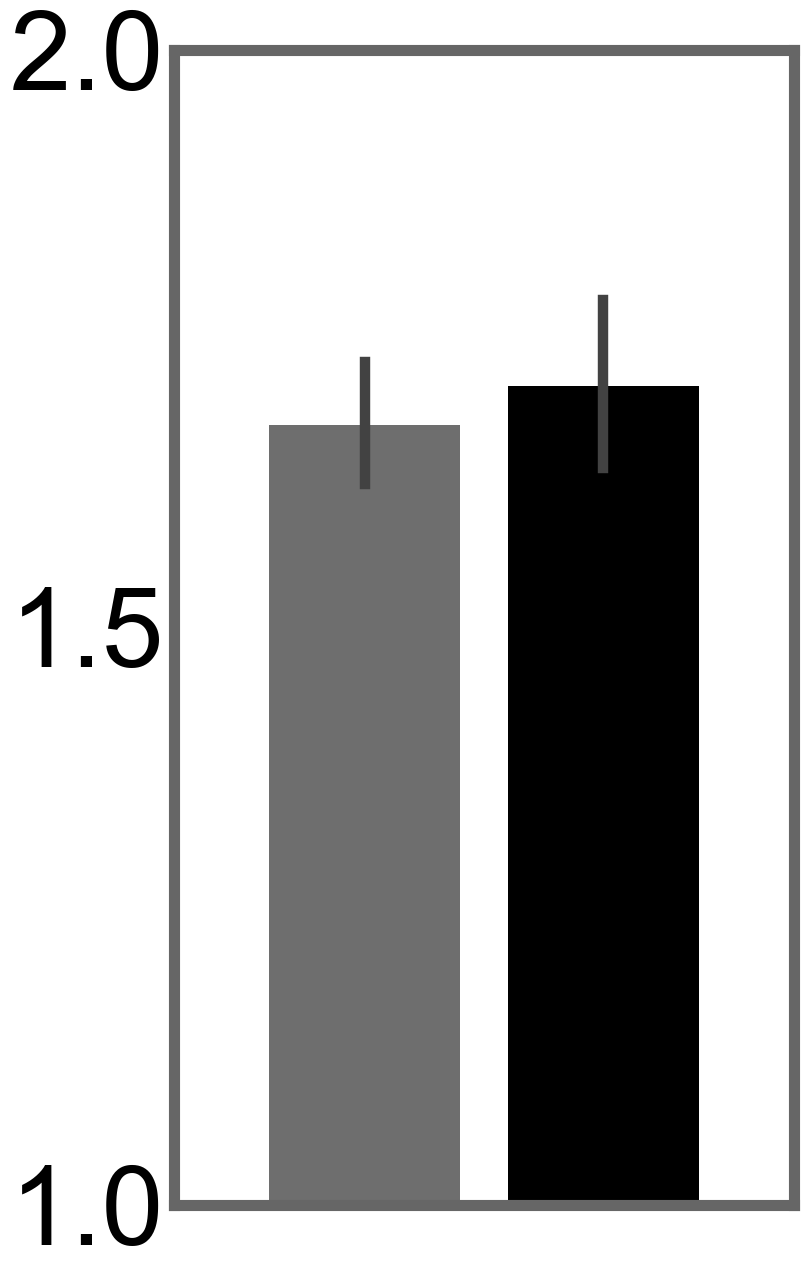

In [92]:
fs(8,15)
cList = ["#6E6E6E","#000000"]

fig,ax = plt.subplots()
sns.barplot(x = 'cuedItemBri',y = 'ipa',order=['day','night'],
            errwidth= 7.5,
            data = ipaDf,palette=cList)
plt.ylim(1,2)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.tick_params(axis='y', which='major', labelsize=80)

plt.tick_params(axis = 'y',labelsize=80)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');

plt.xlim(-0.8, 1.8) 


(-0.8, 1.8)

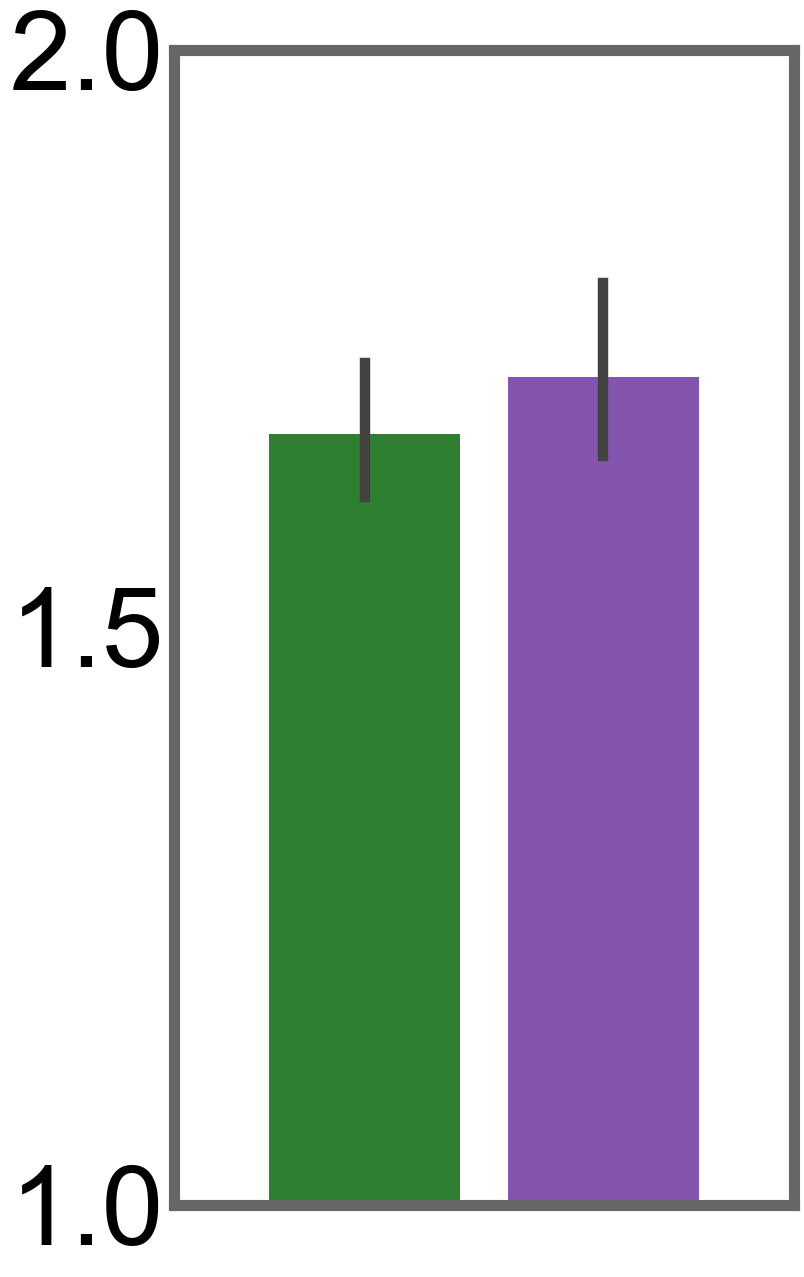

In [93]:
fs(8,15)

cList = ["#8446be","#218d23"]

fig,ax = plt.subplots()
sns.barplot(x = 'trlType',y = 'ipa',order=['visual','verbal'],
            errwidth= 7.5,
            data = ipaDf,palette=cList[::-1])
plt.ylim(1,2)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.tick_params(axis='y', which='major', labelsize=80)

plt.tick_params(axis = 'y',labelsize=80)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');
plt.xlim(-0.8, 1.8) 


In [217]:
pg.rm_anova(data = ipaDf, within=['cuedItemBri','trlType'], subject='participant',dv = 'ipa')

Source        SS  ddof1  ddof2        MS         F  \
0            cuedItemBri  0.063189      1     43  0.063189  0.431212   
1                trlType  0.085406      1     43  0.085406  1.914426   
2  cuedItemBri * trlType  0.002832      1     43  0.002832  0.033209   

      p-unc  p-GG-corr       ng2  eps  
0  0.514894   0.514894  0.000998  1.0  
1  0.173614   0.173614  0.001349  1.0  
2  0.856255   0.856255  0.000045  1.0

In [335]:
ipaDf

Unnamed: 0       ipa         TRIALID cuedItemBri  participant trlType  \
0              0  1.000000   ('249', 0, 0)         day        249.0  visual   
1              1  1.546193   ('249', 0, 1)       night        249.0  verbal   
2              2  1.000000  ('249', 0, 10)         day        249.0  visual   
3              3  1.333333  ('249', 0, 11)         day        249.0  verbal   
4              4  2.003339  ('249', 0, 12)         day        249.0  visual   
...          ...       ...             ...         ...          ...     ...   
9487        9487  0.581058   ('296', 9, 5)         day        296.0  visual   
9488        9488  1.108647   ('296', 9, 6)       night        296.0  visual   
9489        9489  2.994012   ('296', 9, 7)       night        296.0  visual   
9490        9490  1.440922   ('296', 9, 8)       night        296.0  visual   
9491        9491  0.783085   ('296', 9, 9)         day        296.0  verbal   

     distractorType  
0      noDistractor  
1      noDistractor  
2       incongruent  
3      noDistractor  
4         congruent  
...             ...  
9487   noDistractor  
9488      congruent  
9489   noDistractor  
9490   noDistractor  
9491   noDistractor  

[9492 rows x 7 columns]

# gaze

In [5]:
loadRawSacc = False

In [8]:
if loadRawSacc:
    shiftDf_rel = shiftDf_rel.reset_index()

    shiftDf = shiftDf_rel[shiftDf_rel.axis == 'x'].iloc[:,1:].merge(psyFull[['TRIALID','cuedItem']])
    shiftDf = shiftDf.set_index('cuedItem')

    toward = shiftDf.copy()
    away = shiftDf.copy()

    leftAll = toward.loc['left'].iloc[:,2:].values
    toward.loc['left',toward.columns[2:]] = np.where(leftAll < 0,1,0)
    rightAll = toward.loc['right'].iloc[:,2:].values
    toward.loc['right',toward.columns[2:]] = np.where(rightAll > 0,1,0)

    leftAll = away.loc['left'].iloc[:,2:].values
    away.loc['left',away.columns[2:]] = np.where(leftAll > 0,1,0)
    rightAll = away.loc['right'].iloc[:,2:].values
    away.loc['right', away.columns[2:]] = np.where(rightAll <0,1,0)

    #get frequency
    winsize = 100
    freq = 1000
    towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
    awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize

    towardFreq.insert(0,'TRIALID',toward.TRIALID)
    awayFreq.insert(0,'TRIALID',away.TRIALID)
    towardFreq['towardness'] = 'toward'
    awayFreq['towardness'] = 'away'
    towardnessDf = pd.concat([towardFreq,awayFreq],axis = 0)
    towardnessDf = towardnessDf.reset_index()
    towardnessDf = towardnessDf.merge(psyFull[['trlType','TRIALID']])

else:
    towardnessDf = pd.read_csv('Z:/yueying/psychedeLights_YueyingDong/results/data/saccClean/towardnessDf.csv').iloc[:,1:]

In [9]:
qq = towardnessDf.groupby(['towardness','trlType']).mean(numeric_only=True)
qqSd = towardnessDf.groupby(['towardness','trlType']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

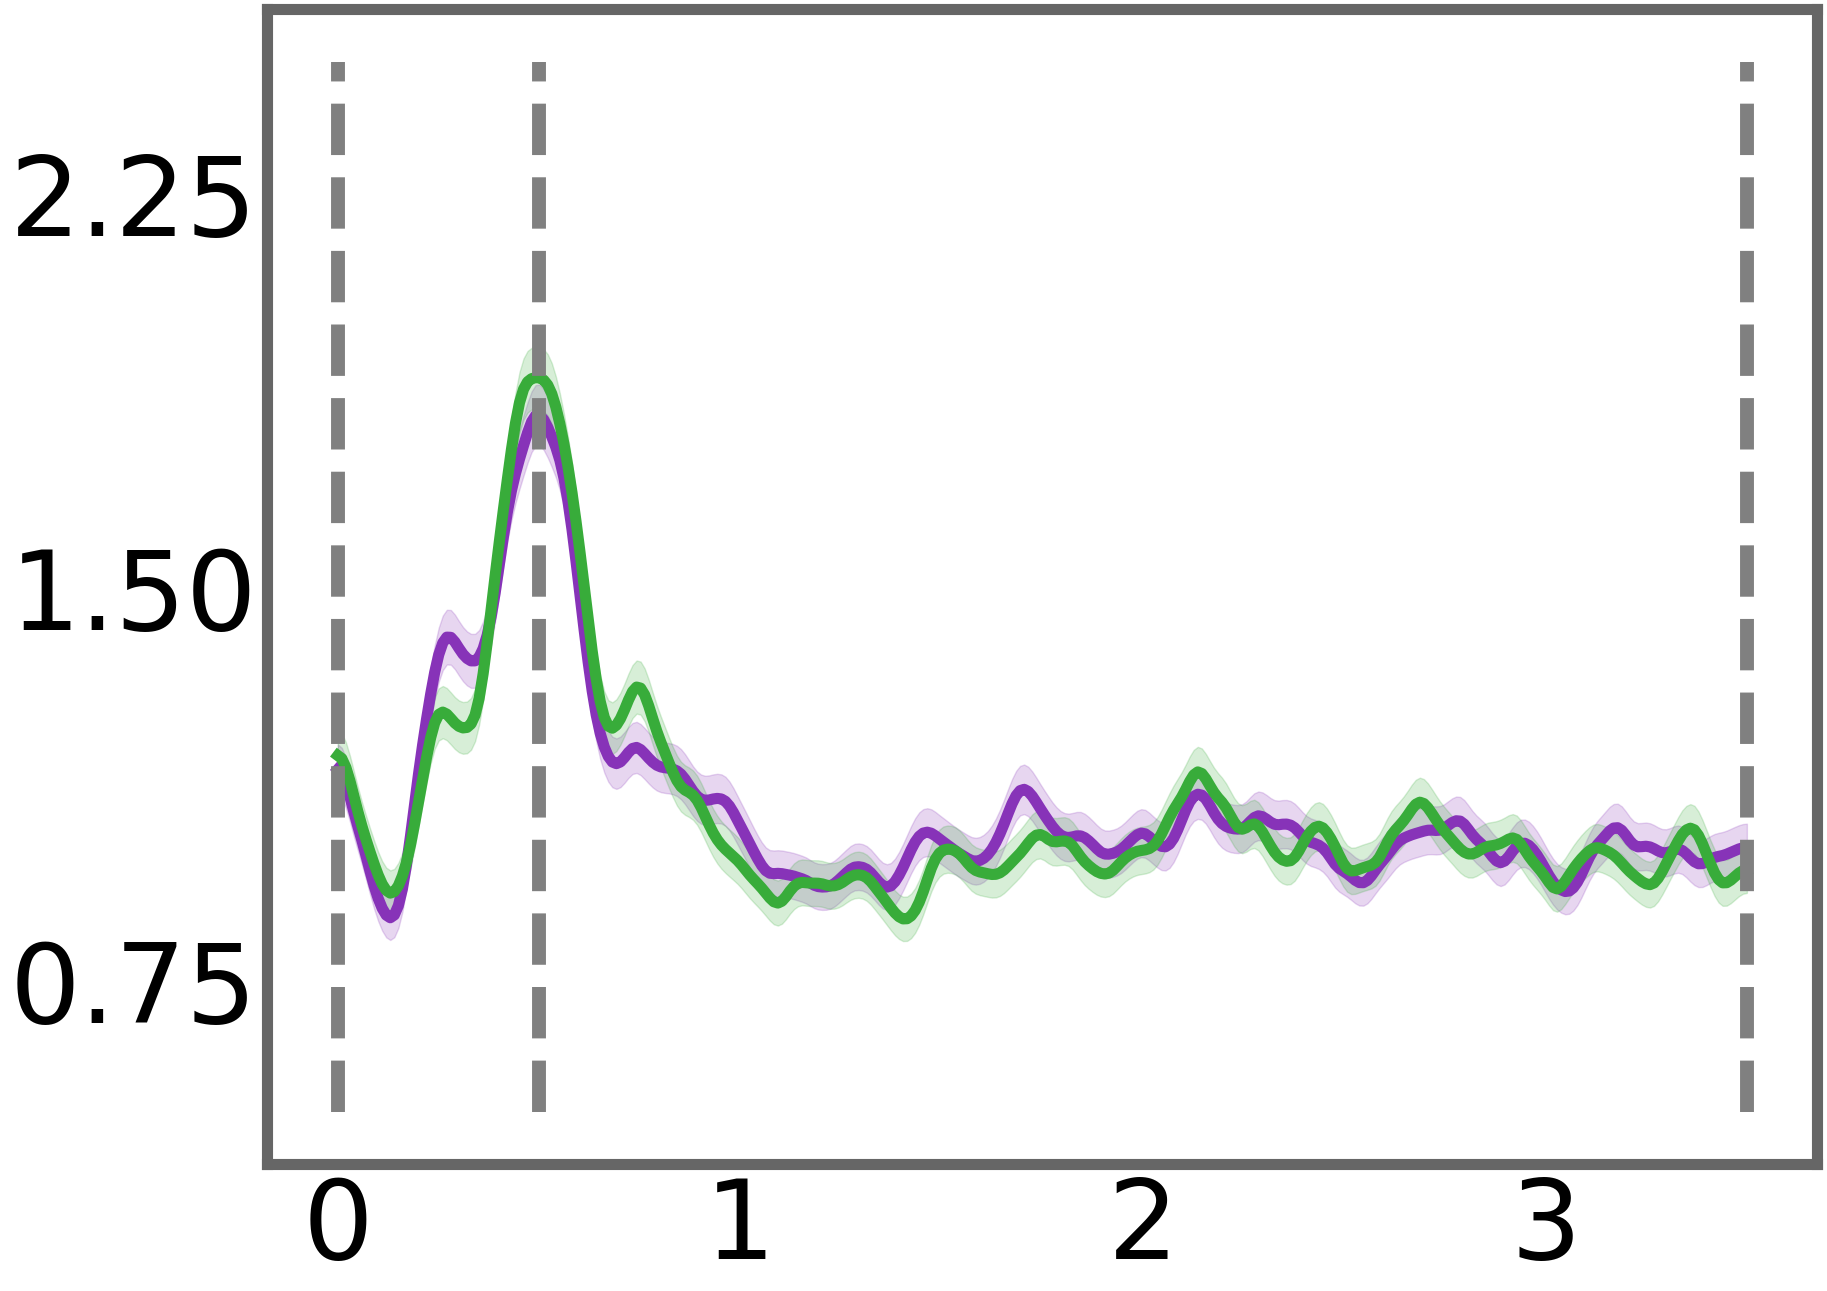

In [17]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth(qq.iloc[i,4001:7501:10],11),c = ["#8733b8","#38ac3a",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth(saccUpper.iloc[i,4001:7501:10]),
                       smooth(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#8733b8","#38ac3a",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

In [49]:
towardnessDf_bri = towardnessDf.merge(psyFull[['TRIALID','cuedItemBri','participant']],how = 'left')


In [50]:
qq = towardnessDf_bri.groupby(['towardness','cuedItemBri']).mean(numeric_only=True)
qqSd = towardnessDf_bri.groupby(['towardness','cuedItemBri']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

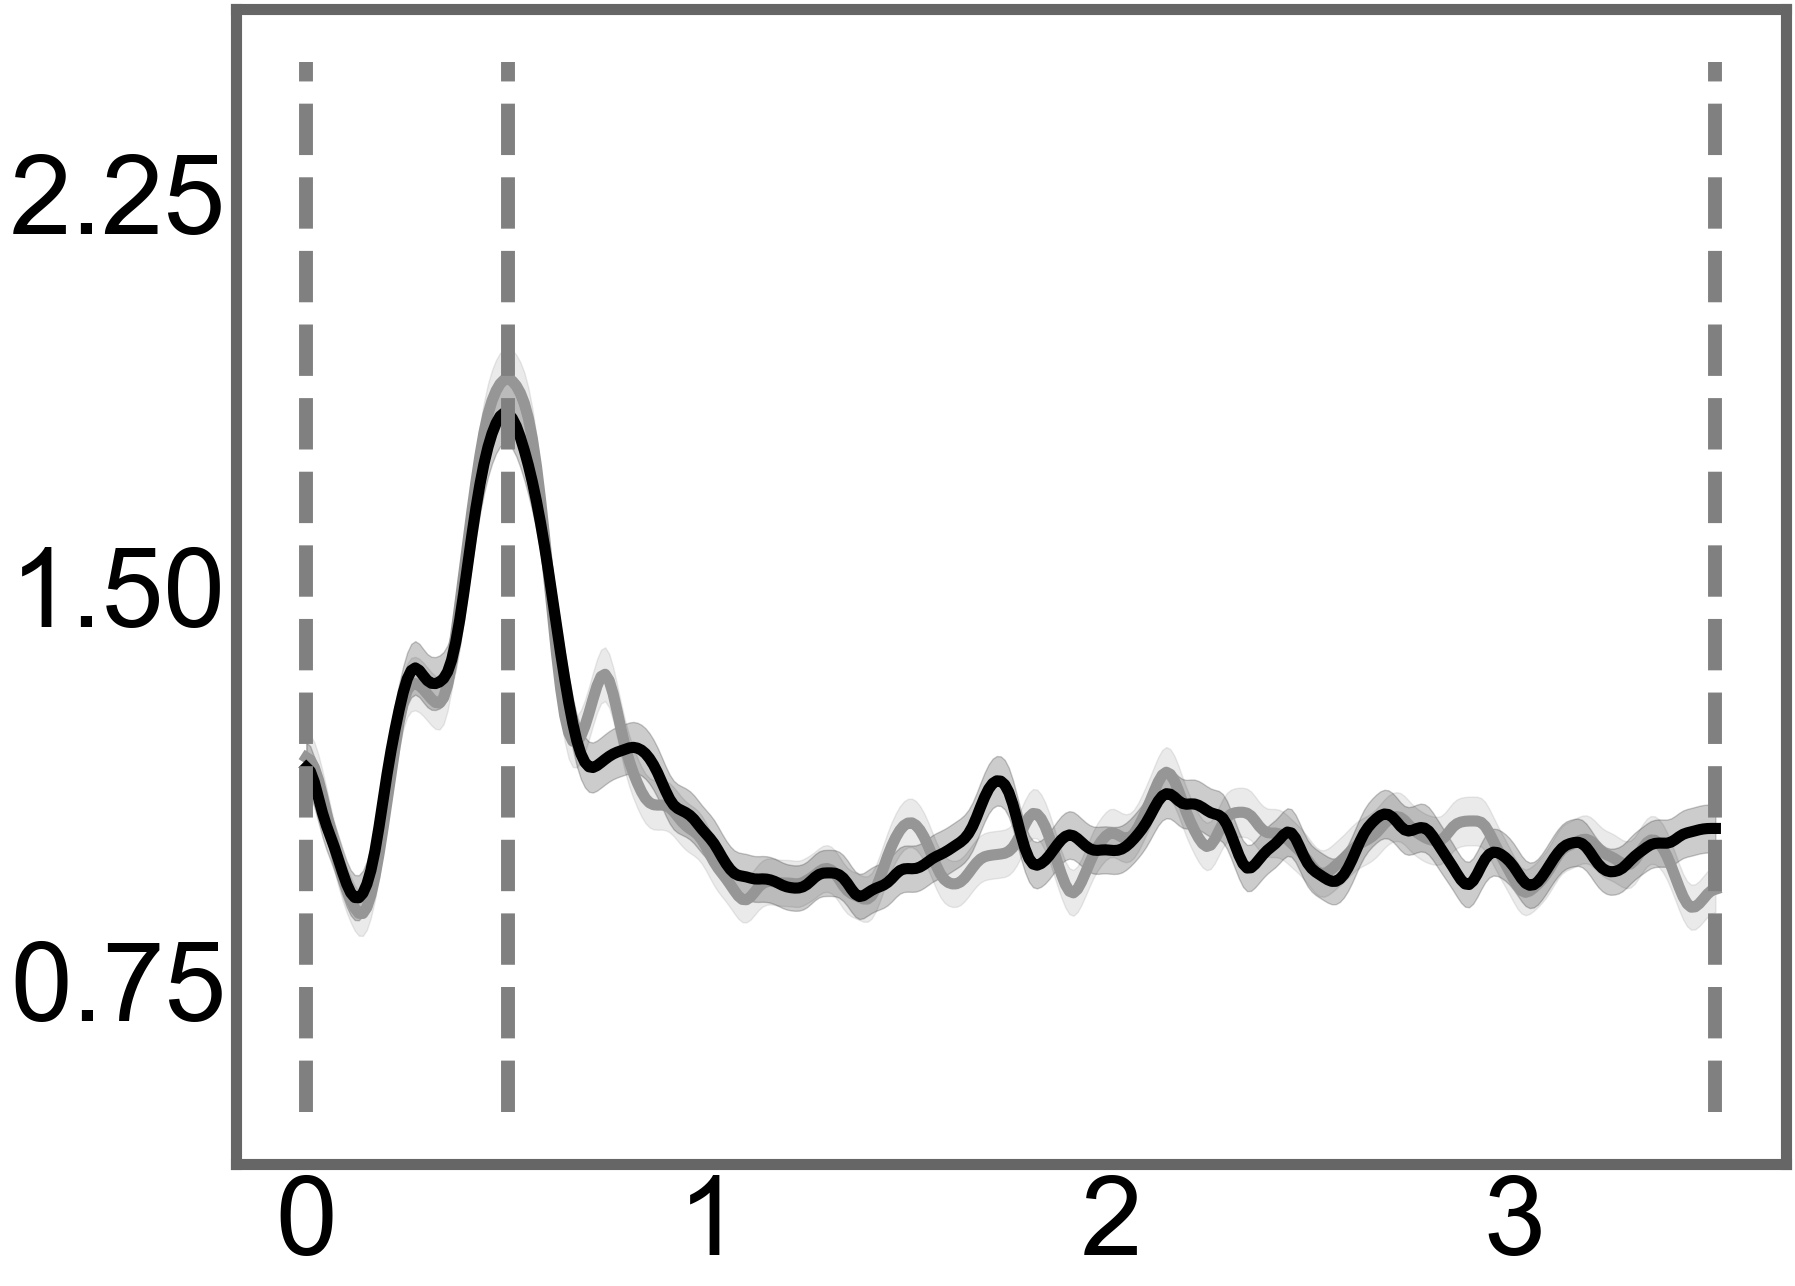

In [51]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth(qq.iloc[i,4001:7501:10],11),c = ["#969696","#000000",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth(saccUpper.iloc[i,4001:7501:10]),
                       smooth(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#969696","#000000",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

In [106]:
a =  towardnessDf_bri[(towardnessDf_bri.towardness == 'toward')].iloc[:,4002:7502]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,towardnessDf_bri[(towardnessDf_bri.towardness == 'toward')][['cuedItemBri']]],axis = 1)

In [107]:
"""
perms = 5000
dataN = 35
fCluster = np.zeros(perms) 

for n in range(perms):
    print(n)
    
    # shuffle condition label
    dsPup['randLabel'] = np.random.permutation(dsPup['cuedItemBri'].values)
    pseudoBri = dsPup[dsPup.randLabel == 'day'].iloc[:,:dataN]
    pseudoDar = dsPup[dsPup.randLabel == 'night'].iloc[:,:dataN]
    
    # calcualte the permutated statistic (e.g. F values, t values) and p values
    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],
                                    nan_policy='omit',) [:2] for i in range(dataN)])
    
    statArr = tp[:,0]
    pArr = tp[:,1]
    
    # find the clusters that exceed p value threshold
    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

    # find the cluster with the largest length,then find its corresponding t values, sum it up
            #note: if no cluster is found, this will return 0
    fCluster[n] =  np.round(statArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)

"""

"\nperms = 5000\ndataN = 35\nfCluster = np.zeros(perms) \n\nfor n in range(perms):\n    print(n)\n    \n    # shuffle condition label\n    dsPup['randLabel'] = np.random.permutation(dsPup['cuedItemBri'].values)\n    pseudoBri = dsPup[dsPup.randLabel == 'day'].iloc[:,:dataN]\n    pseudoDar = dsPup[dsPup.randLabel == 'night'].iloc[:,:dataN]\n    \n    # calcualte the permutated statistic (e.g. F values, t values) and p values\n    tp = np.array([stats.ttest_ind(pseudoBri.iloc[:,i],pseudoDar.iloc[:,i],\n                                    nan_policy='omit',) [:2] for i in range(dataN)])\n    \n    statArr = tp[:,0]\n    pArr = tp[:,1]\n    \n    # find the clusters that exceed p value threshold\n    consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)\n\n    # find the cluster with the largest length,then find its corresponding t values, sum it up\n            #note: if no cluster is found, this will return 0\n    fCluster[n] =  np.round(statArr[consGroups[np.ar

In [108]:
#np.save('Z:/yueying/psychedeLights_YueyingDong/results/gazePerm/tCluster_bridar_saccFreq5000.npy',fCluster,)

In [109]:
fCluster = np.load('Z:/yueying/psychedeLights_YueyingDong/results/gazePerm/tCluster_bridar_saccFreq5000.npy')

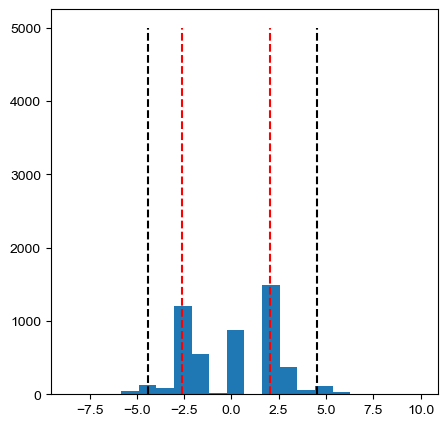

In [112]:
fs(5,5)
dataN = 35
perms = 5000

realBri = dsPup[dsPup.cuedItemBri == 'day'].iloc[:,:dataN]
realDar = dsPup[dsPup.cuedItemBri == 'night'].iloc[:,:dataN]
    
# calcualte the permutated statistic (e.g. F values, t values) and p values
tp = np.array([stats.ttest_ind(realBri.iloc[:,i],realDar.iloc[:,i],
                                nan_policy='omit',) [:2] for i in range(dataN)])

statArr = tp[:,0]
pArr = tp[:,1]


# find the clusters that exceed p value threshold
consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

#get the p value for each cluster
fsum = [statArr[i].sum() for i in consGroups]
pValue = [sum(fCluster > i)/perms for i in fsum]



plt.hist(fCluster,bins = 20)
plt.vlines(np.percentile(fCluster,97.5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster,2.5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r')



In [113]:
pValue

[0.3392, 0.9018]

In [114]:

consGroups

[array([7], dtype=int64), array([34], dtype=int64)]

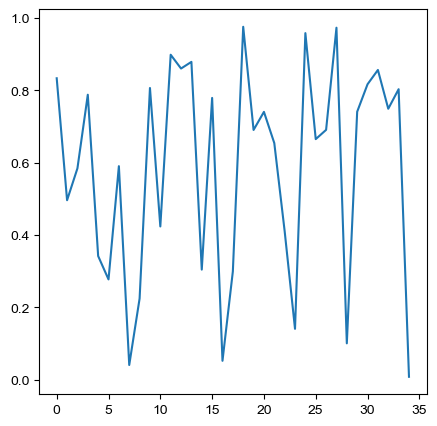

In [115]:
plt.plot(pArr)

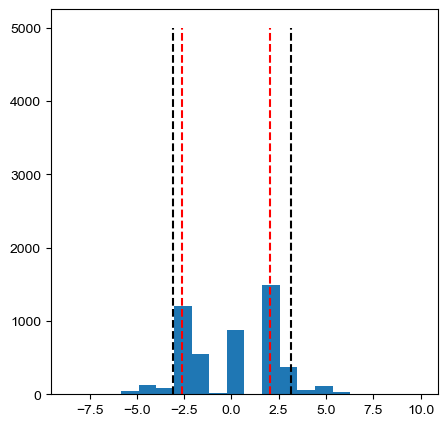

In [182]:

# find the clusters that exceed p value threshold
consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,findSame = False)

#get the p value for each cluster
fsum = [statArr[i].sum() for i in consGroups]
pValue = [sum(fCluster > i)/perms for i in fsum]



plt.hist(fCluster,bins = 20)
plt.vlines(np.percentile(fCluster,95),0,perms,linestyles = 'dashed',color ='black')
plt.vlines(np.percentile(fCluster,5),0,perms,linestyles = 'dashed',color ='black')
plt.vlines([fsum],0,perms,linestyles = 'dashed',color ='r')



In [ ]:
gazeTemp = saccClean.reset_index().merge(psyFull[['TRIALID','cuedItem',]]).set_index(['cuedItem','axis'])

In [ ]:
np.mean(gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten())

513.1021268929791

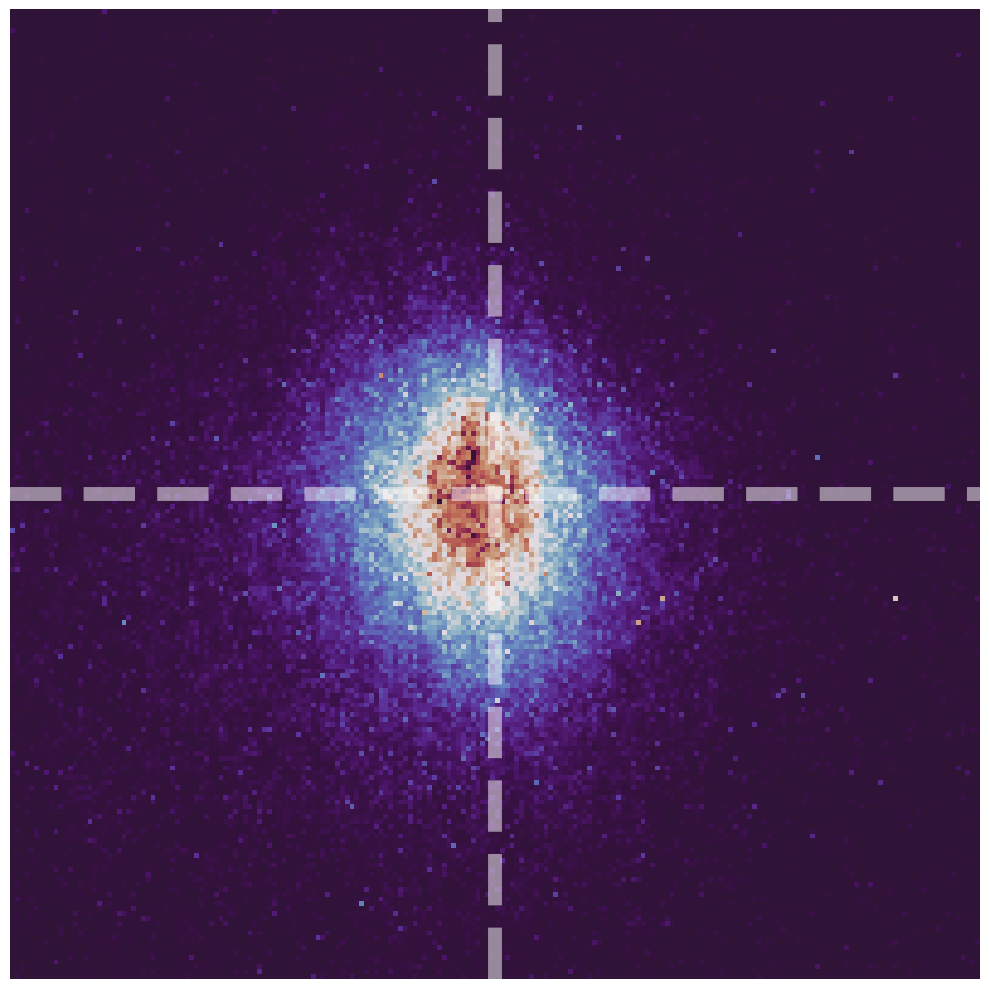

In [ ]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
leftVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

#plt.title('gaze position during retrocue & delay',size = 15)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


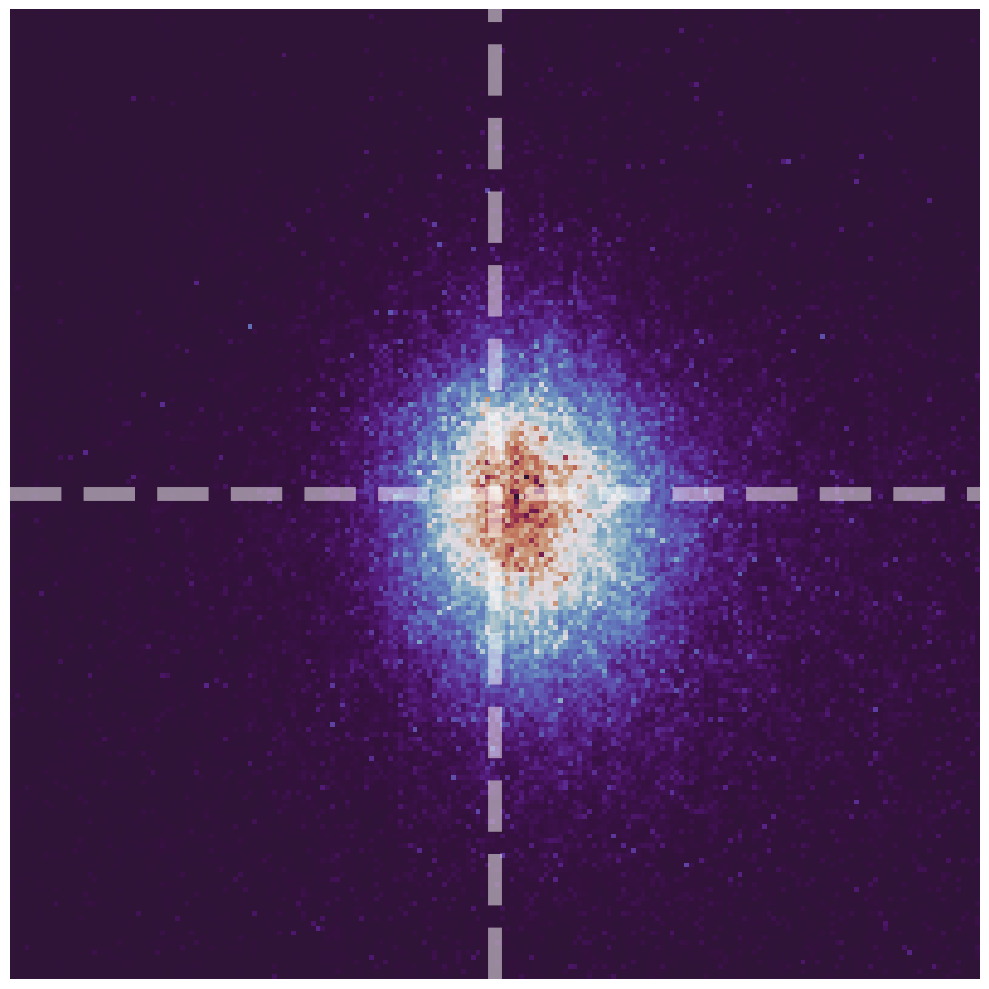

In [ ]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
rightVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

#plt.title('gaze position during retrocue & delay',size = 15)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


(-0.5, 210.025, 210.025, -0.5)

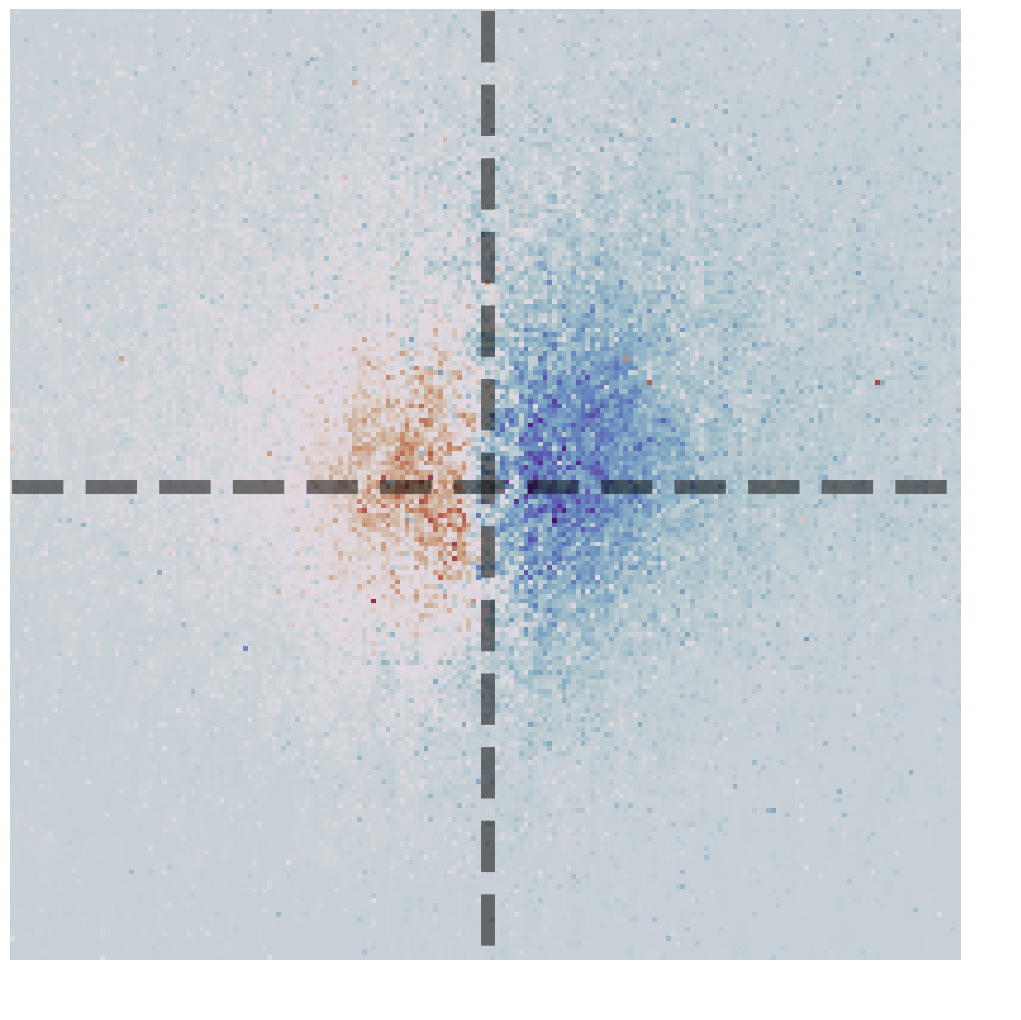

In [ ]:
fs(13,13)

plt.imshow((leftVal - rightVal).T,cmap='twilight_shifted',vmin = -0.00032,vmax = 0.0004)
plt.vlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)
plt.hlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)

plt.axis('off')


(-0.5, 210.025, 210.025, -0.5)

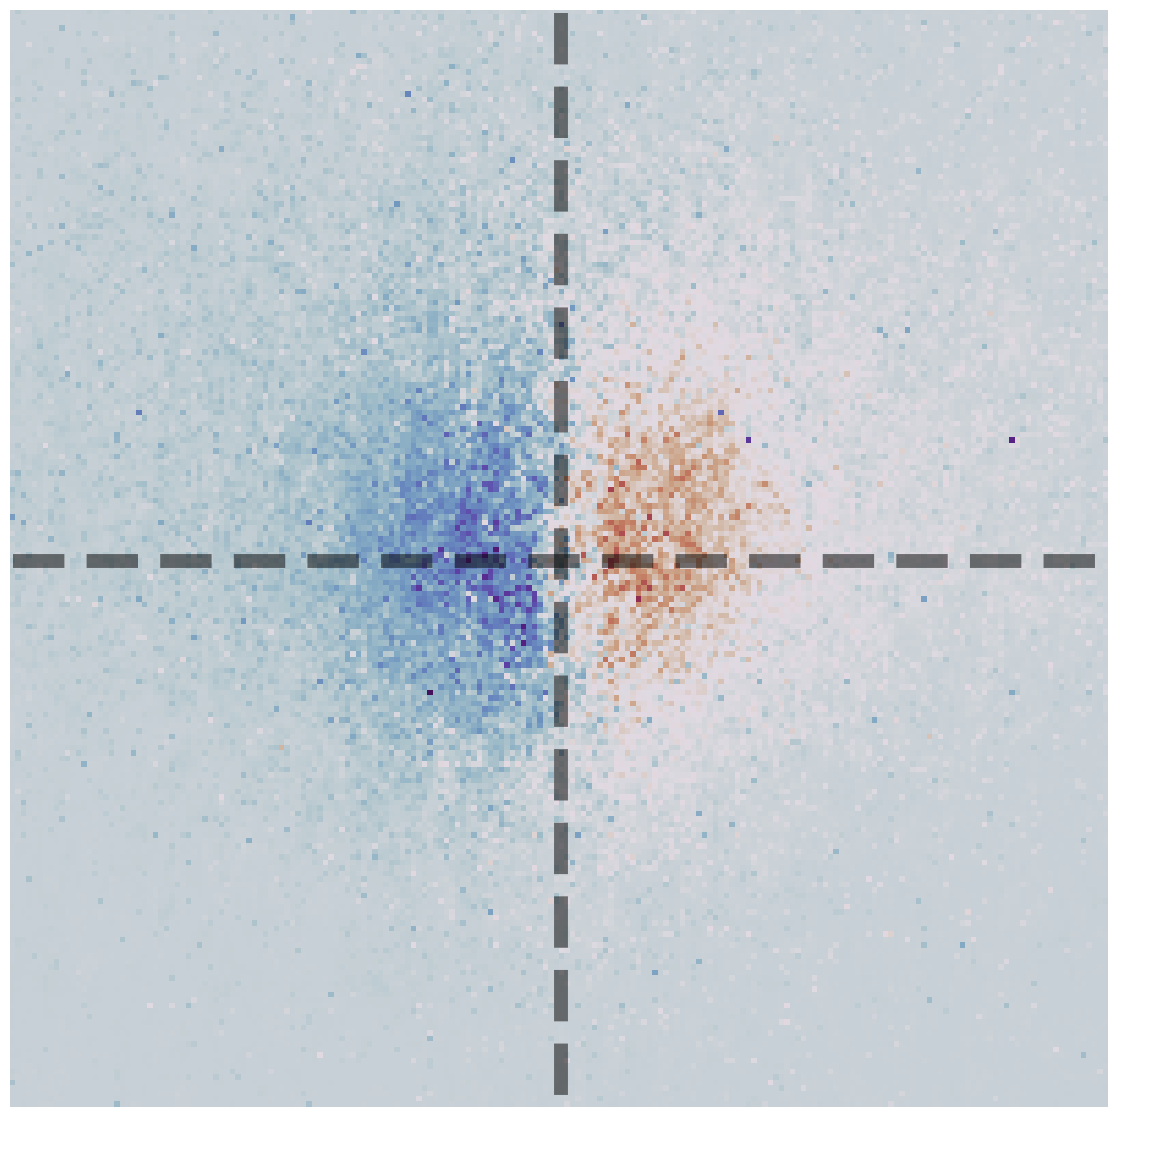

In [ ]:
plt.imshow((rightVal-leftVal).T,cmap='twilight_shifted',vmin = -0.00032,vmax = 0.0004)
plt.vlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)
plt.hlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)

plt.axis('off')